<a href="https://colab.research.google.com/github/LeiteJu/TCC/blob/main/modelos/regressao_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Linear 

Modelo de regressão linear usado como *baseline*

Esse notebook treina diferentes modelos de regressão linear para prever a demanda por cimento.

Índices:

 

1.   Modelo único para prever para todos os estados (`MUCE`)
2.   Modelo único sem indicar o estado (`MUSE`)
3.   Um modelo para cada estado (`MSPE`)

Em cada um dos modelos acima, fizemos testes aplicando 3 métodos de normalização de dados: standardscaler (`SS`), minmaxscaler (`MM`) e powertransformer (`PT`)?
 e também ser normalizar (`SN`)

In [ ]:
# importamos as libs
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np

sns.set_palette("Set2")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

## Fast Fourier Transform
from numpy.fft import rfft, irfft, rfftfreq, irfftn

## Funções e constantes

In [ ]:
### Constantes que definimos

ANO_INICIAL = 1991
ANO_FINAL = 2019
ANO_BASE = 2017

PATH="/content/drive/MyDrive/TCC/data/csv/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

MAP = dict(zip(SIGLAS+[i for i in range(27)], [i for i in range(27)]+SIGLAS))

In [ ]:
# função que aplica a transformada de Fourier
def pass_ft(s, threshold=2e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-3 / s.size)
    fourier[frequencies > threshold] = 0

    return irfft(fourier,n=len(s))

In [ ]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [ ]:
def show_predictions_graphs (y_pred, y_test):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)

        plt.yscale("log")

        plt.title (f"Distribuição do erro do estado {MAP[state]}")

        pred = y_pred[state]
        real = y_test[state]

        plt.plot(pred, label="Previsão", color="coral")
        plt.plot(real, label="Dado Real", color="darkgreen")

        plt.legend()
    plt.show()

In [ ]:
def split_y_state (y):

    if type(y) == np.ndarray:

        return dict(zip([i for i in range(27)], [[y[i] for i in range(s, len(y), 27)] for s in range(27)]))

    return dict(zip([i for i in range(27)], [[y.iloc[i] for i in range(s, y.size, 27)] for s in range(27)]))


In [ ]:
def print_error (y_pred_state, y_test_state):

    rmse = [mean_squared_error(y_test_state[i], y_pred_state[i], squared=False) for i in range(27)]
    mape = [mean_absolute_percentage_error(y_test_state[i], y_pred_state[i]) for i in range(27)]

    #return pd.Series(rmse + [min(i, 1.0) for i in mape])
    return pd.Series(rmse + mape)

In [ ]:
def show_error_state(y_pred_state, y_test_state):

    plt.figure(figsize=(15,6))

    df = pd.DataFrame(SIGLAS, columns=["estados"])
    df["erro"] = [100*mean_absolute_percentage_error(y_test_state[i], y_pred_state[i]) for i in range(27)]

    sns.barplot(data=df, x="estados", y="erro", palette="Set2")
    plt.ylabel("MAPE por estado em %")

    plt.show()

In [ ]:
def show_error_graphs (y_pred, y_test):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)

        plt.title (f"Distribuição de erro do estado {SIGLAS[state]}")

        pred = y_pred[state]
        real = y_test[state]

        error = [100*(round(mean_absolute_percentage_error([real[i]],[pred[i]]), 1)) for i in range(len(pred))]

        error = [i if i <= 100 else 100.0 for i in error]

        sns.countplot(error)
        plt.xlabel("Faixa de erro")
        plt.ylabel("Número de ocorrências")

    plt.show()

## Ler os dados

Aqui apenas lemos os dados do csv em `/data/csv/`


In [ ]:
# input
x = pd.read_csv(PATH+"input.csv")

# target
y = pd.read_csv(PATH + "target_ac.csv")

In [ ]:
x.head()

estados    data      pib_pc  pib_pmc  pib_pcpt   populacao     pib_cc  ipca  \
0      AC  199101  3281564.10    14.66      0.71   417102.00  186952.88  6.62   
1      AL  199101 14196951.80    74.80      0.51  2512658.00 1045710.98  6.62   
2      AM  199101 14813693.23   192.54      0.63  2102766.00 1727997.07  6.62   
3      AP  199101  2553396.91    17.04      0.79   289035.00   73020.87  6.62   
4      BA  199101 64175572.95   475.73      0.49 11867336.00 6191146.61  6.62   

   incc   igp  selic  idh_long  idh_renda  idh_educacao  nfsp    estoque  \
0  4.70 19.93   2.38      0.65       0.65          0.18 11.17 4782146.59   
1  4.70 19.93   2.38      0.55       0.57          0.17 11.17 4782146.59   
2  4.70 19.93   2.38      0.67       0.53          0.25 11.17 4782146.59   
3  4.70 19.93   2.38      0.65       0.62          0.20 11.17 4782146.59   
4  4.70 19.93   2.38      0.58       0.60          0.18 11.17 4782146.59   

   desemprego  
0        9.22  
1        8.98  
2       11.56  
3        5.92  
4        8.21

In [ ]:
y.head()

data estados    consumo
0  199101      AC   16951.00
1  199102      AL  308951.00
2  199103      AM  259396.00
3  199104      AP   25699.00
4  199105      BA 1166517.00

# Modelo único para todos os estados

Para esse experimentos, vamos testar um modelo único para todos os estados do Brasil, adicionando aos dados um identificador para o estado.

Vamos utilizar One Hot Encoding para indicar o estado, esse método transforma uma variável categórica em colunas binárias para manter a informação necessária mas com um melhor desempenho que o Label Encoding

In [ ]:
df_error = pd.DataFrame(SIGLAS*2, columns=["estados"])
df_error.sort_values(by=["estados"], inplace=True)
df_error["indicador"] = ["RMSE"]*27 + ["MAPE"]*27
df_error.reset_index(inplace=True, drop=True)

## Sem indicar o estado

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop(["data", "estados"], axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")['consumo']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.786513554362164
Scores obtidos:
RMSE: 1130618.0518405573
MAE: 652490.4680486321
MAPE: 0.6651254504010351


In [ ]:
y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)

In [ ]:
#coeficientes da regressão linear -> ver importancia
# prox de 0 -> ignorando
pd.Series(regr.coef_, pd.read_csv(PATH+"input.csv").drop(["data", "estados"], axis=1).columns).sort_values().to_frame(
    name="coef"
).style.background_gradient(cmap="Greens")

#### Gráficos

In [ ]:
df_error["MUSE_SN"] = print_error(y_pred_state, y_test_state)

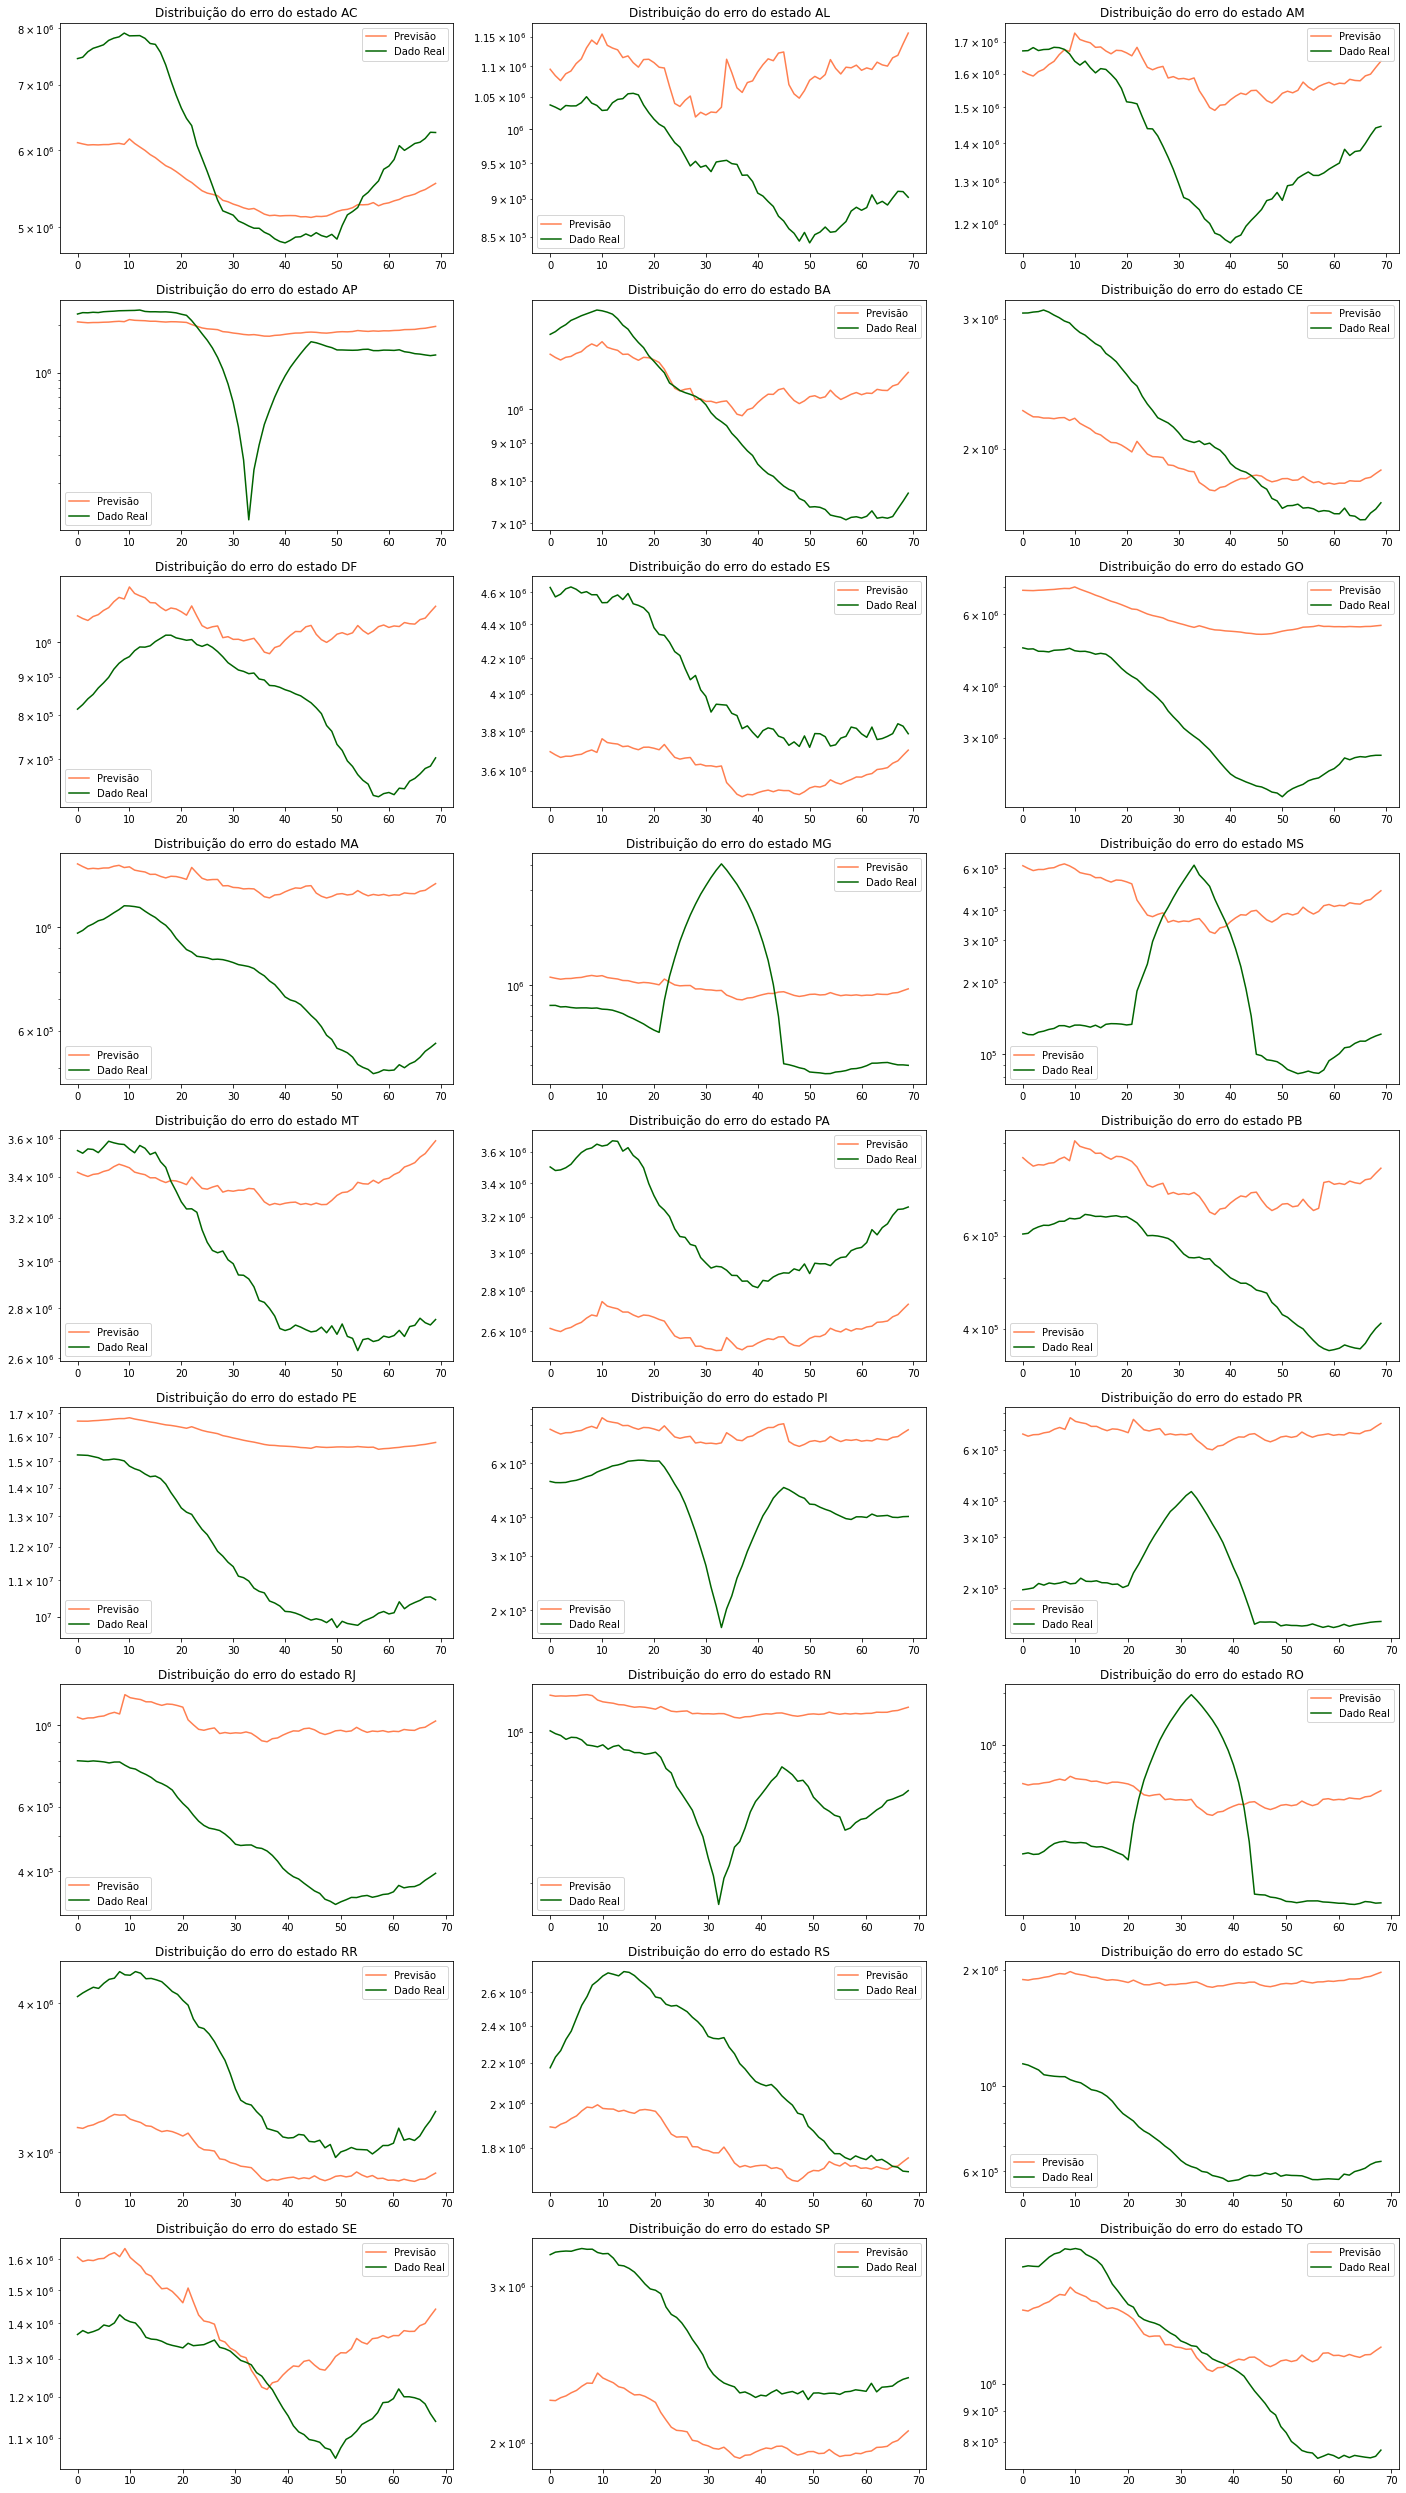

In [ ]:
show_predictions_graphs(y_pred_state, y_test_state)

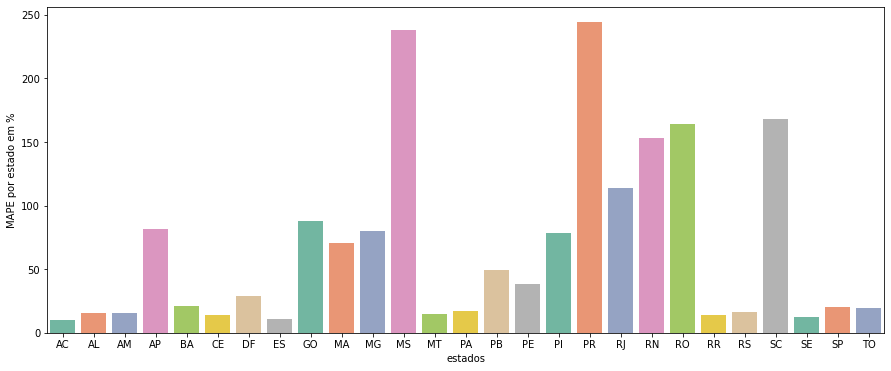

In [ ]:
show_error_state(y_pred_state, y_test_state)

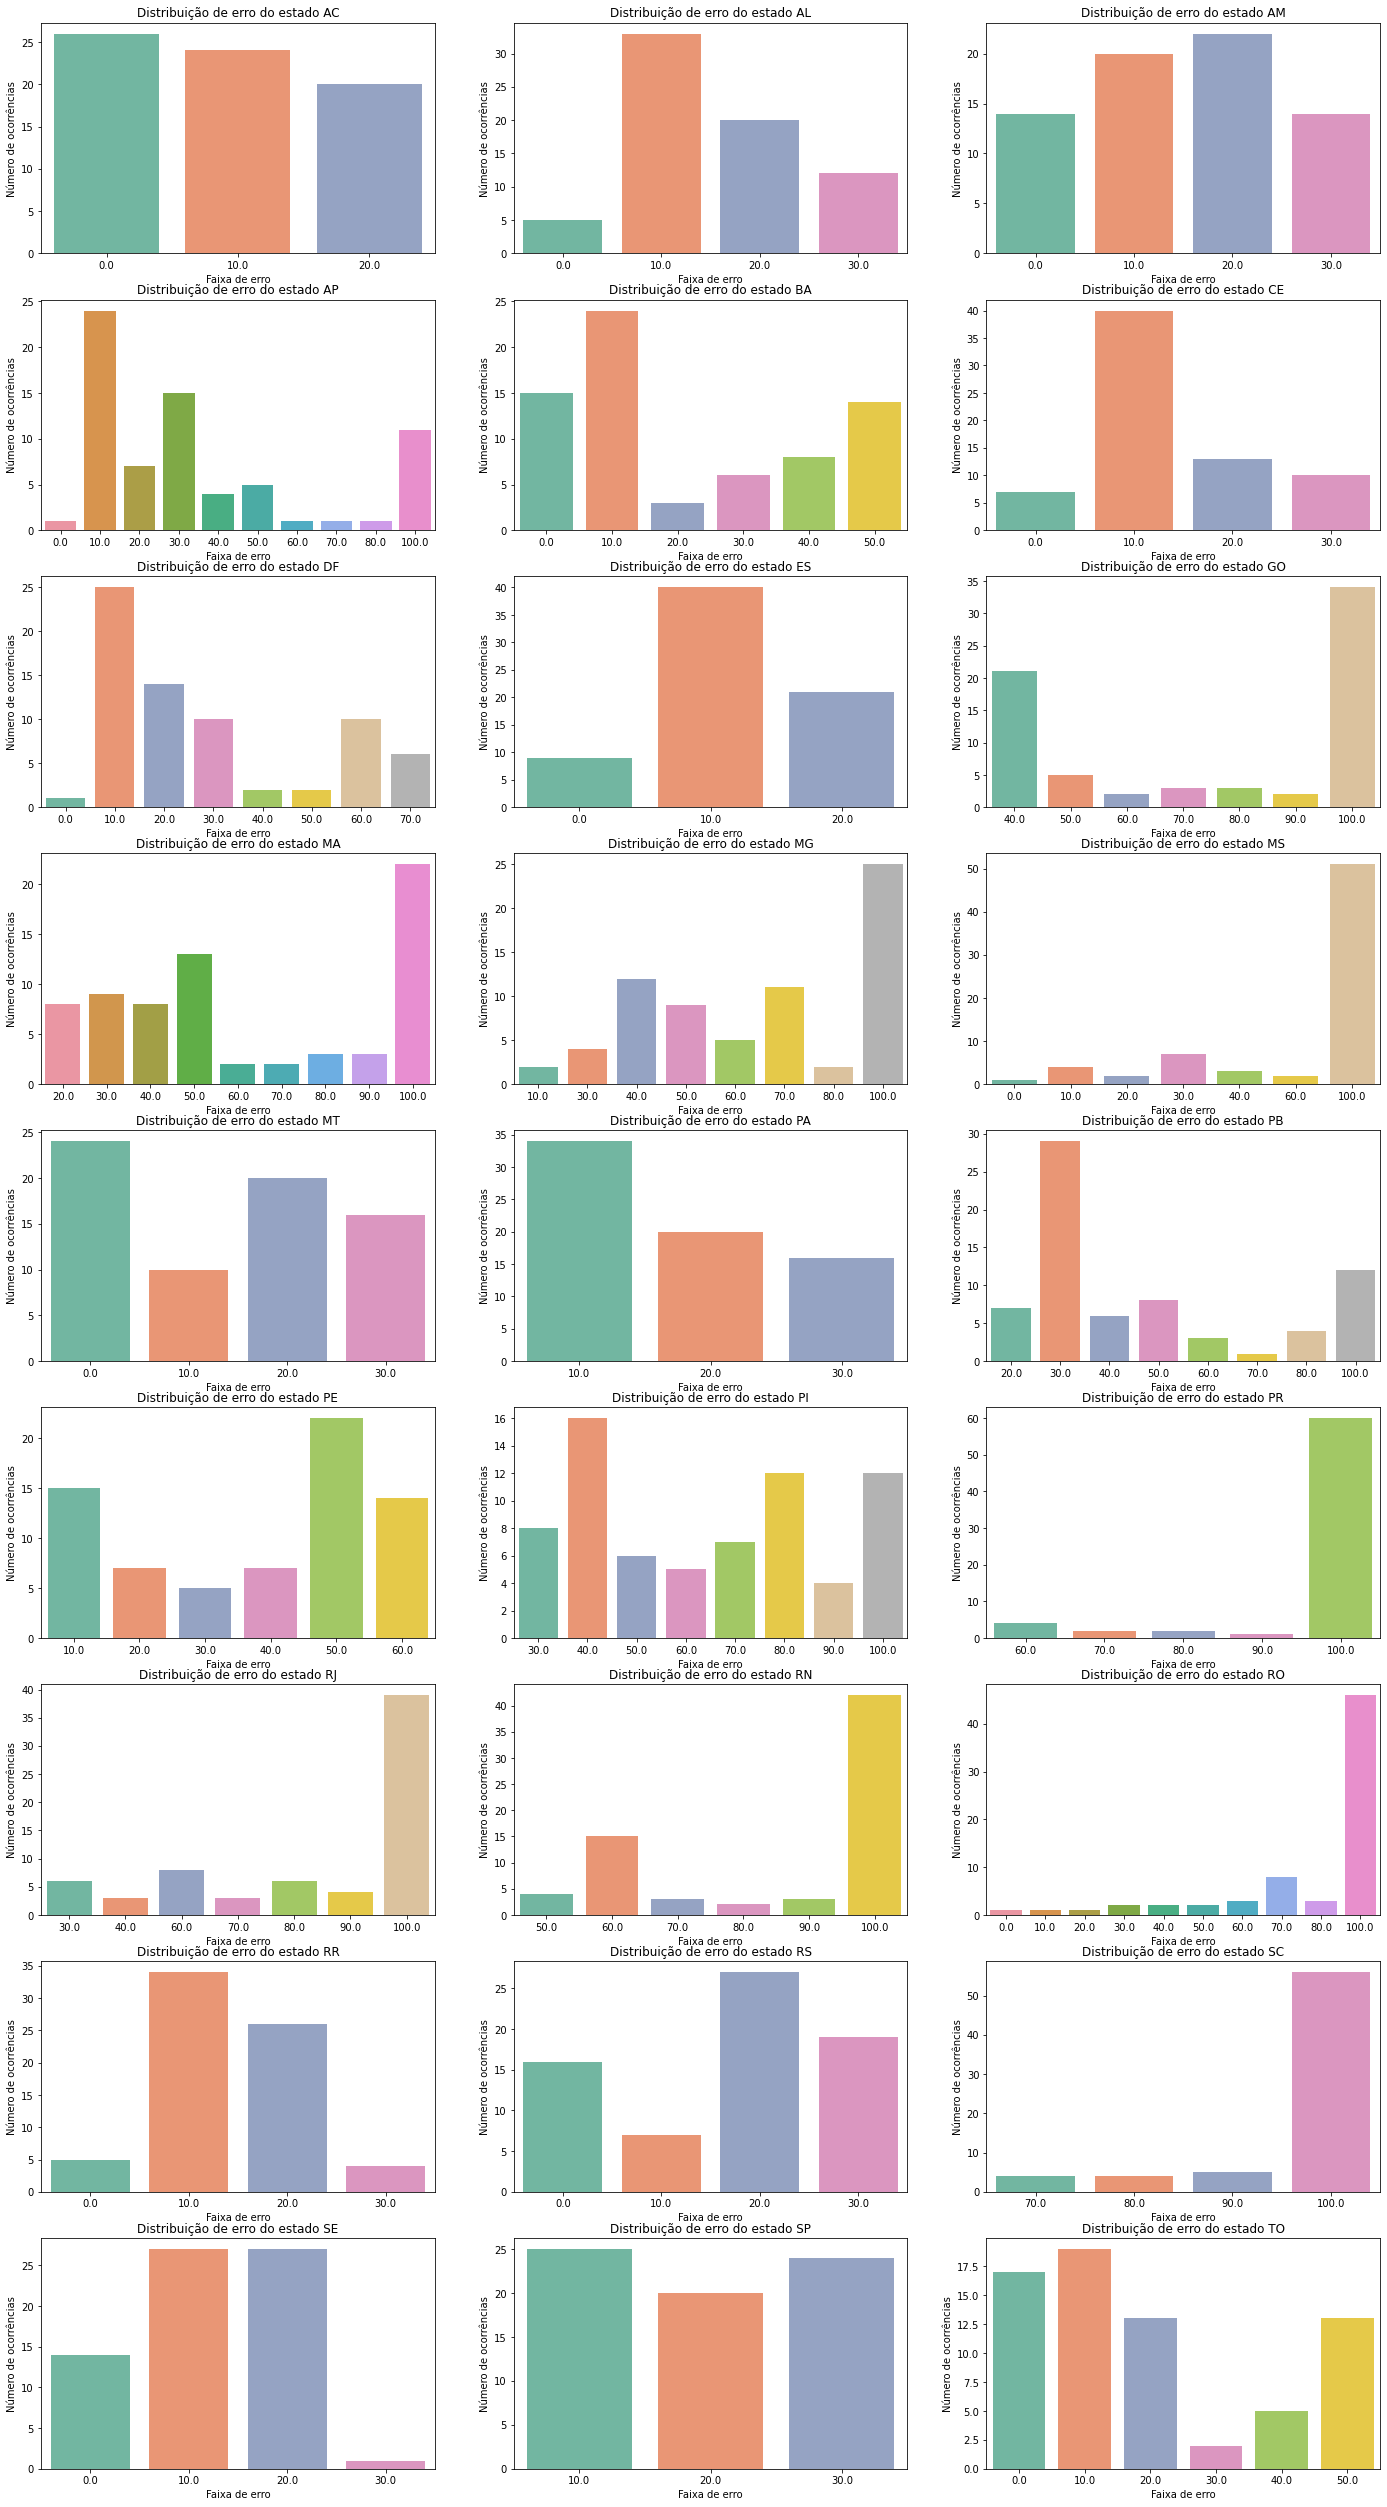

In [ ]:
show_error_graphs(y_pred_state, y_test_state)

## Sem normalizar os dados

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")['consumo']

In [ ]:
# aqui podemos observar as colunas geradas pelo método do one hot encoding
x.head()

pib_pc  pib_pmc  pib_pcpt   populacao     pib_cc  ipca  incc   igp  \
0  3281564.10    14.66      0.71   417102.00  186952.88  6.62  4.70 19.93   
1 14196951.80    74.80      0.51  2512658.00 1045710.98  6.62  4.70 19.93   
2 14813693.23   192.54      0.63  2102766.00 1727997.07  6.62  4.70 19.93   
3  2553396.91    17.04      0.79   289035.00   73020.87  6.62  4.70 19.93   
4 64175572.95   475.73      0.49 11867336.00 6191146.61  6.62  4.70 19.93   

   selic  idh_long  ...  estados_PR  estados_RJ  estados_RN  estados_RO  \
0   2.38      0.65  ...           0           0           0           0   
1   2.38      0.55  ...           0           0           0           0   
2   2.38      0.67  ...           0           0           0           0   
3   2.38      0.65  ...           0           0           0           0   
4   2.38      0.58  ...           0           0           0           0   

   estados_RR  estados_RS  estados_SC  estados_SE  estados_SP  estados_TO  
0           0           0           0           0           0           0  
1           0           0           0           0           0           0  
2           0           0           0           0           0           0  
3           0           0           0           0           0           0  
4           0           0           0           0           0           0  

[5 rows x 41 columns]

In [ ]:
# shuffle = False para os dados continuarem em ordem 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.8633707870649363


In [ ]:
# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 821444.8727562766
MAE: 562083.2719839852
MAPE: 0.8010375611125115


In [ ]:
y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)

In [ ]:
#coeficientes da regressão linear -> ver importancia
# prox de 0 -> ignorando
pd.Series(regr.coef_, x.columns).sort_values().to_frame(
    name="coef"
).style.background_gradient(cmap="Greens")

#### Gráficos

In [ ]:
df_error["MUCE_SN"] = print_error(y_pred_state, y_test_state)

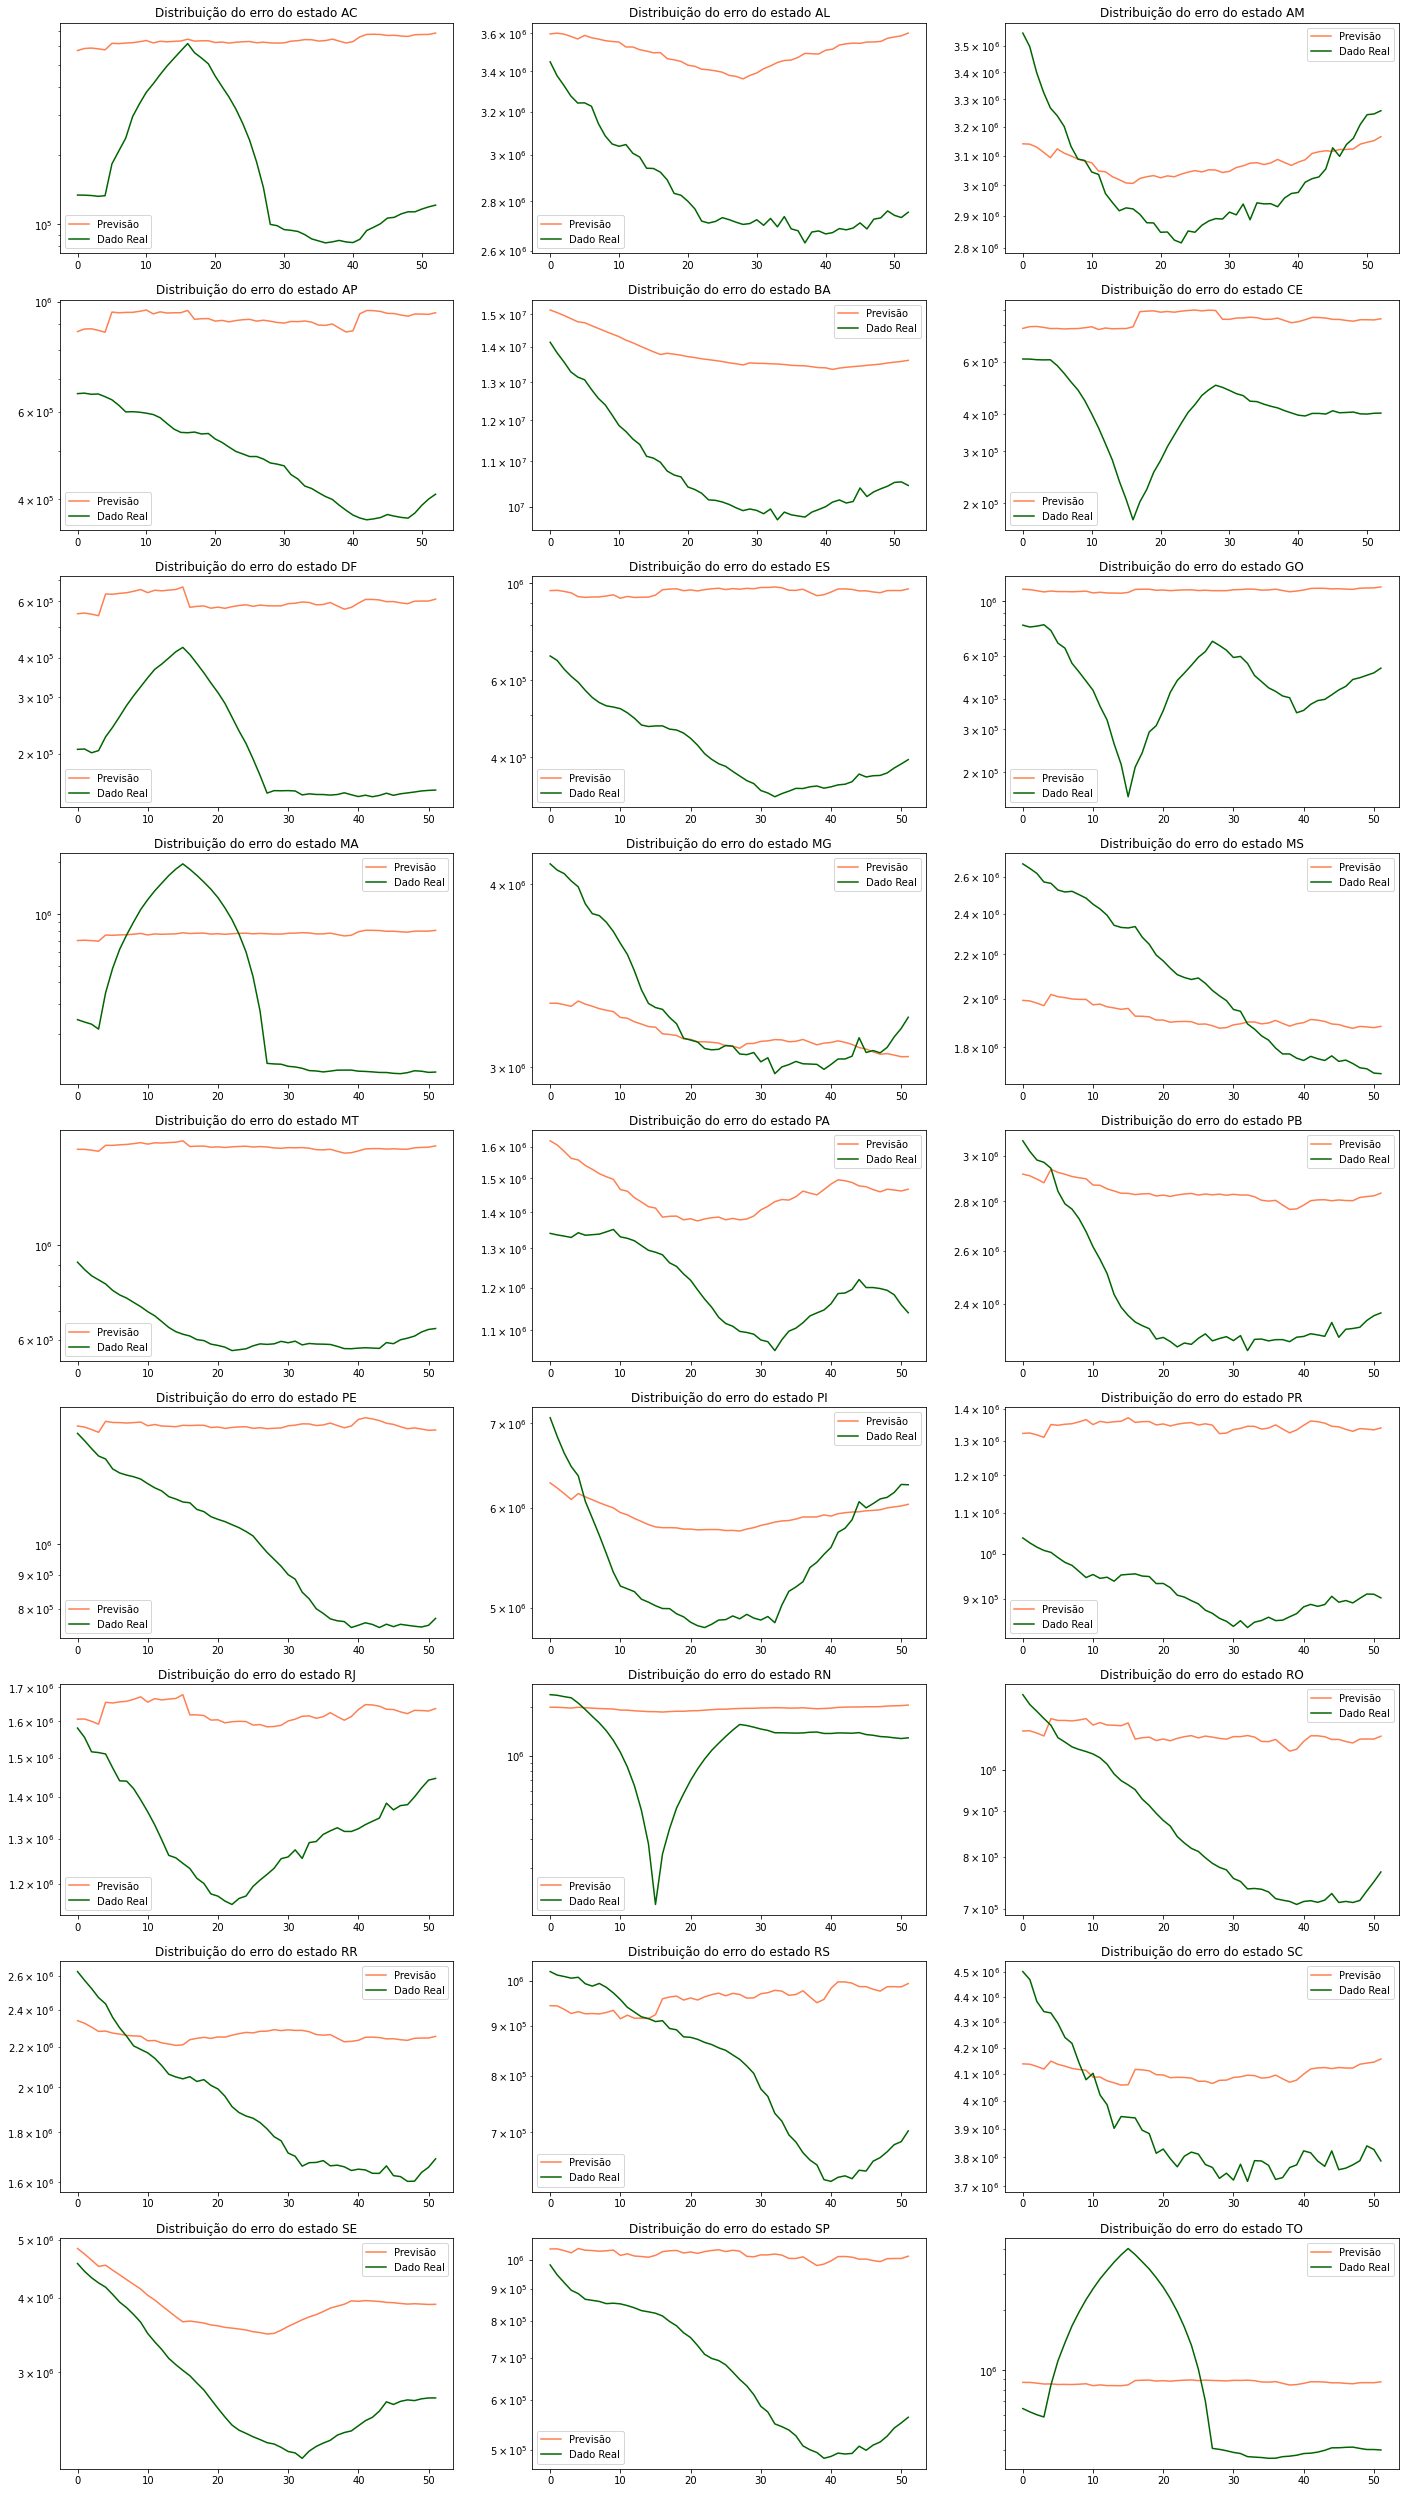

In [ ]:
show_predictions_graphs(y_pred_state, y_test_state)

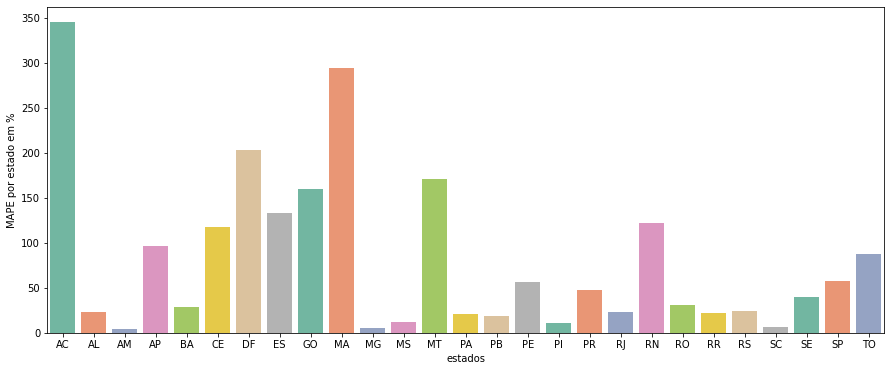

In [ ]:
show_error_state(y_pred_state, y_test_state)

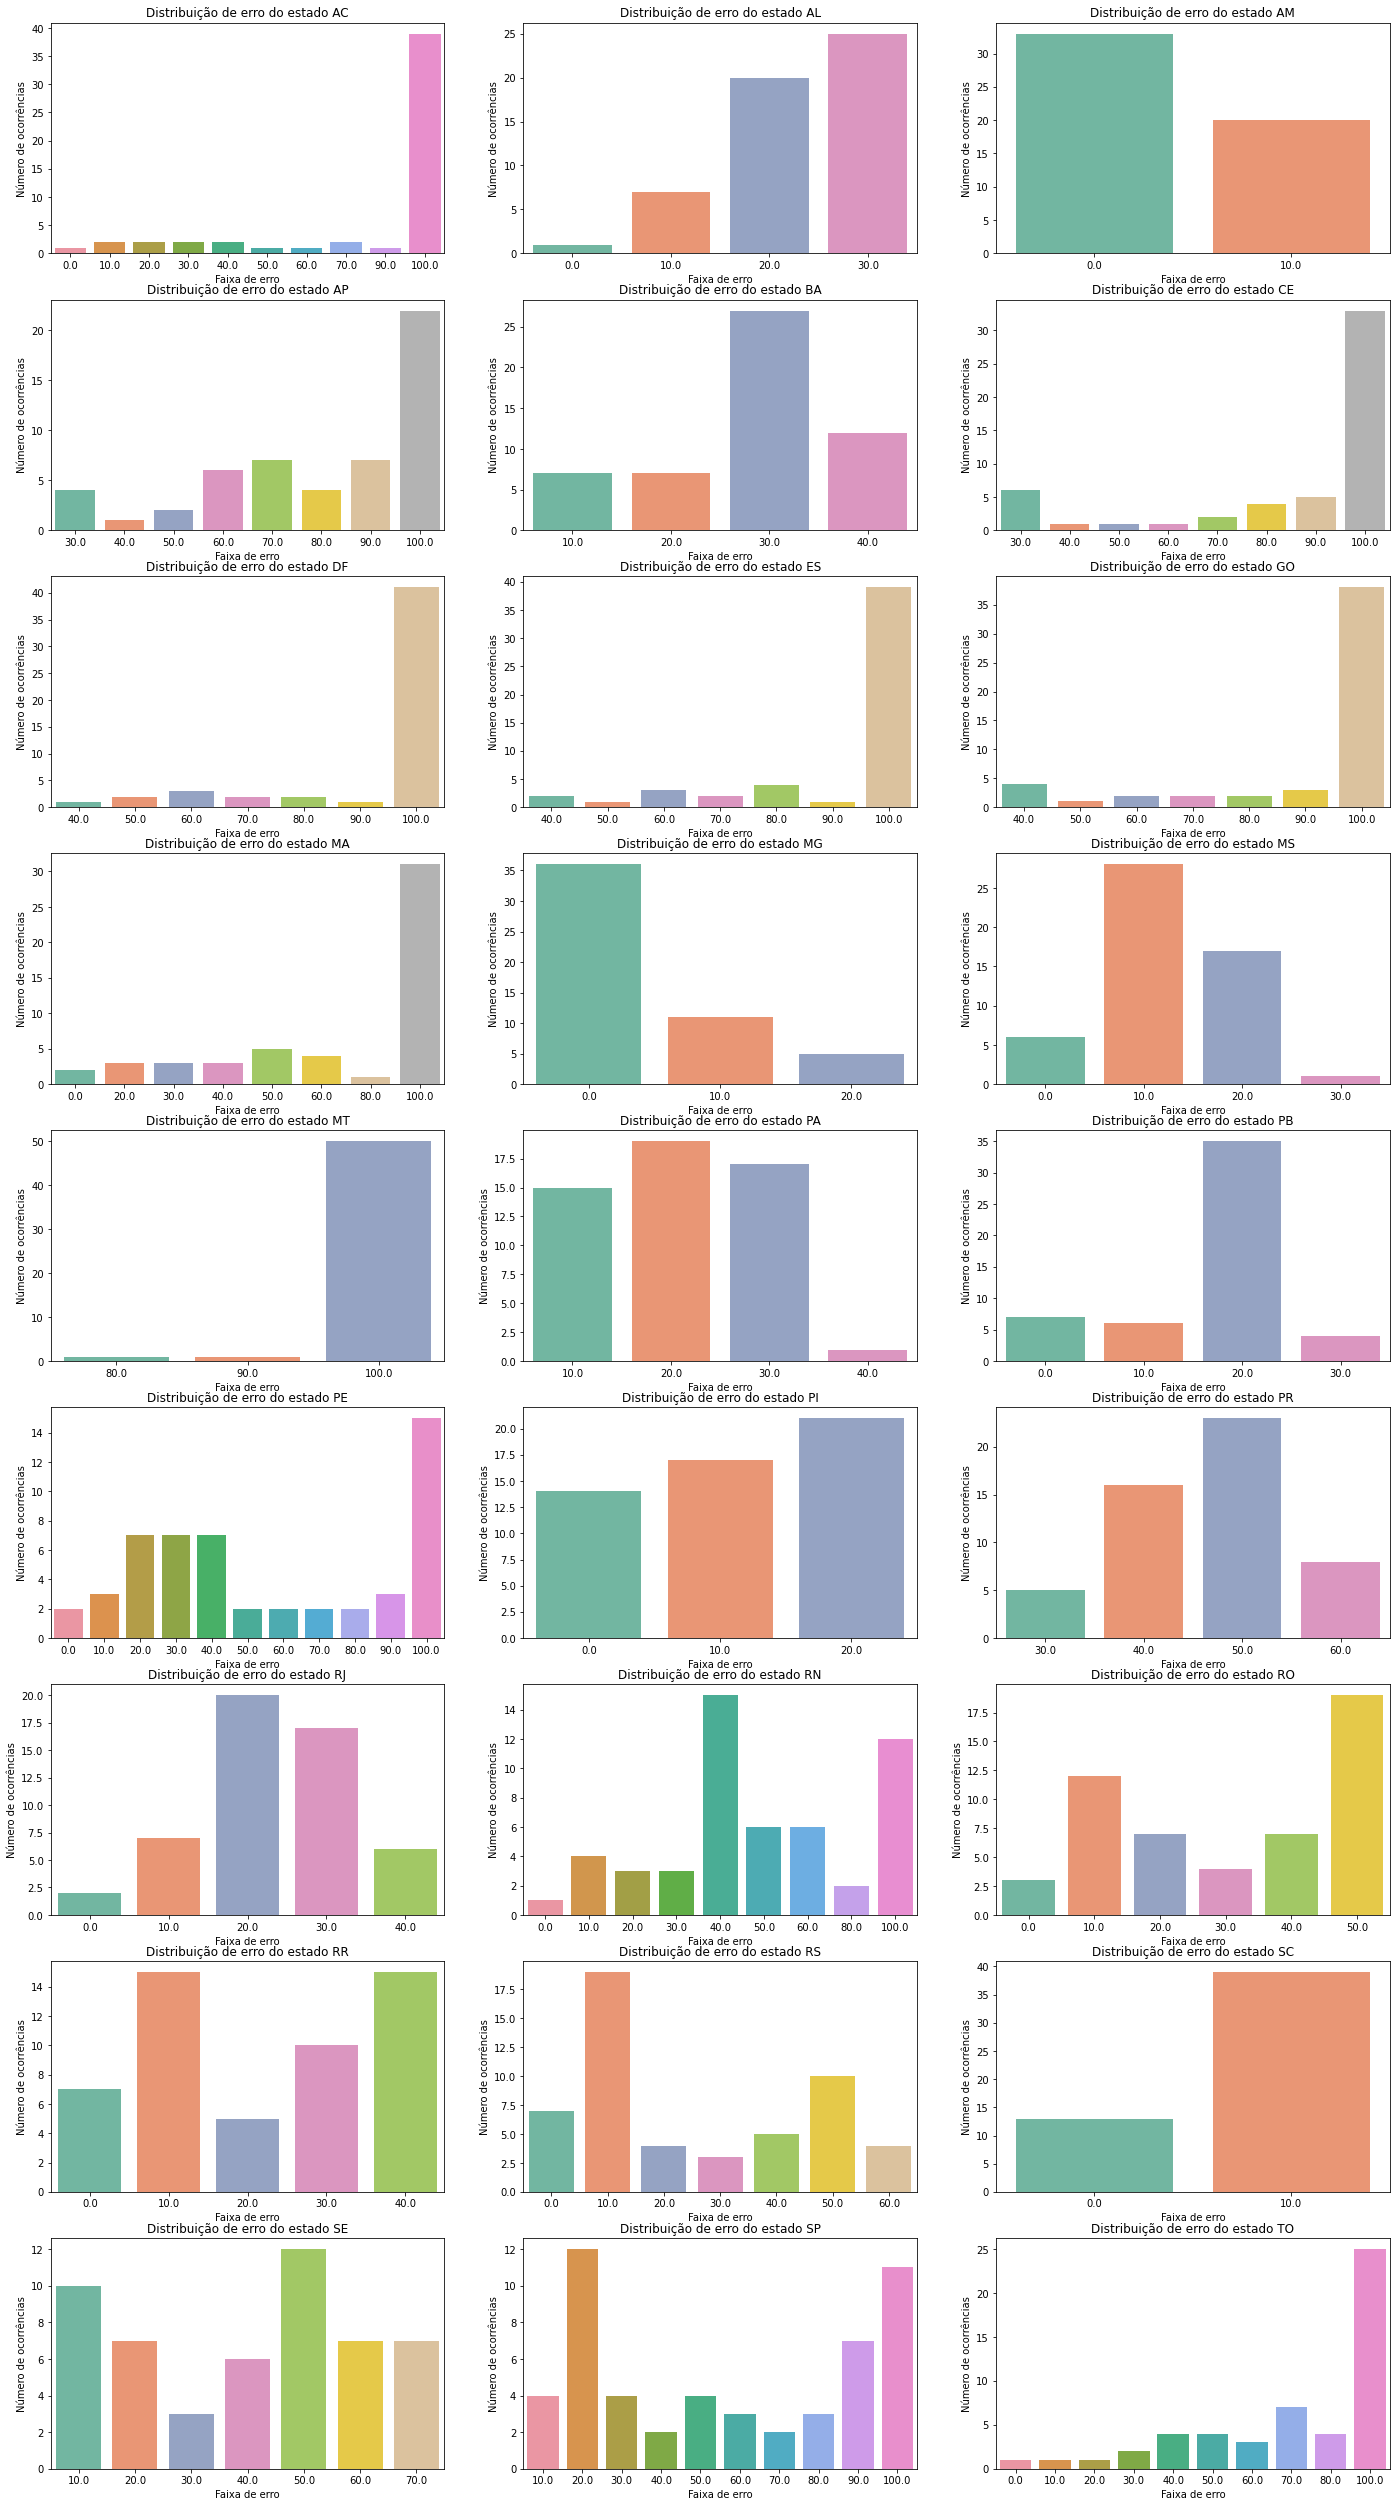

In [ ]:
show_error_graphs(y_pred_state, y_test_state)

## Normalizando os dados 

### Normalização com Standard Scaler

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")['consumo']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.8832809968502436


In [ ]:
# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 835990.8938087379
MAE: 532237.6985151425
MAPE: 0.6701588753917076


In [ ]:
y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)

In [ ]:
pd.Series(regr.coef_, x.columns).sort_values().to_frame(
    name="coef"
).style.background_gradient(cmap="Greens")

#### Gráficos

In [ ]:
df_error["MUCE_SS"] = print_error(y_pred_state, y_test_state)

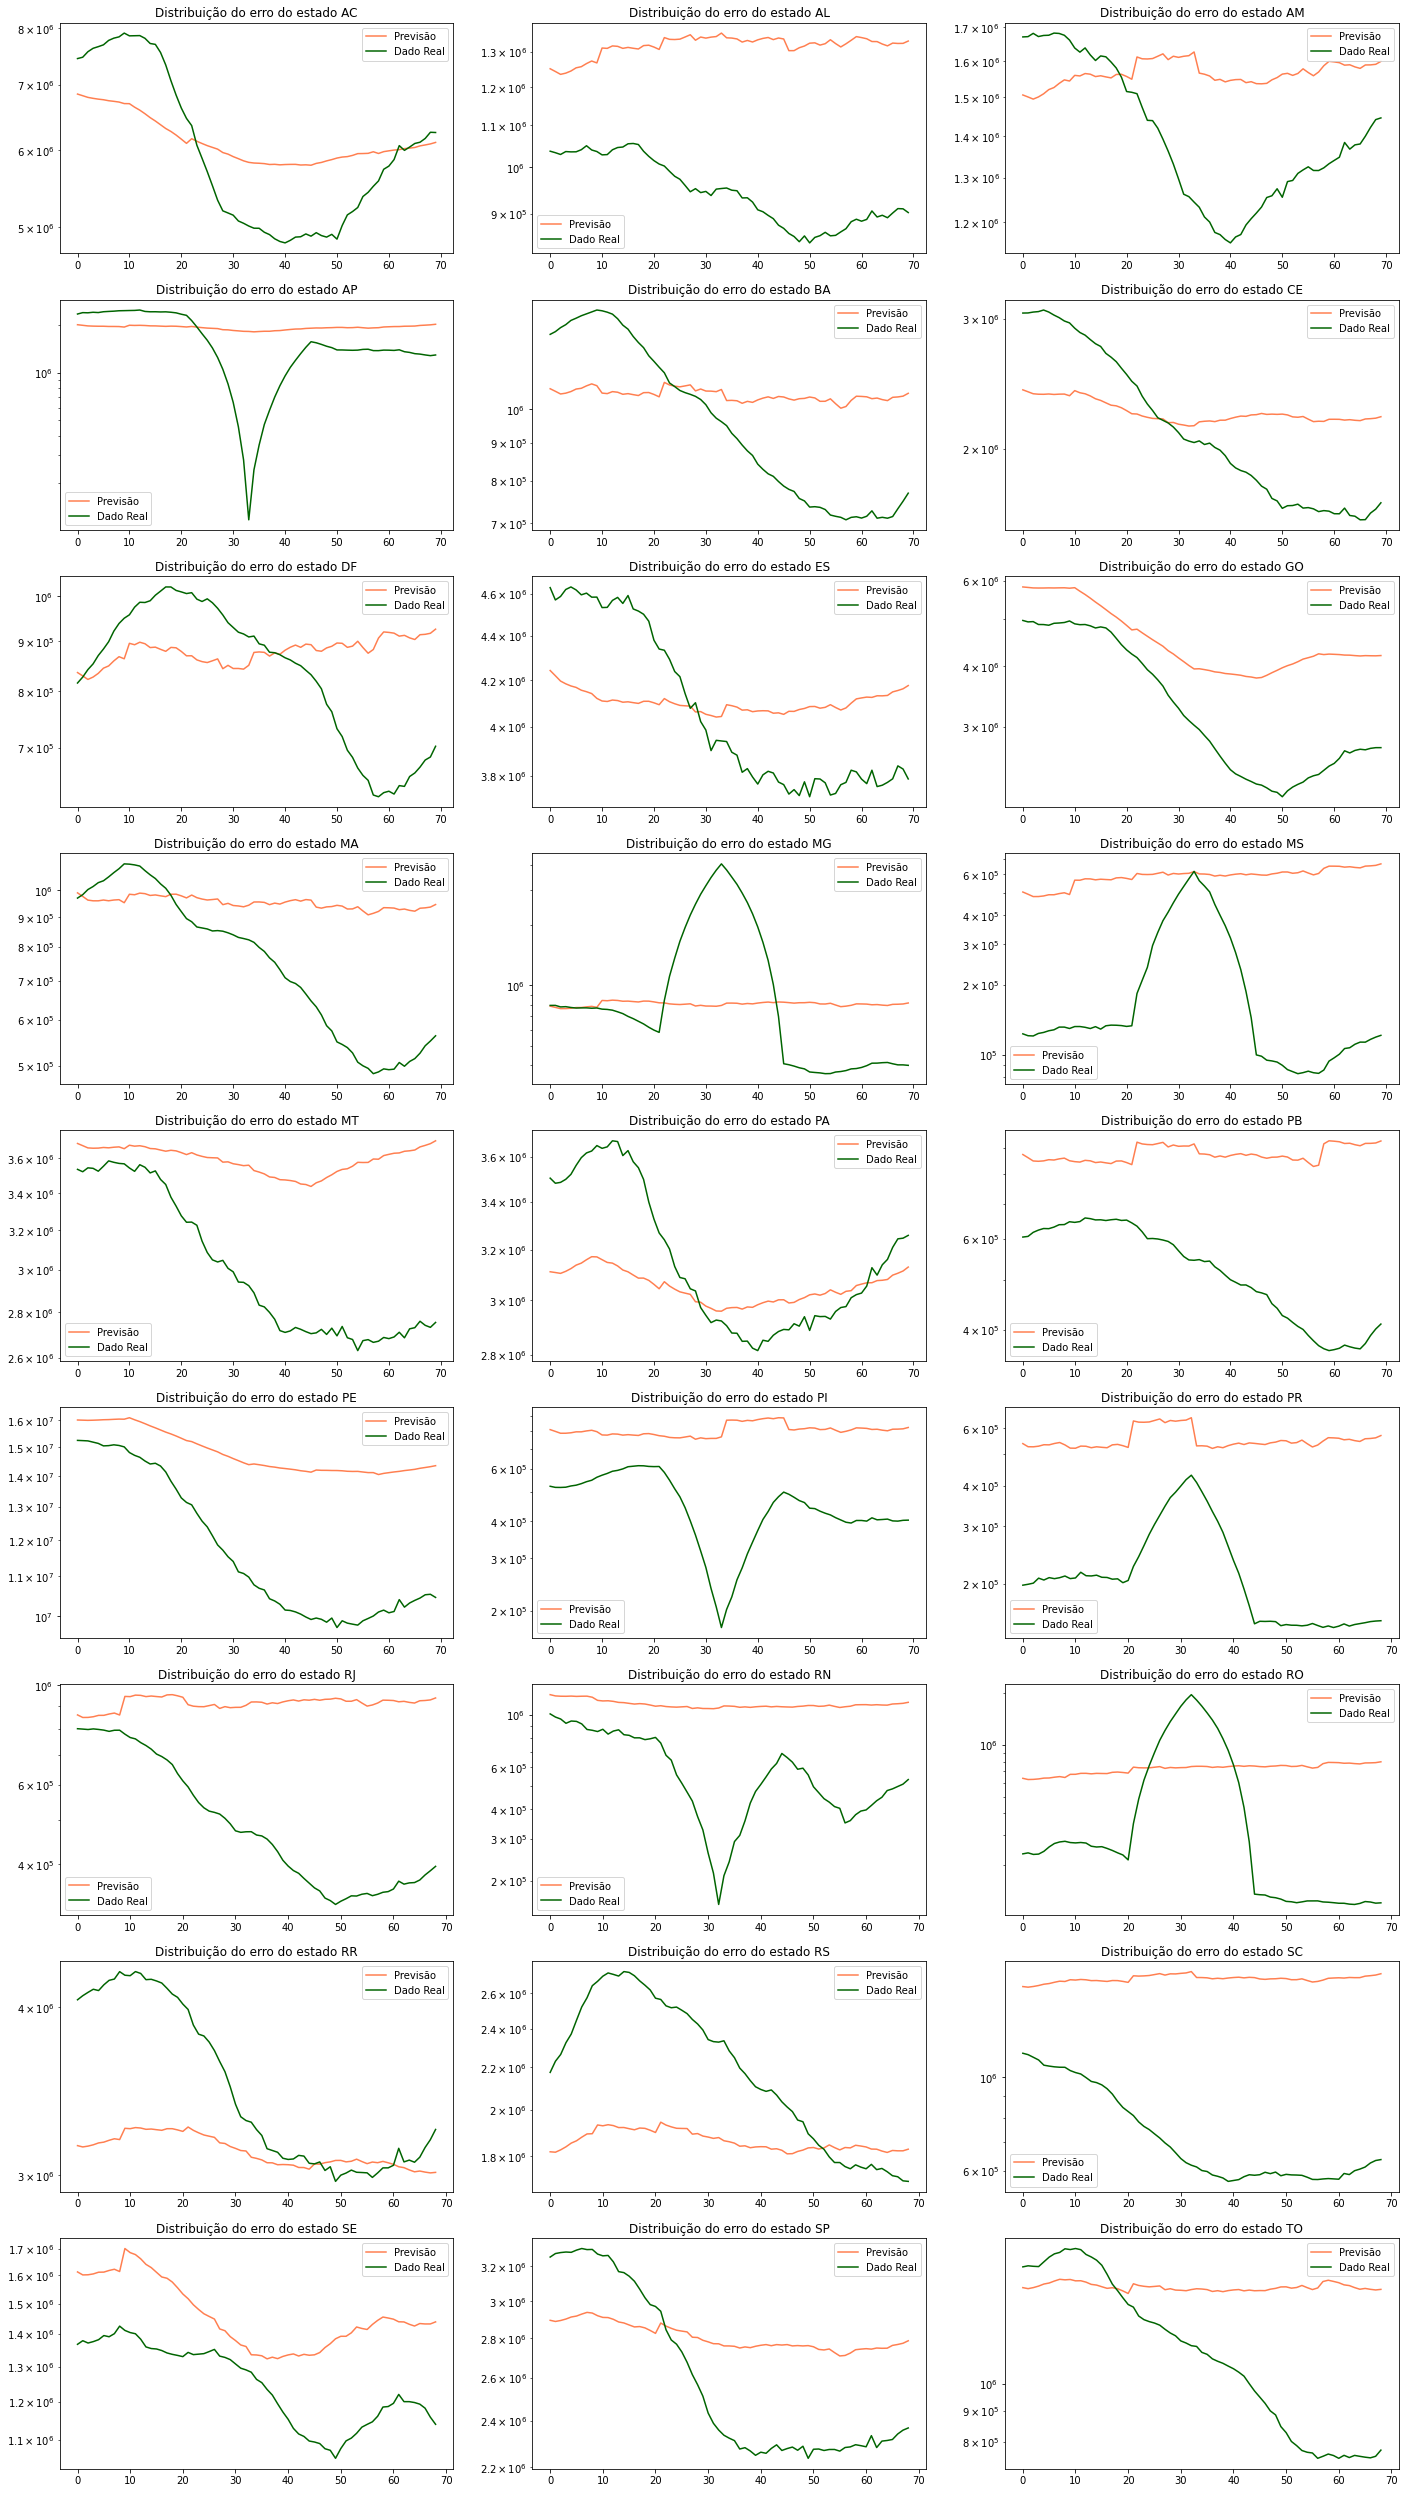

In [ ]:
show_predictions_graphs(y_pred_state, y_test_state)

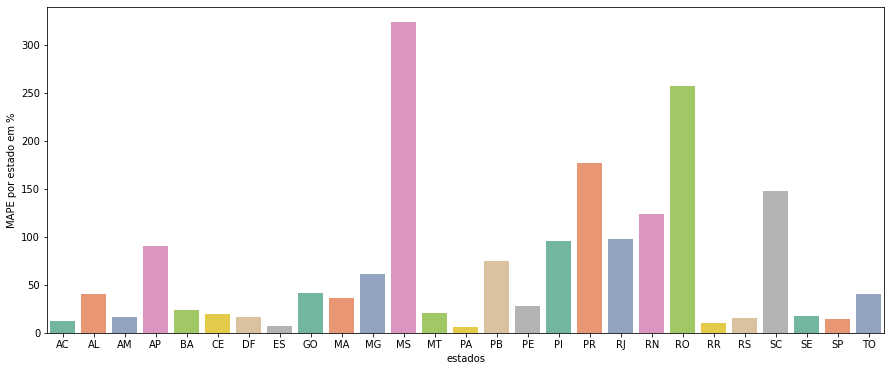

In [ ]:
show_error_state(y_pred_state, y_test_state)

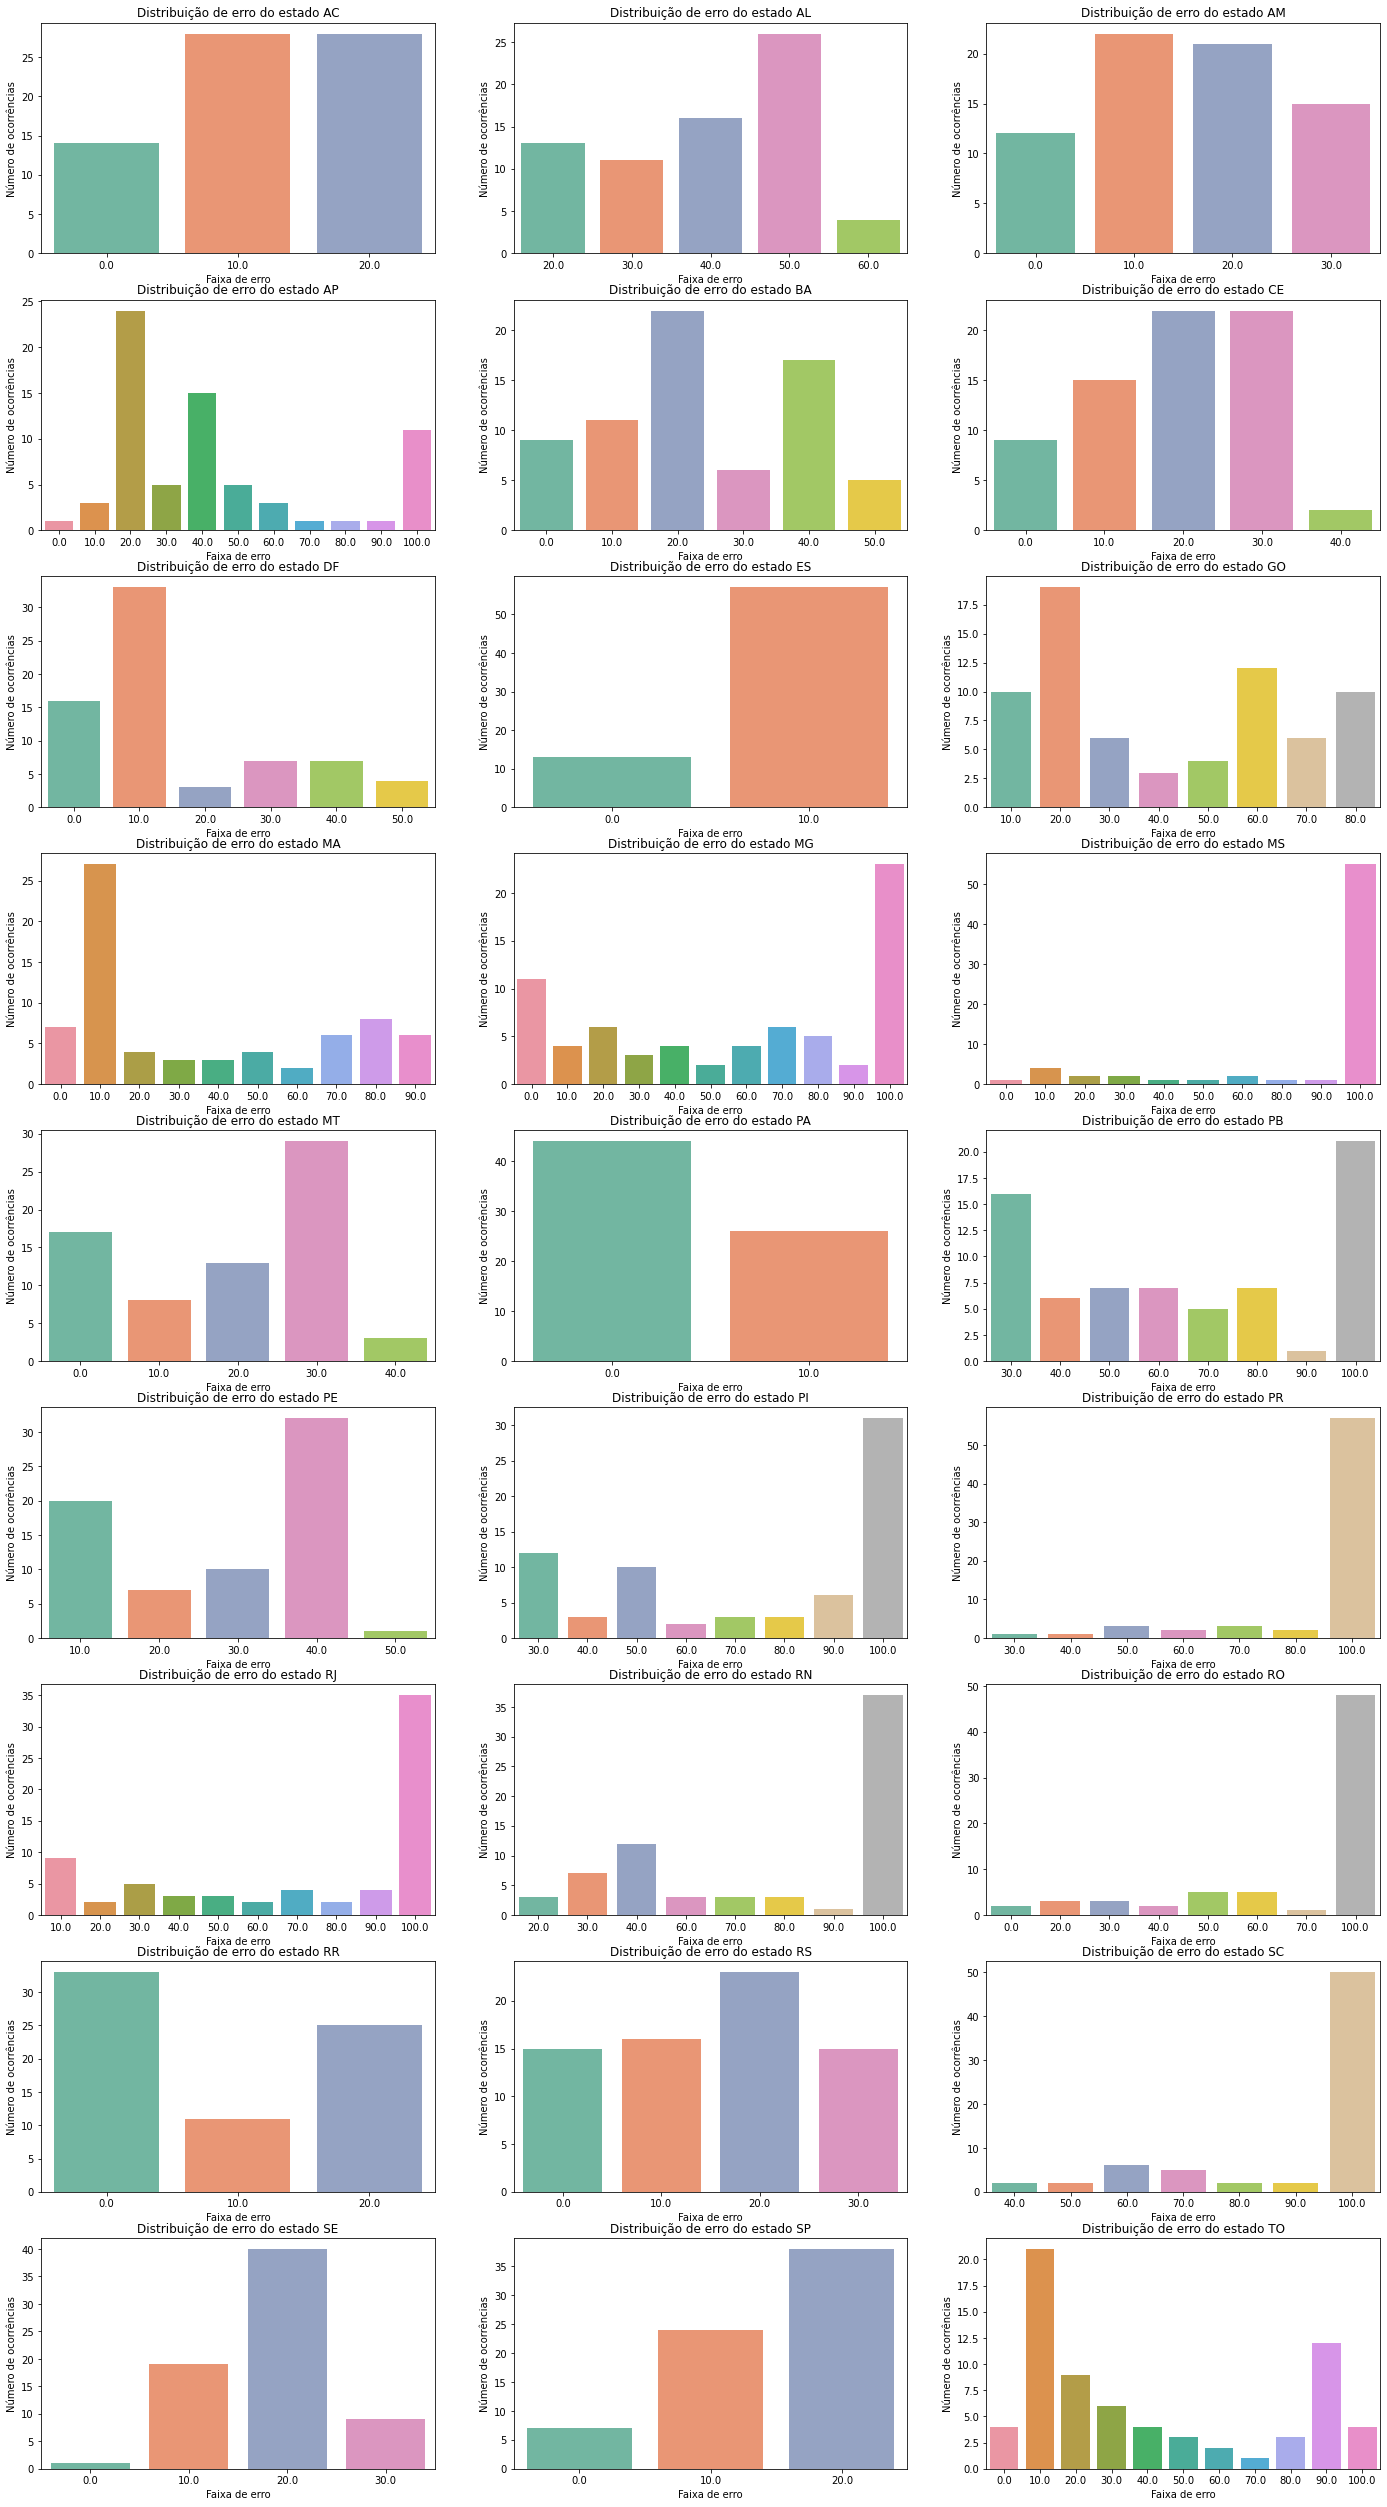

In [ ]:
show_error_graphs(y_pred_state, y_test_state)

### MinMax

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")['consumo']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.8633707902792134


In [ ]:
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 821444.8630938067
MAE: 562083.2912963482
MAPE: 0.8010375936536166


In [ ]:
y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)

In [ ]:
pd.Series(regr.coef_, x.columns).sort_values().to_frame(
    name="coef"
).style.background_gradient(cmap="Greens")

In [ ]:
df_error["MUCE_MM"] = print_error(y_pred_state, y_test_state)

#### Gráficos

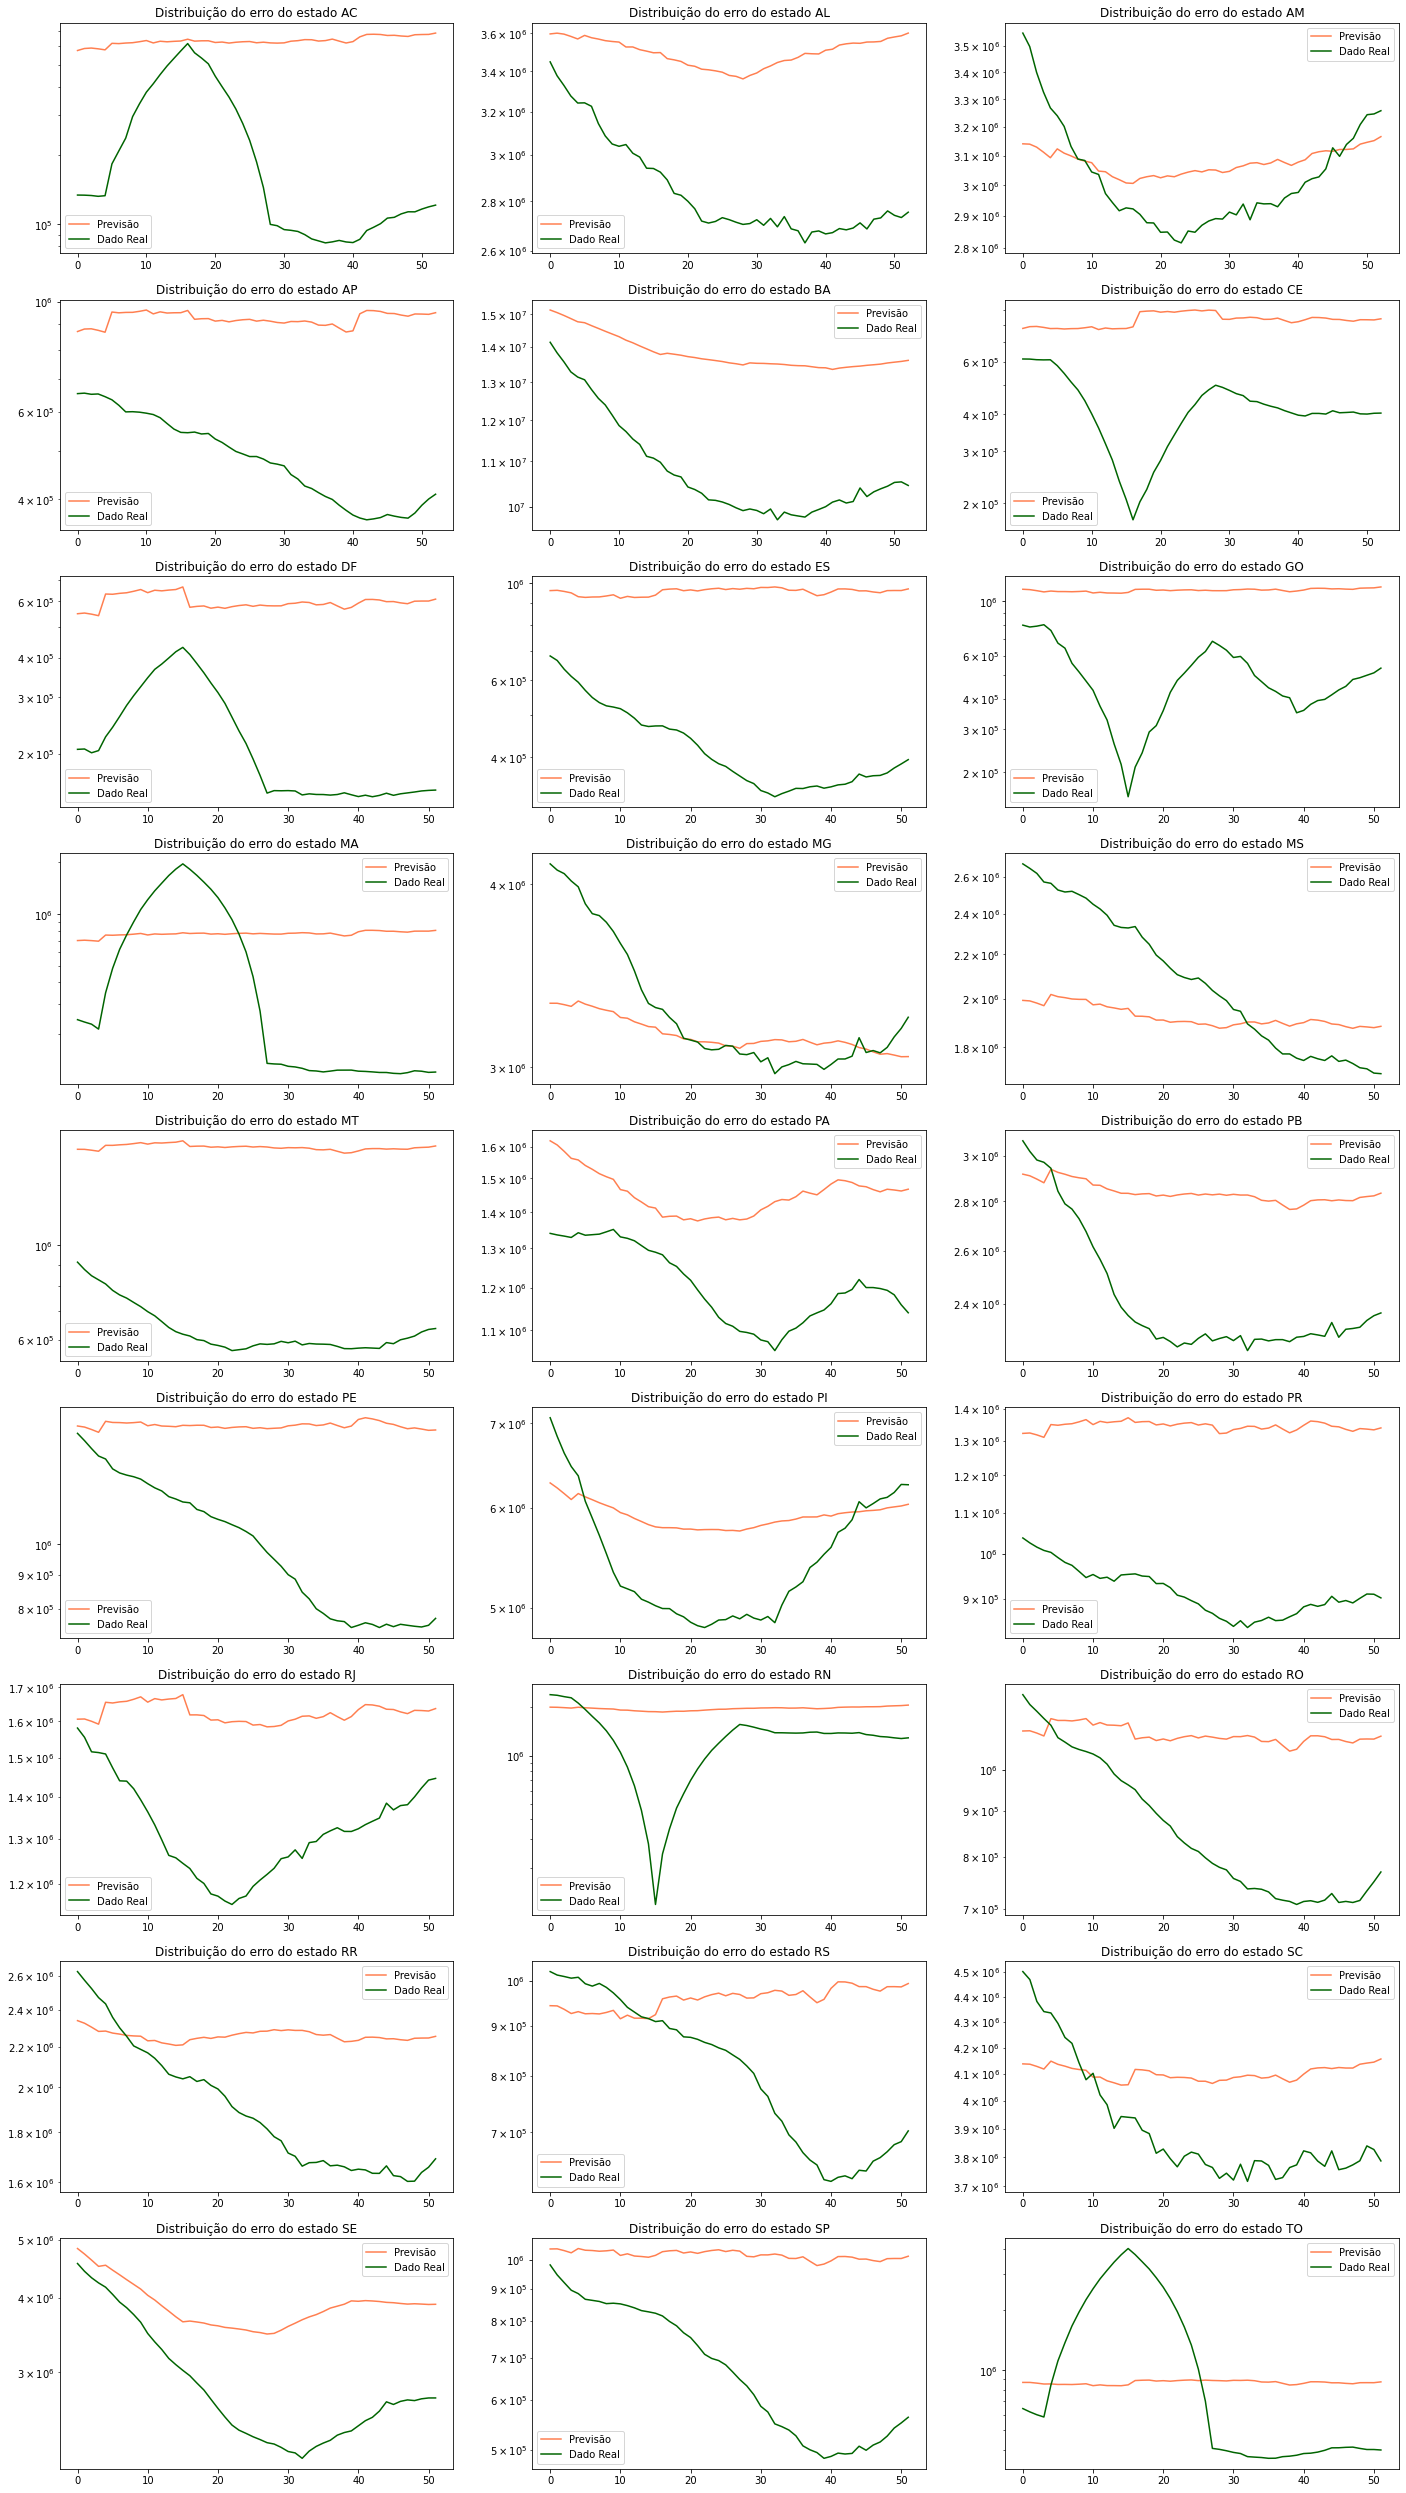

In [ ]:
show_predictions_graphs(y_pred_state, y_test_state)

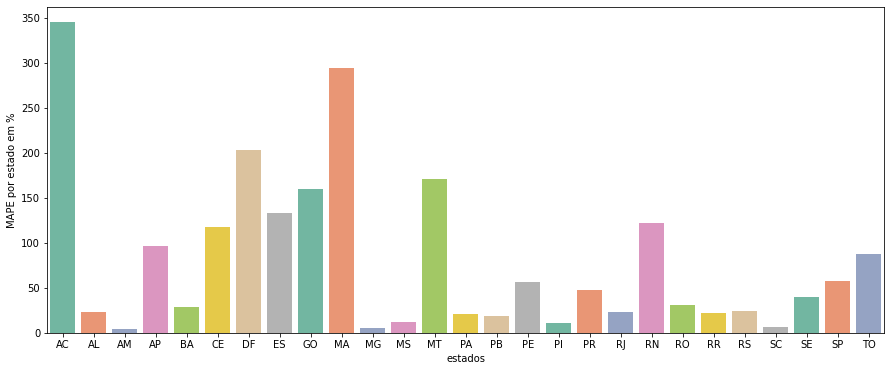

In [ ]:
show_error_state(y_pred_state, y_test_state)

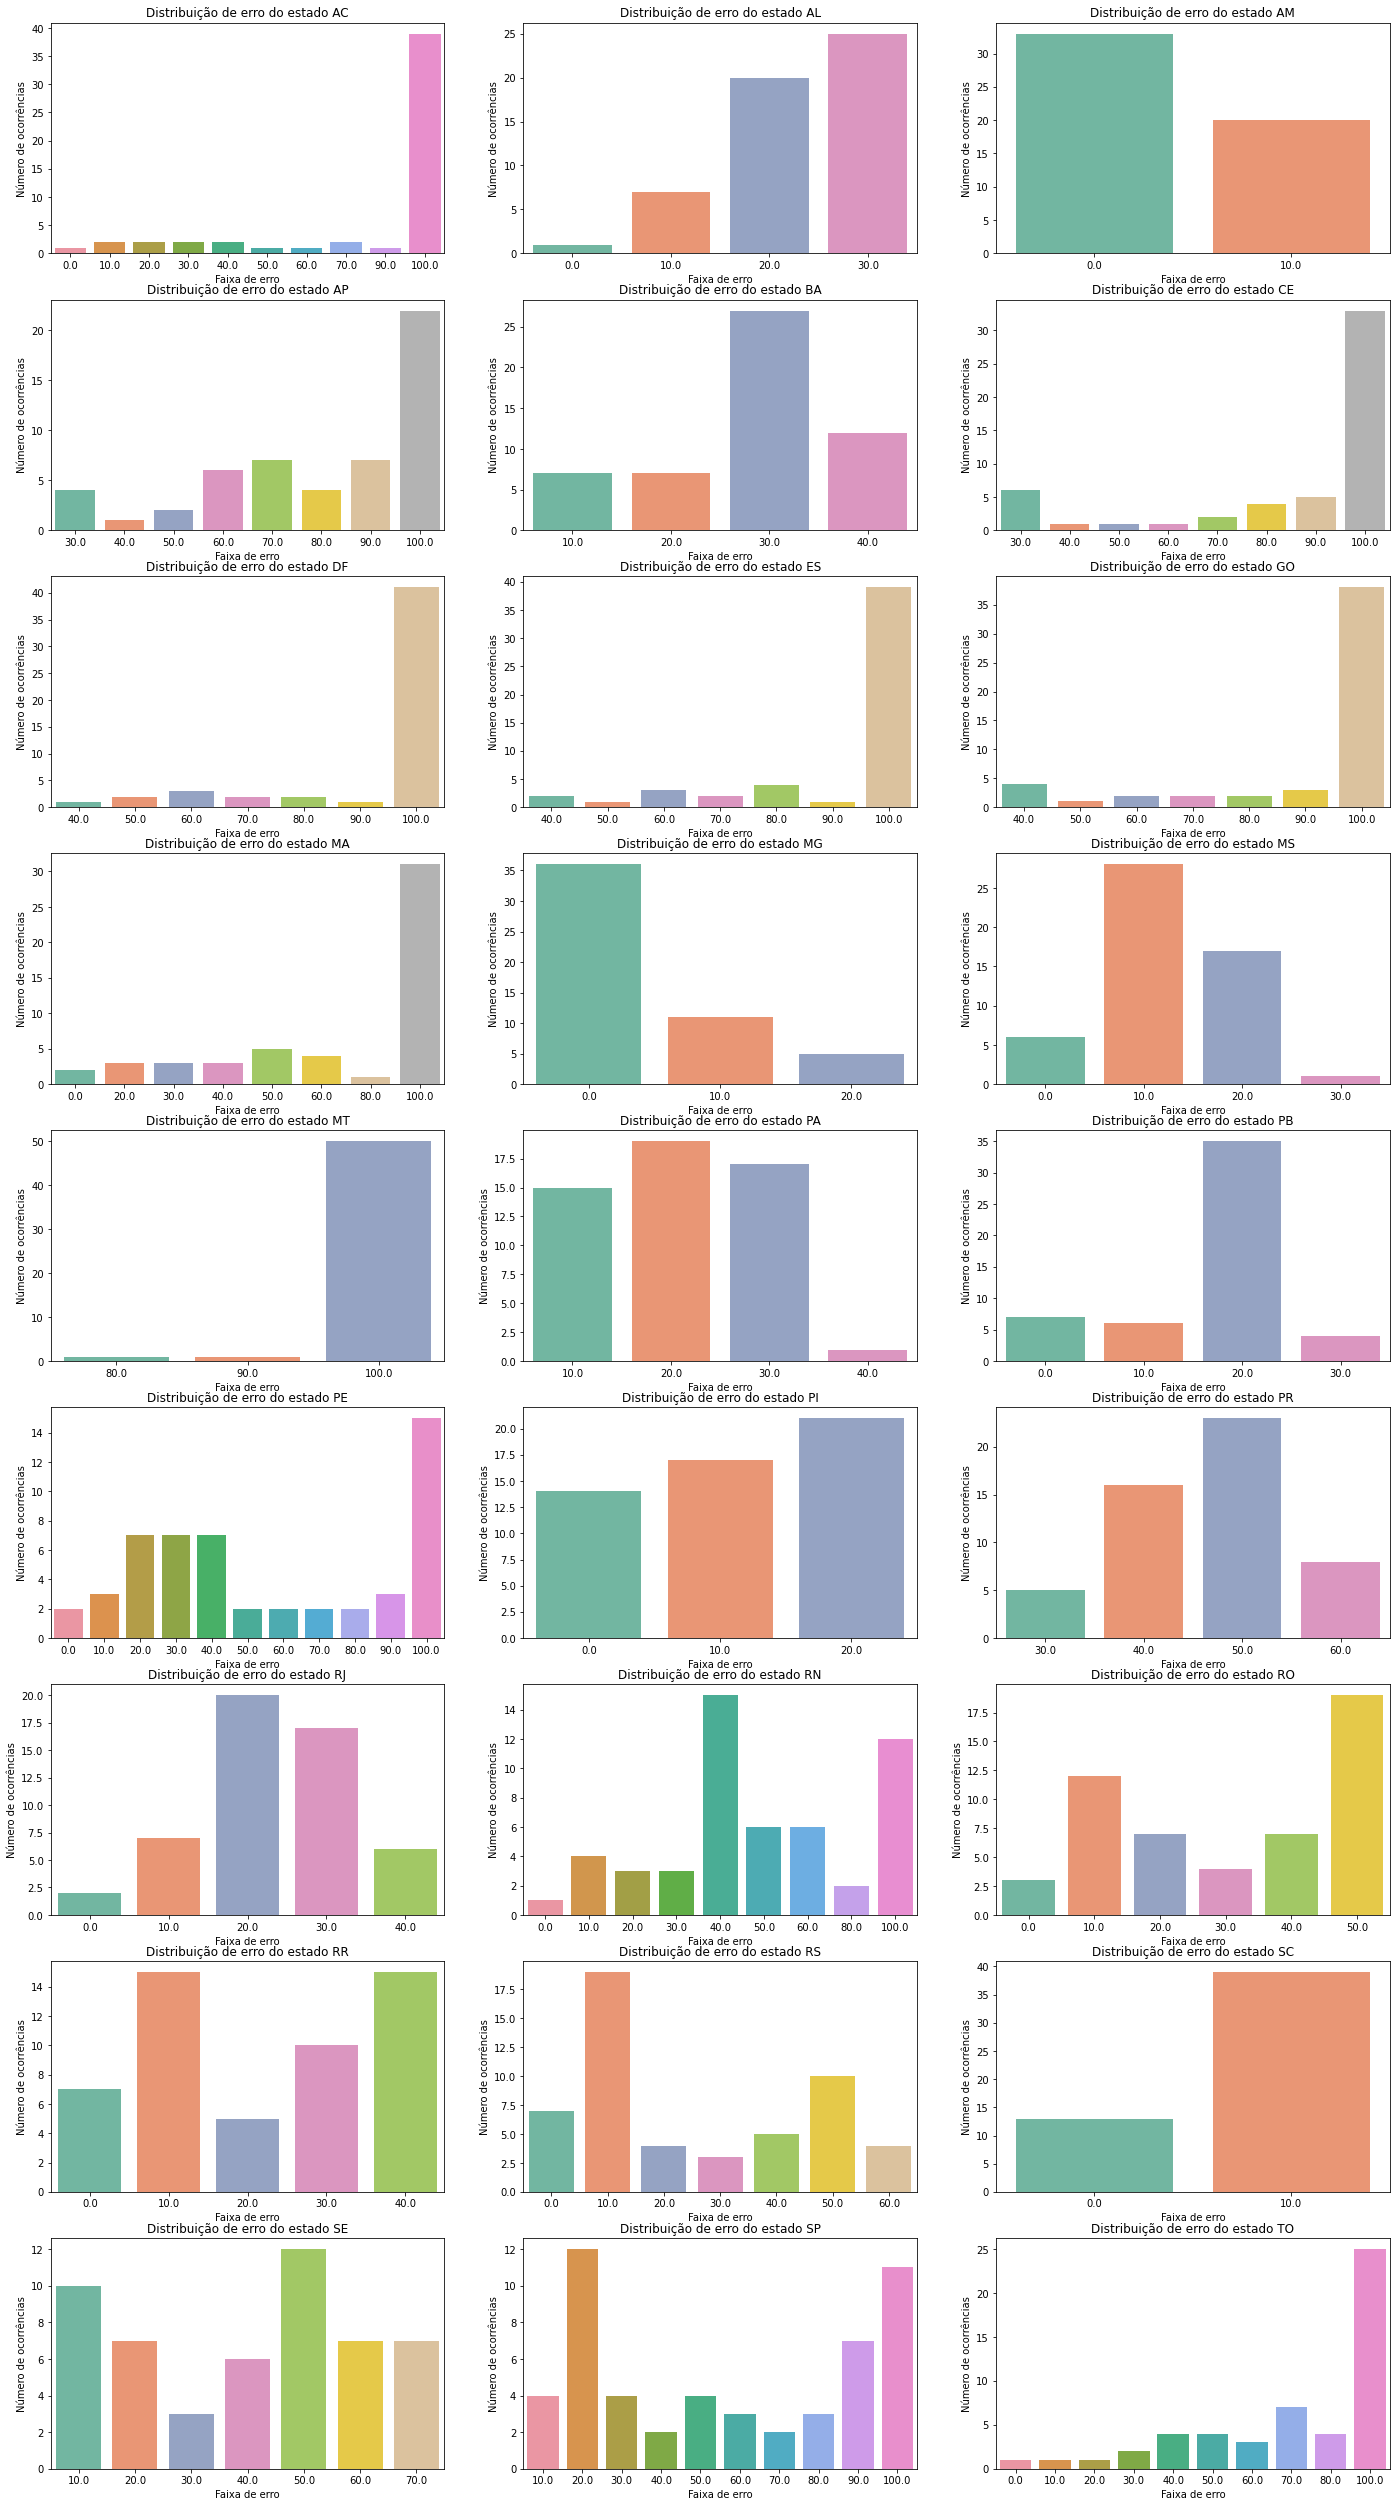

In [ ]:
show_error_graphs(y_pred_state, y_test_state)

### Power Transform

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")['consumo']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.8277070292740302


In [ ]:
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 922444.8691951182
MAE: 703952.4584120617
MAPE: 0.8511326474542129


In [ ]:
y_test_state = split_y_state(y_test)
y_pred_state = split_y_state(y_pred)

In [ ]:
pd.Series(regr.coef_, x.columns).sort_values().to_frame(
    name="coef"
).style.background_gradient(cmap="Greens")

In [ ]:
df_error["MUCE_PT"] = print_error(y_pred_state, y_test_state)

#### Gráficos

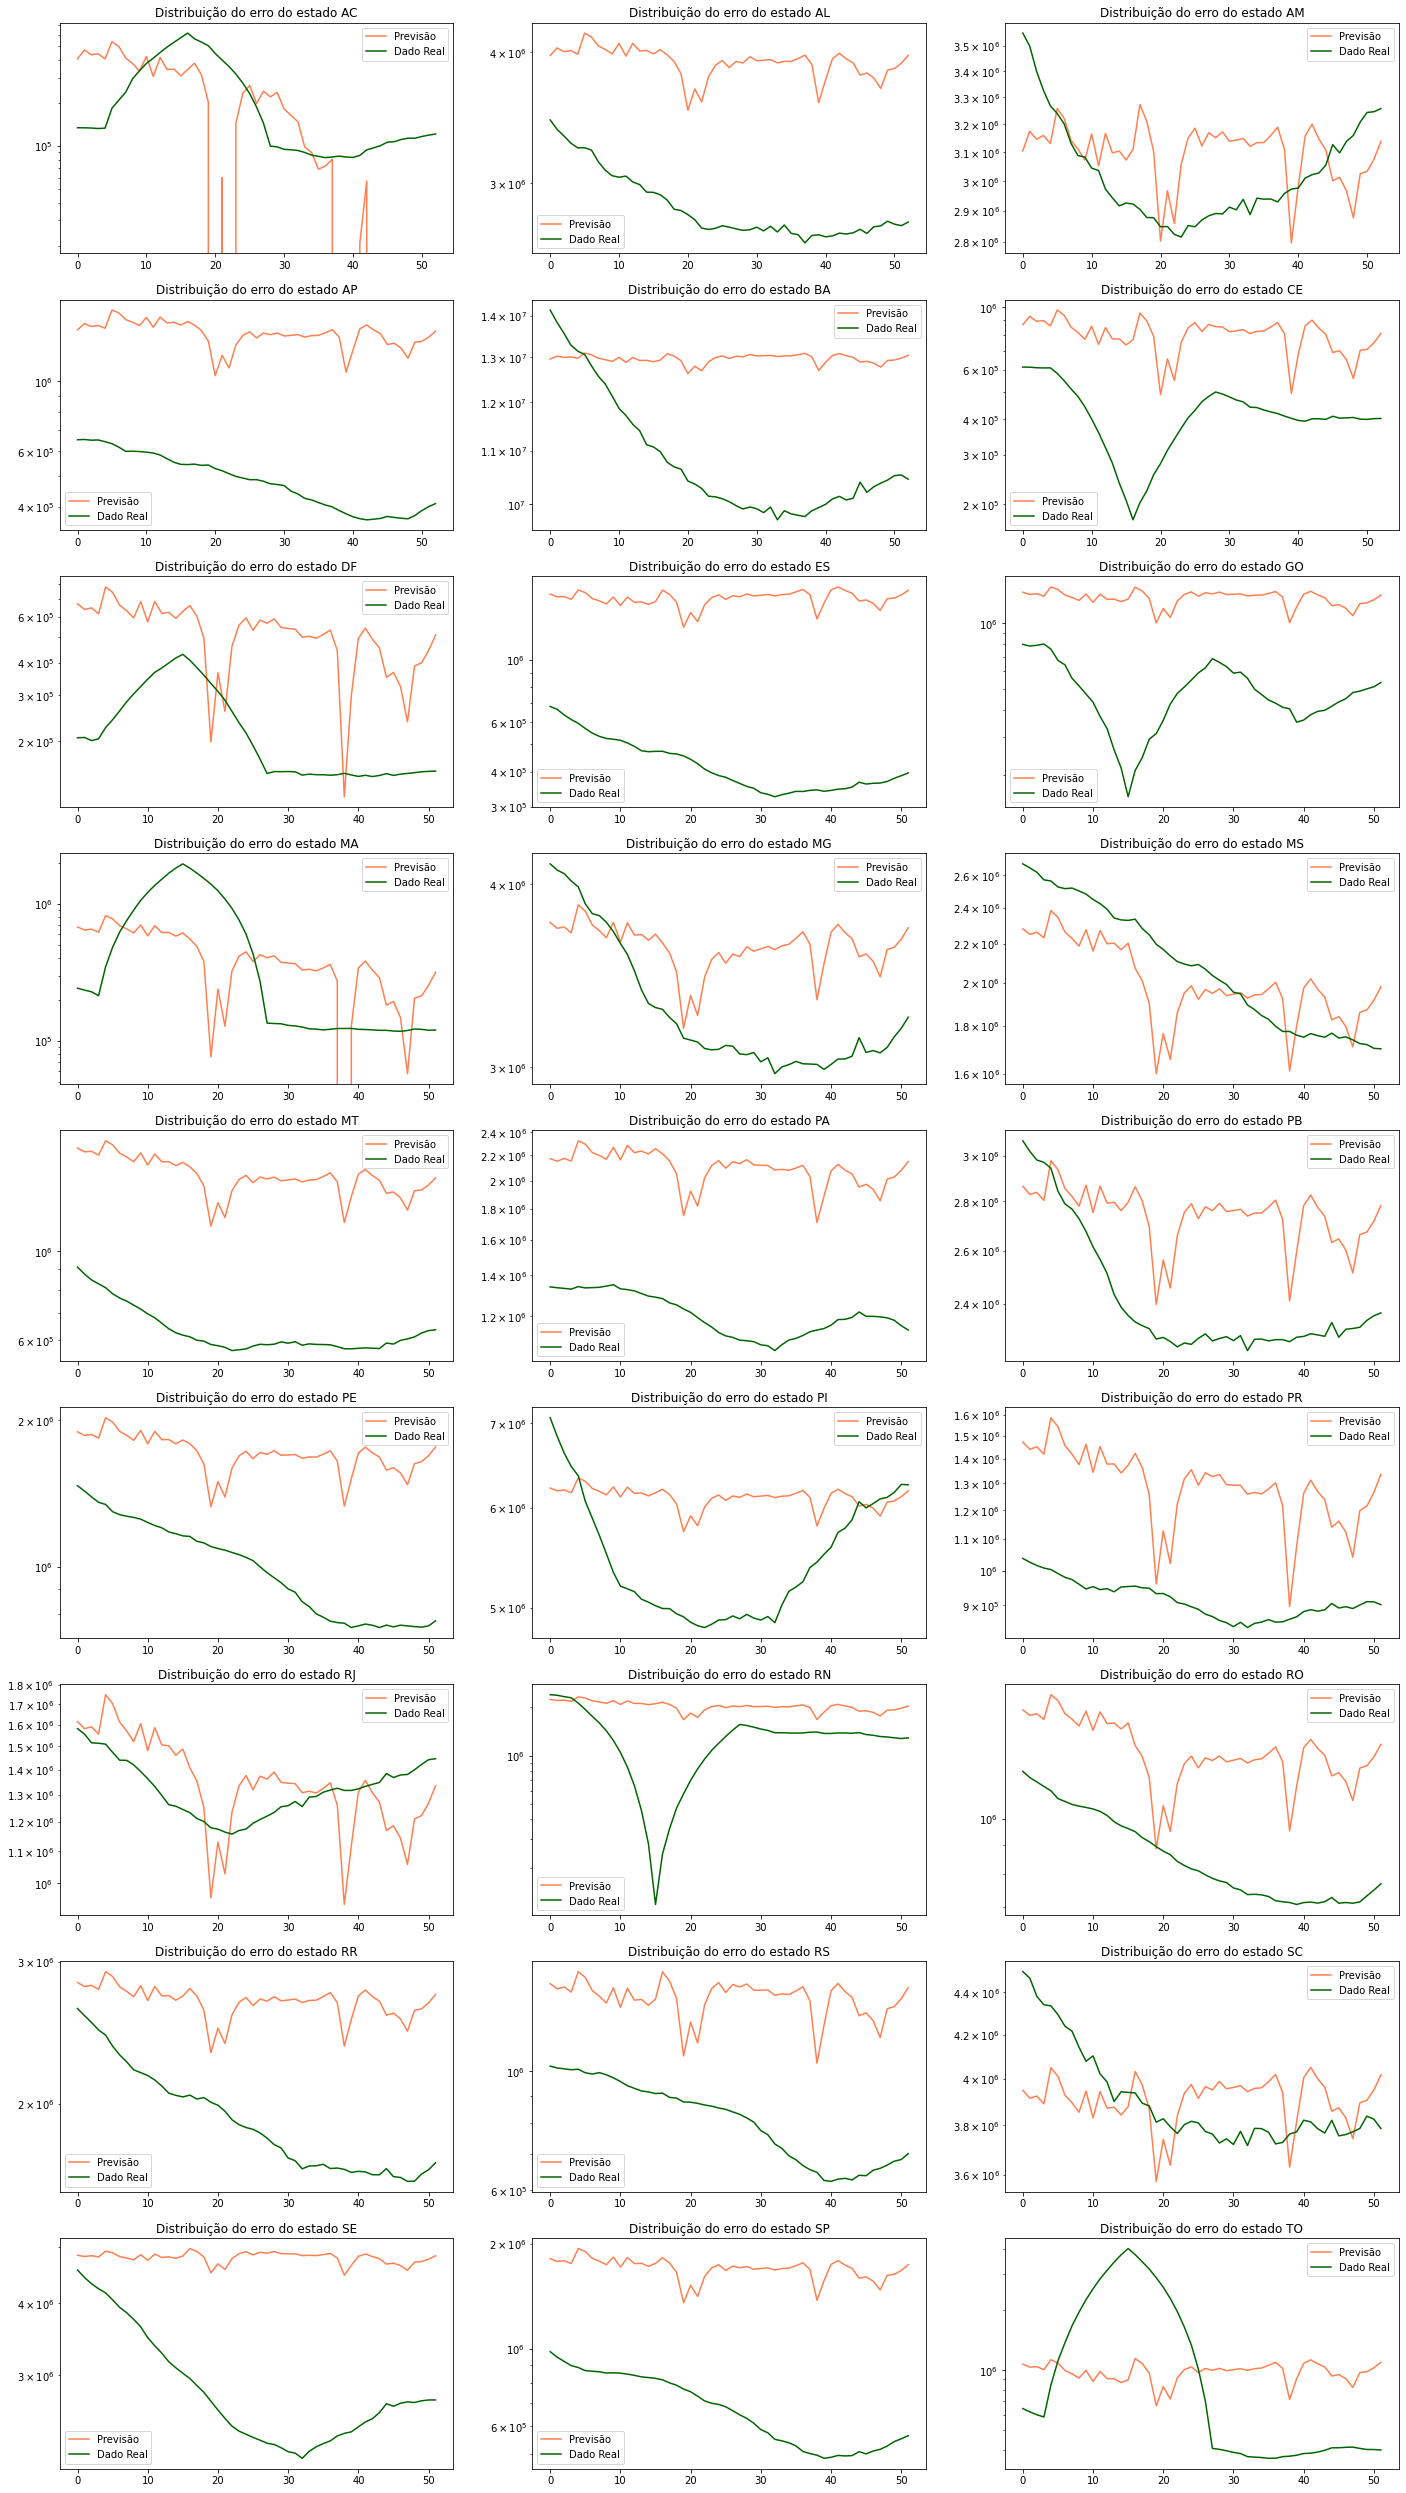

In [ ]:
show_predictions_graphs(y_pred_state, y_test_state)

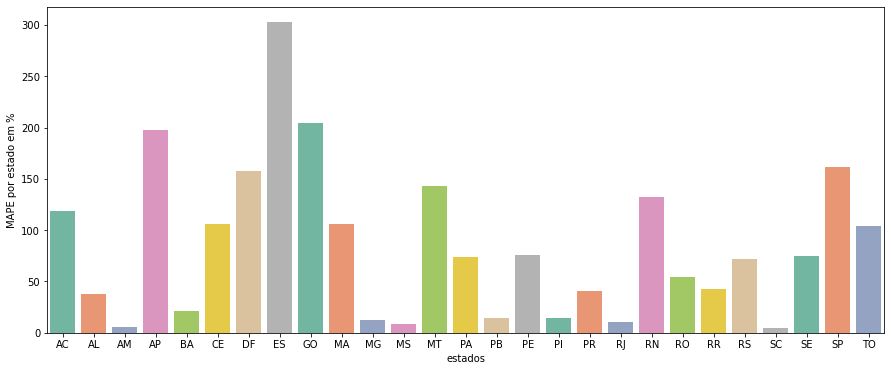

In [ ]:
show_error_state(y_pred_state, y_test_state)

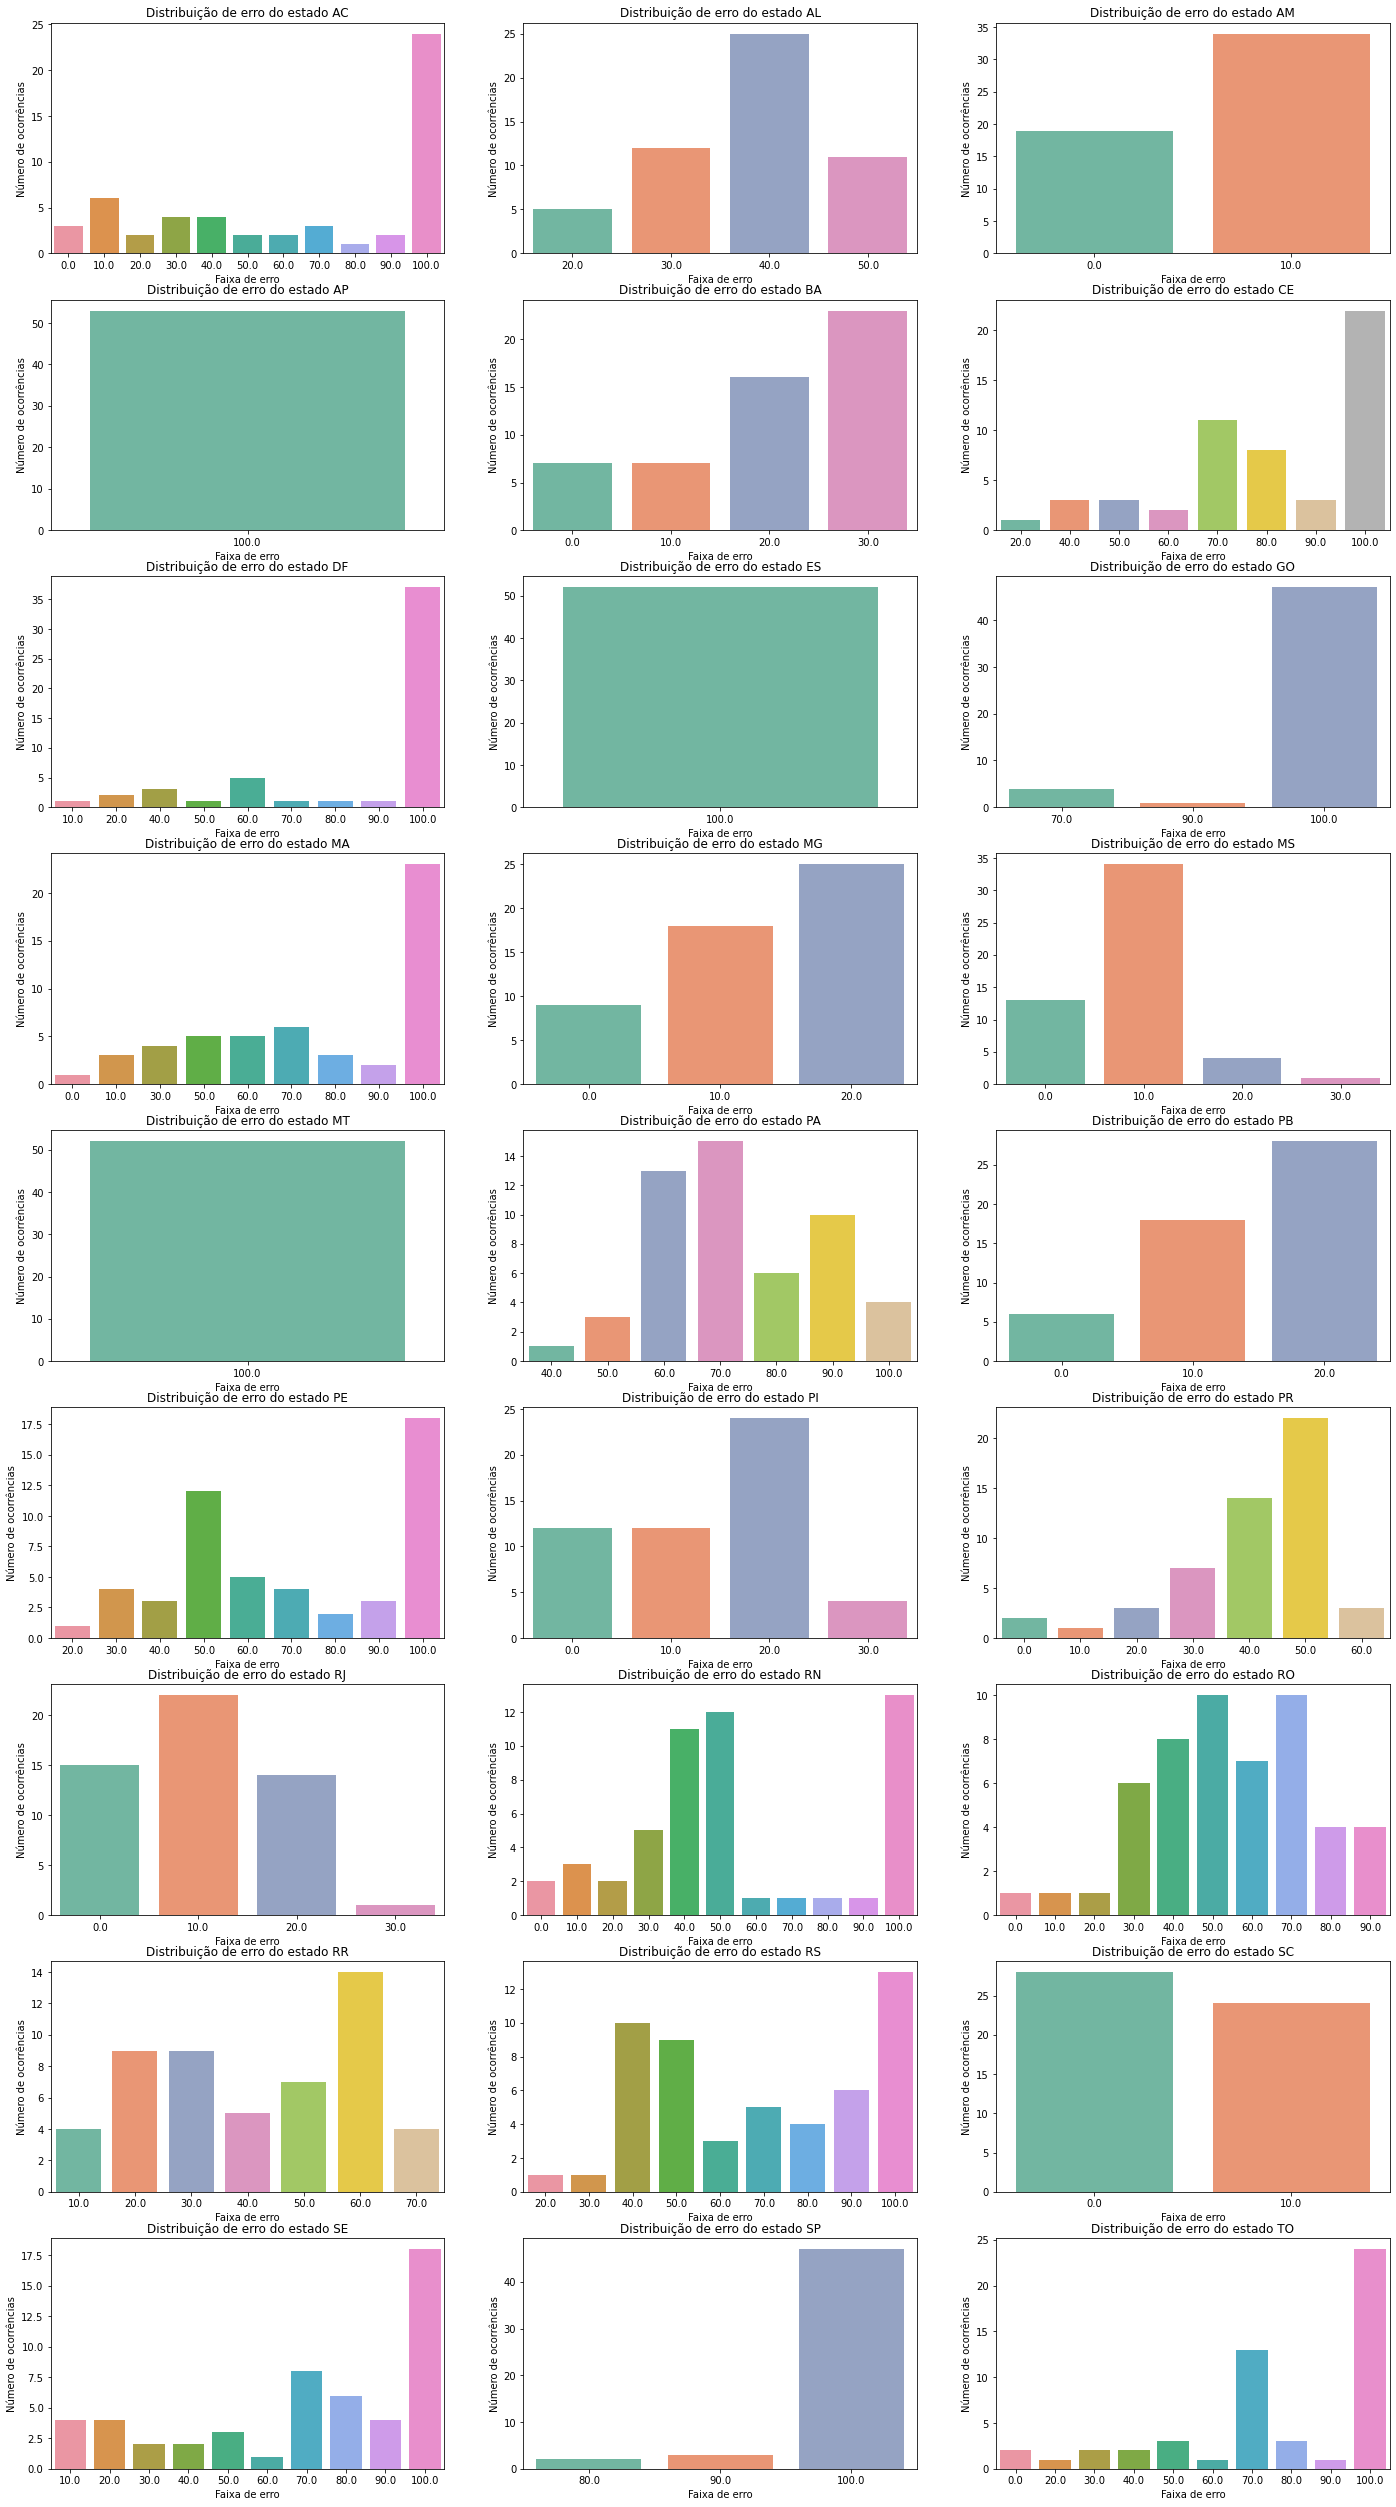

In [ ]:
show_error_graphs(y_pred_state, y_test_state)

# Modelo para cada estado

## Sem normalizar os dados

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

### 85% treino e 15% teste

In [ ]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

    print(f"[{SIGLAS[i]}]: Score de treino: ")
    scores = score_regression_metrics(y_train, regr.predict(x_train))
    show_scores(scores)

    print(f"\n[{SIGLAS[i]}]: Score de teste: ")
    scores = score_regression_metrics(y_test, pred[i])
    show_scores(scores)

    print("----------------------------------")

[AC]: Score: -0.750992500238366
[AC]: Score de treino: 
Scores obtidos:
RMSE: 9520.115588400633
MAE: 7926.365280722085
MAPE: 0.1600125294739592

[AC]: Score de teste: 
Scores obtidos:
RMSE: 120175.05652123204
MAE: 77271.85133939603
MAPE: 0.25298952294101784
----------------------------------
[AL]: Score: -14.056420567314474
[AL]: Score de treino: 
Scores obtidos:
RMSE: 26177.511191812846
MAE: 20716.274139586752
MAPE: 0.05891222875688895

[AL]: Score de teste: 
Scores obtidos:
RMSE: 394014.2033292702
MAE: 362859.25605421874
MAPE: 0.9312867950458714
----------------------------------
[AM]: Score: -1.382839057592474
[AM]: Score de treino: 
Scores obtidos:
RMSE: 49442.38052550372
MAE: 39238.65169200147
MAPE: 0.10383552223453488

[AM]: Score de teste: 
Scores obtidos:
RMSE: 247952.55560506074
MAE: 199315.1735021909
MAPE: 0.5765232490916498
----------------------------------
[AP]: Score: -0.2908057682974141
[AP]: Score de treino: 
Scores obtidos:
RMSE: 9832.613621561932
MAE: 6864.52771360042

### 80% treino e 20% teste

In [ ]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.2, shuffle=False)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

    print(f"[{SIGLAS[i]}]: Score de treino: ")
    scores = score_regression_metrics(y_train, regr.predict(x_train))
    show_scores(scores)

    print(f"\n[{SIGLAS[i]}]: Score de teste: ")
    scores = score_regression_metrics(y_test, pred[i])
    show_scores(scores)

    print("----------------------------------")

[AC]: Score: -0.5481956815699733
[AC]: Score de treino: 
Scores obtidos:
RMSE: 8988.621828146392
MAE: 7598.872120900673
MAPE: 0.1565605920018896

[AC]: Score de teste: 
Scores obtidos:
RMSE: 98867.1330690905
MAE: 68341.48617760255
MAPE: 0.2651443163047864
----------------------------------
[AL]: Score: -31.837052842371577
[AL]: Score de treino: 
Scores obtidos:
RMSE: 24035.60787332661
MAE: 18895.409147055714
MAPE: 0.05448927147093784

[AL]: Score de teste: 
Scores obtidos:
RMSE: 982505.6797936562
MAE: 817242.959317069
MAPE: 2.076156883511148
----------------------------------
[AM]: Score: -7.750818419173729
[AM]: Score de treino: 
Scores obtidos:
RMSE: 38609.66182713228
MAE: 31300.290762318364
MAPE: 0.08319892526753311

[AM]: Score de teste: 
Scores obtidos:
RMSE: 670612.6885662212
MAE: 620218.004458028
MAPE: 1.4638029563972839
----------------------------------
[AP]: Score: -0.2646337829487233
[AP]: Score de treino: 
Scores obtidos:
RMSE: 9322.713860901575
MAE: 6424.6255135702995
MAPE

### 70% treino e 30% teste

In [ ]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.3, shuffle=False)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

    print(f"[{SIGLAS[i]}]: Score de treino: ")
    scores = score_regression_metrics(y_train, regr.predict(x_train))
    show_scores(scores)

    print(f"\n[{SIGLAS[i]}]: Score de teste: ")
    scores = score_regression_metrics(y_test, pred[i])
    show_scores(scores)

    print("----------------------------------")

[AC]: Score: -13.404188529263187
[AC]: Score de treino: 
Scores obtidos:
RMSE: 6511.394561086896
MAE: 5230.540036214688
MAPE: 0.11790483269077437

[AC]: Score de teste: 
Scores obtidos:
RMSE: 256836.70471221243
MAE: 215245.58385250033
MAPE: 1.1948994677892246
----------------------------------
[AL]: Score: -57.085196823142056
[AL]: Score de treino: 
Scores obtidos:
RMSE: 21879.66197830722
MAE: 17263.205468230135
MAPE: 0.0527412872521053

[AL]: Score de teste: 
Scores obtidos:
RMSE: 1450730.826892978
MAE: 1087072.2040576318
MAPE: 2.631144315914539
----------------------------------
[AM]: Score: -116.8713454030711
[AM]: Score de treino: 
Scores obtidos:
RMSE: 30972.952173947386
MAE: 24048.76051499544
MAPE: 0.061395829250083696

[AM]: Score de teste: 
Scores obtidos:
RMSE: 2842068.2724715583
MAE: 2298519.672566831
MAPE: 4.8778500311290705
----------------------------------
[AP]: Score: -0.4718282630581234
[AP]: Score de treino: 
Scores obtidos:
RMSE: 5235.560060903911
MAE: 4110.4973269779

In [ ]:
df_error["MSPE_SN"] = print_error(y_pred_state, y_test_state)

### Gráficos

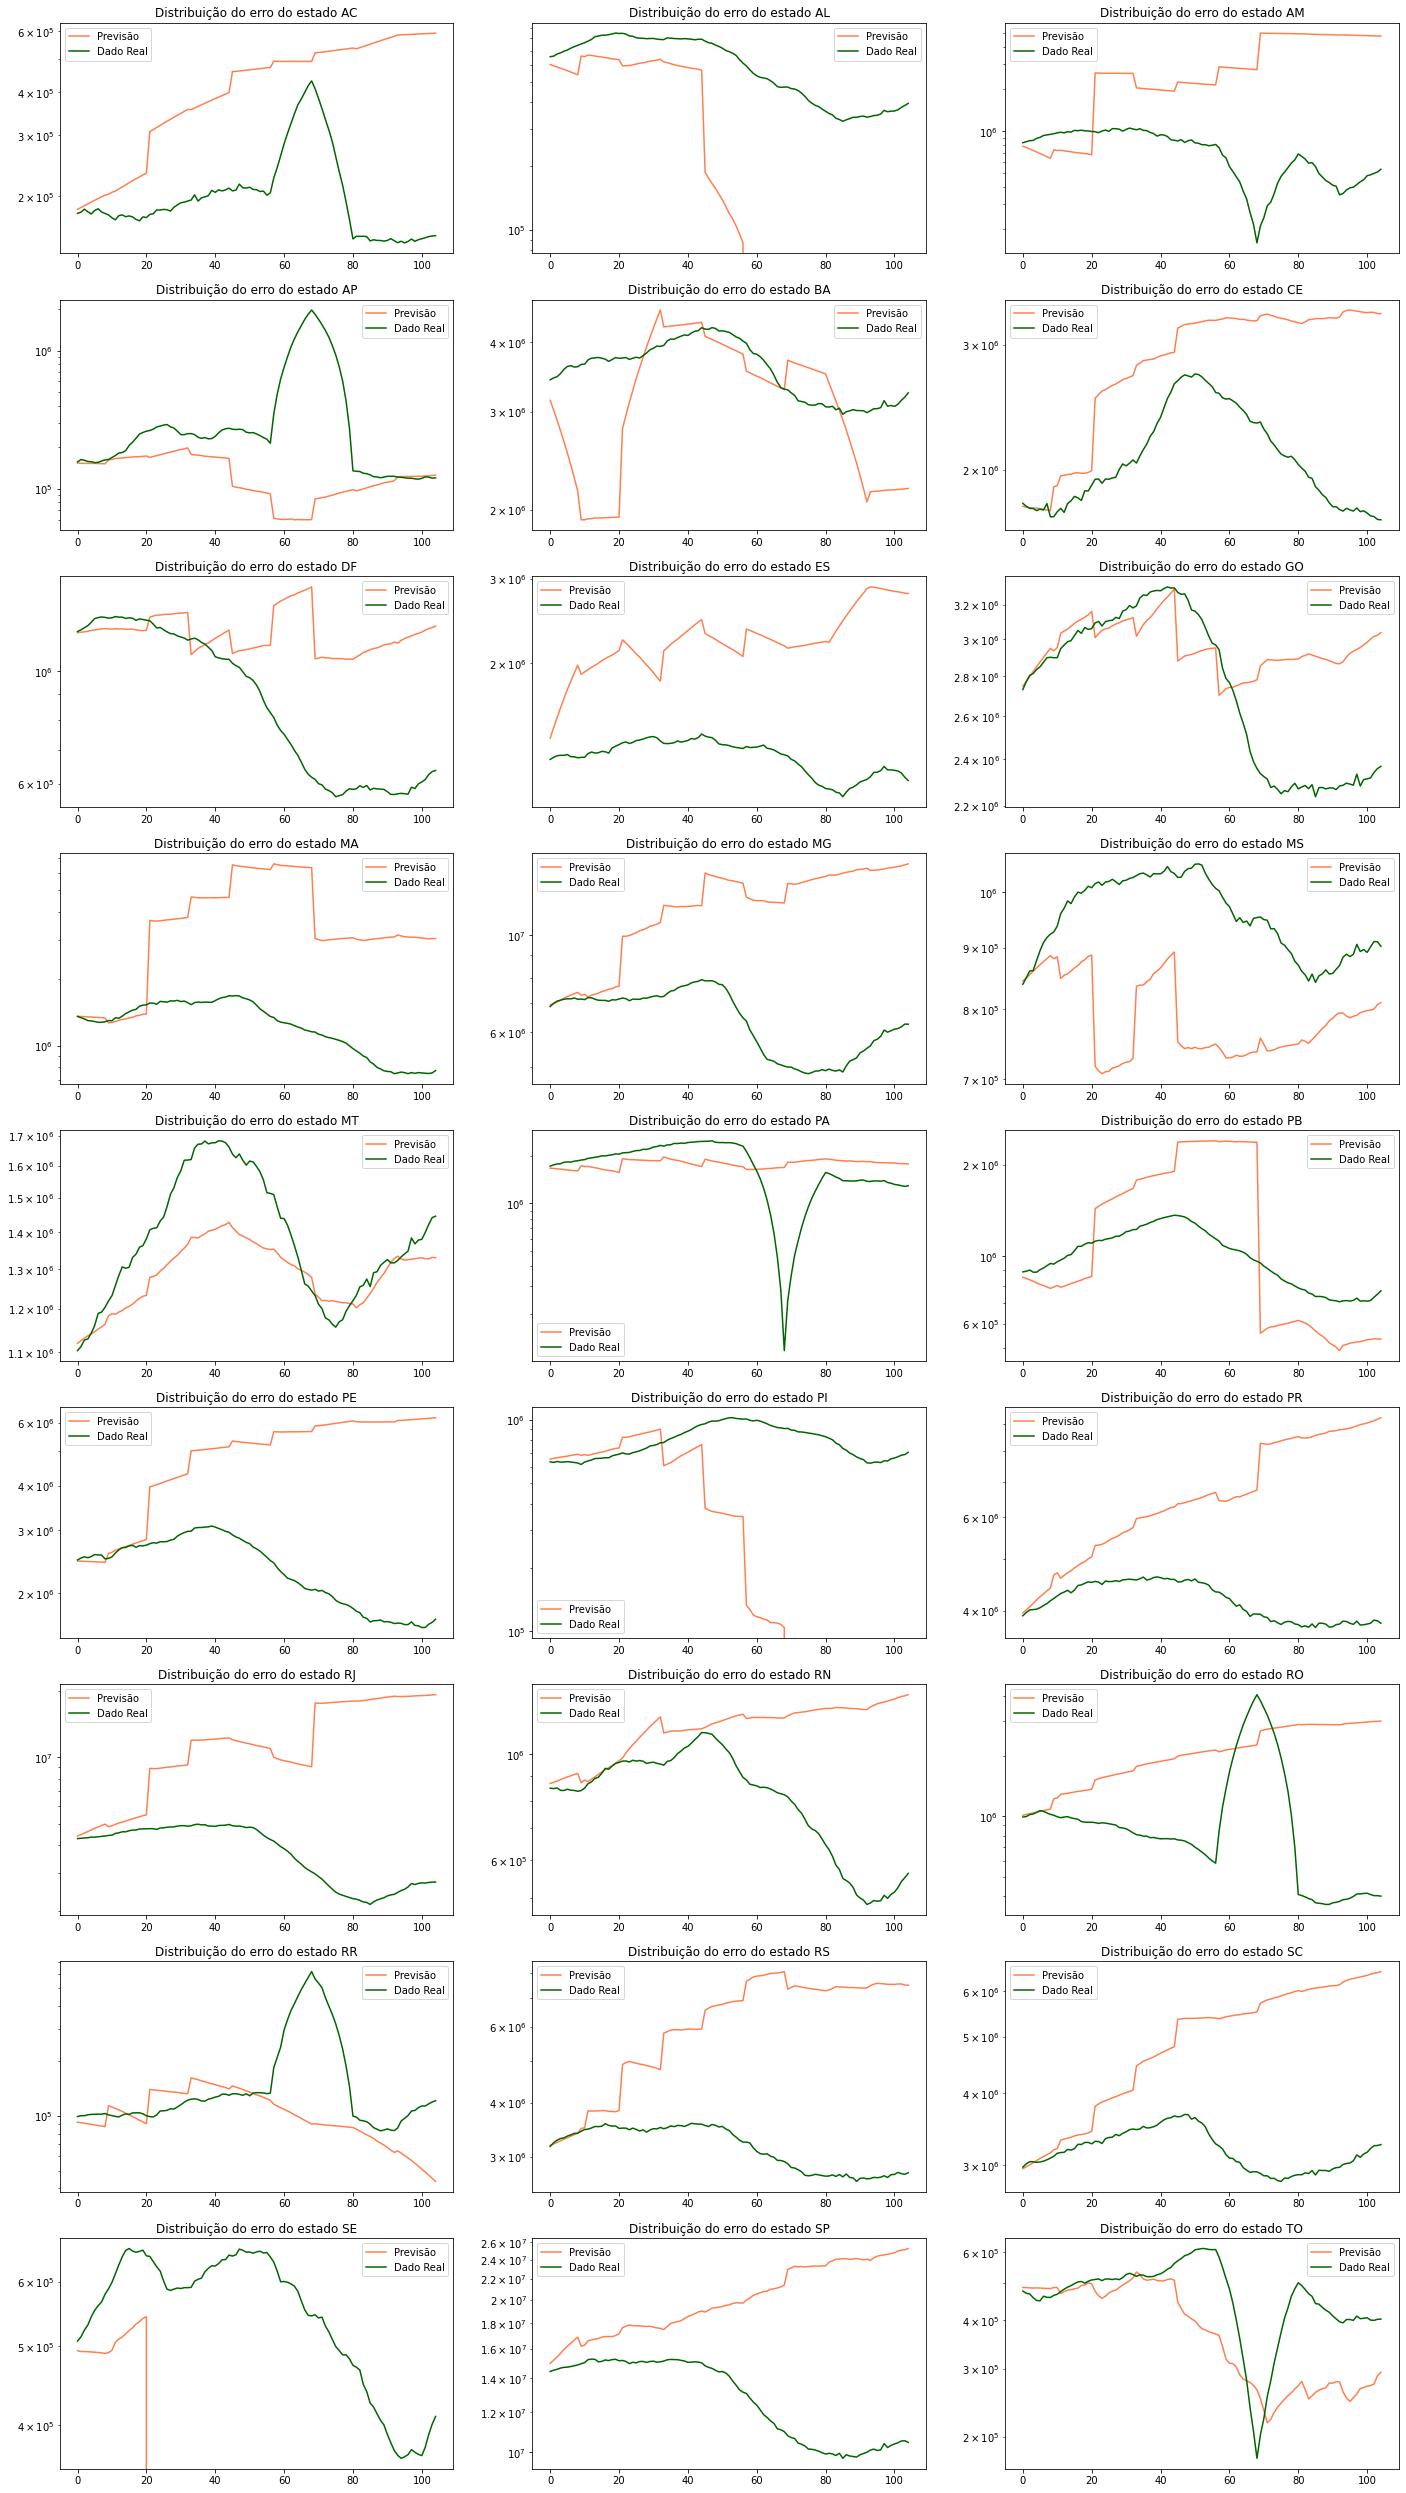

In [ ]:
show_predictions_graphs(pred, y_test_states)

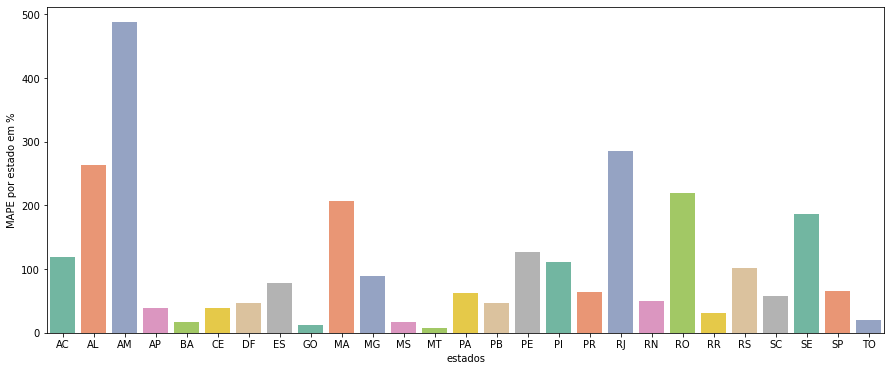

In [ ]:
show_error_state(pred, y_test_states)

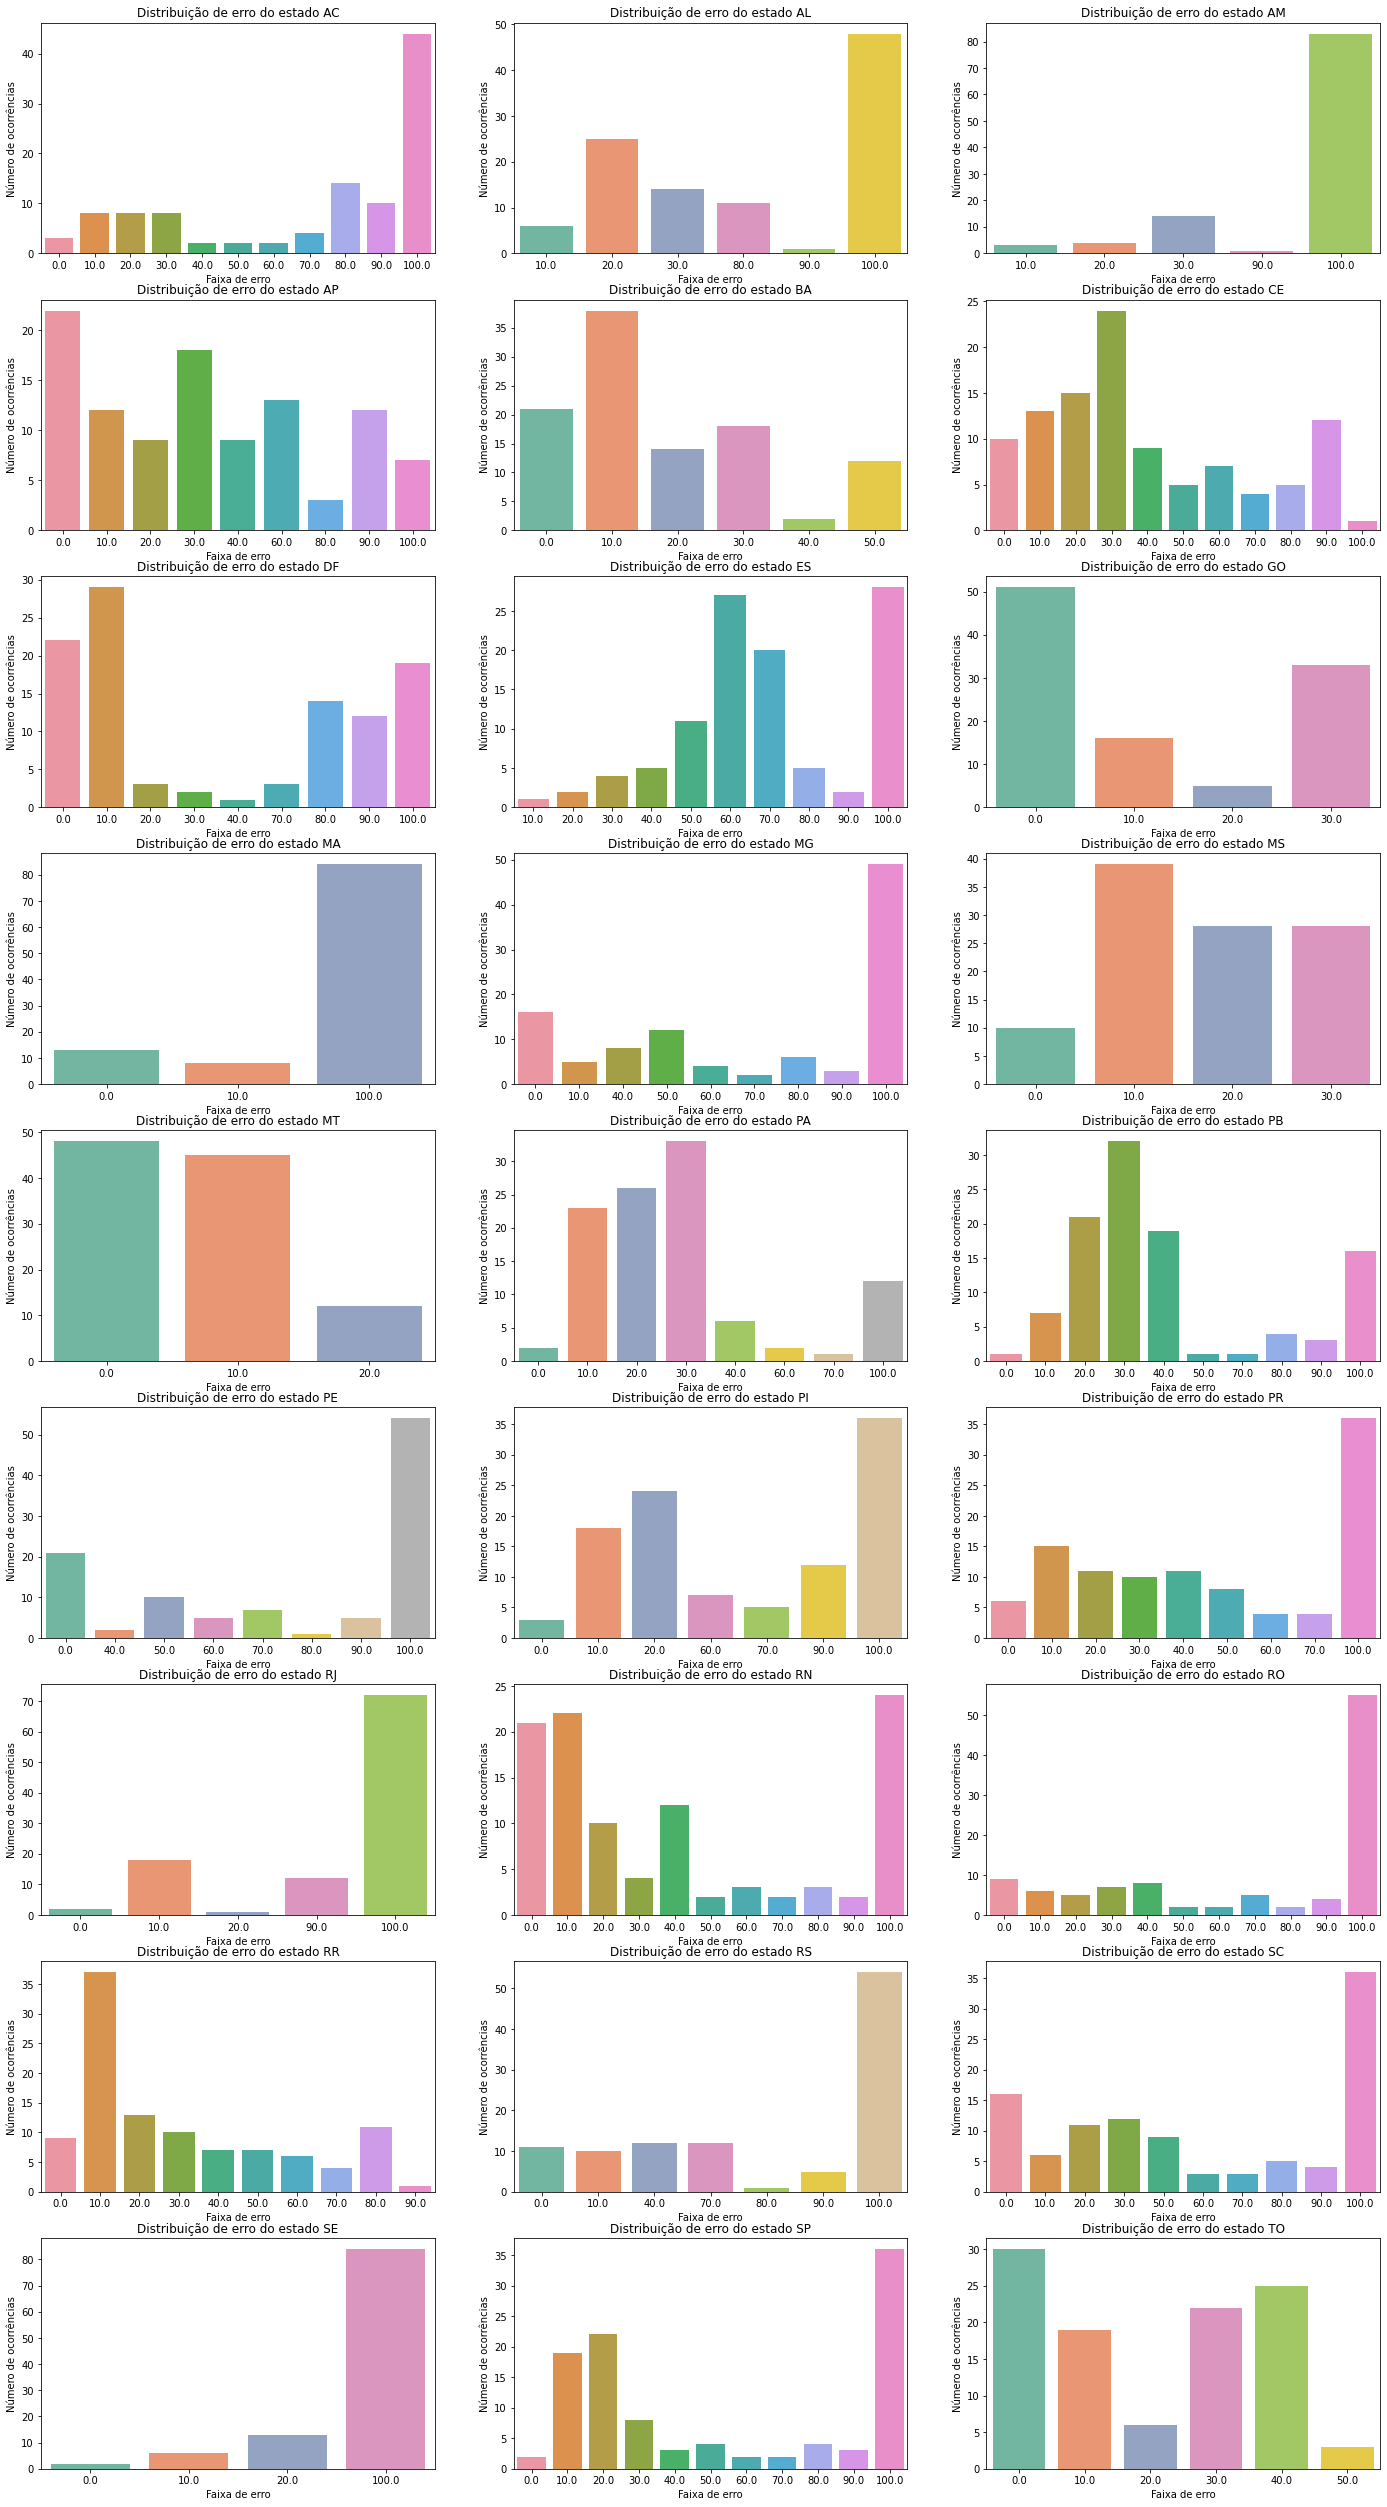

In [ ]:
show_error_graphs(pred, y_test_states)

## Normalizando os dados

### Normalização com Standard Scaler

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [ ]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"\n[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

    print(f"[{SIGLAS[i]}]: Score de teste: ")
    scores = score_regression_metrics(y_test, pred[i])
    show_scores(scores)


[AC]: Score: -0.7509925332506879
[AC]: Score de teste: 
Scores obtidos:
RMSE: 120175.05765409172
MAE: 77271.85169937638
MAPE: 0.2529895224425071

[AL]: Score: -14.056420215059207
[AL]: Score de teste: 
Scores obtidos:
RMSE: 394014.1987201541
MAE: 362859.2516243536
MAPE: 0.9312867836024596

[AM]: Score: -1.3828389653517972
[AM]: Score de teste: 
Scores obtidos:
RMSE: 247952.5508058881
MAE: 199315.16881740026
MAPE: 0.5765232369927505

[AP]: Score: -0.2908057688507988
[AP]: Score de teste: 
Scores obtidos:
RMSE: 664304.2798291284
MAE: 443847.4744576792
MAPE: 0.8773009734539098

[BA]: Score: 0.36923758556800546
[BA]: Score de teste: 
Scores obtidos:
RMSE: 288579.2416097472
MAE: 221154.55147199708
MAPE: 0.06945804636275359

[CE]: Score: -5.105414715080021
[CE]: Score de teste: 
Scores obtidos:
RMSE: 790032.0184236021
MAE: 703004.5797523475
MAPE: 0.36664030726318414

[DF]: Score: -16.72290987946494
[DF]: Score de teste: 
Scores obtidos:
RMSE: 409122.66456427524
MAE: 396896.5167873125
MAPE: 

In [ ]:
df_error["MSPE_SS"] = print_error(y_pred_state, y_test_state)

#### Gráficos

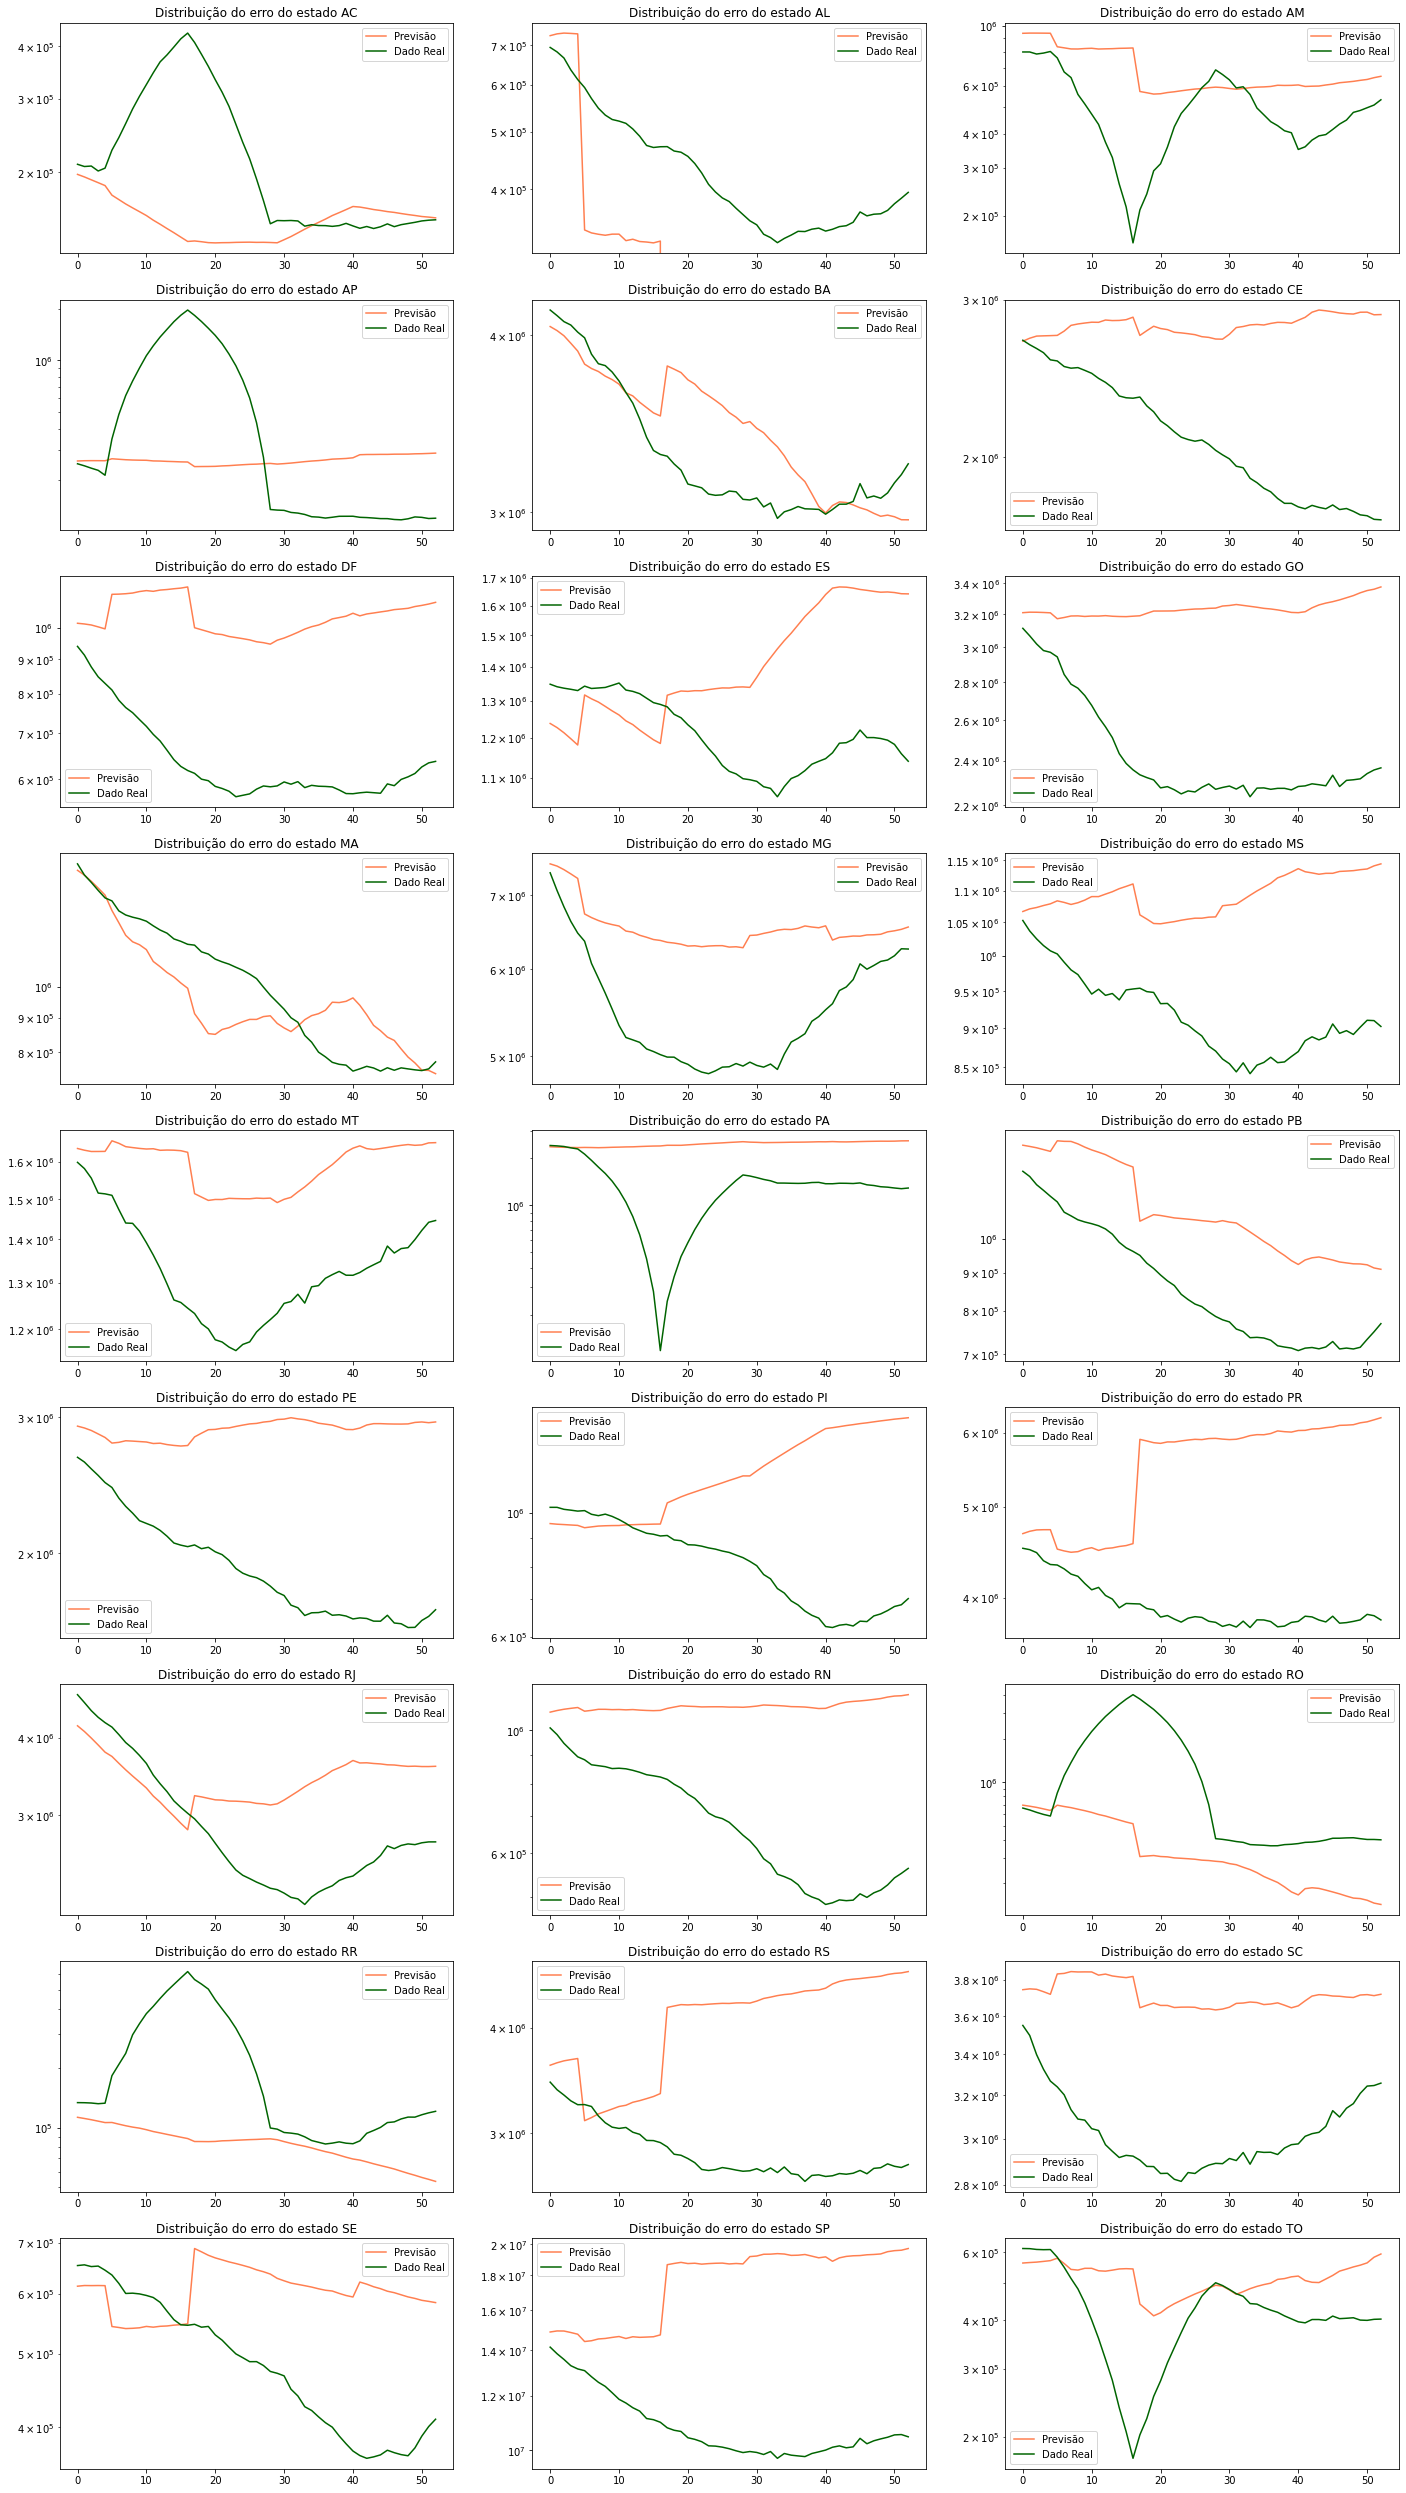

In [ ]:
show_predictions_graphs(pred, y_test_states)

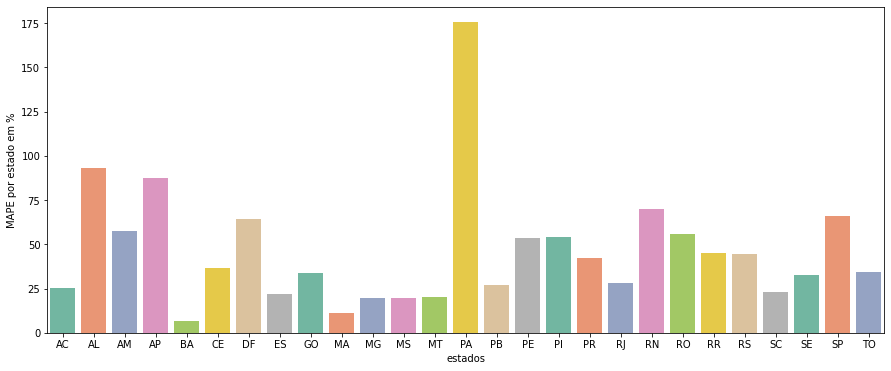

In [ ]:
show_error_state(pred, y_test_states)

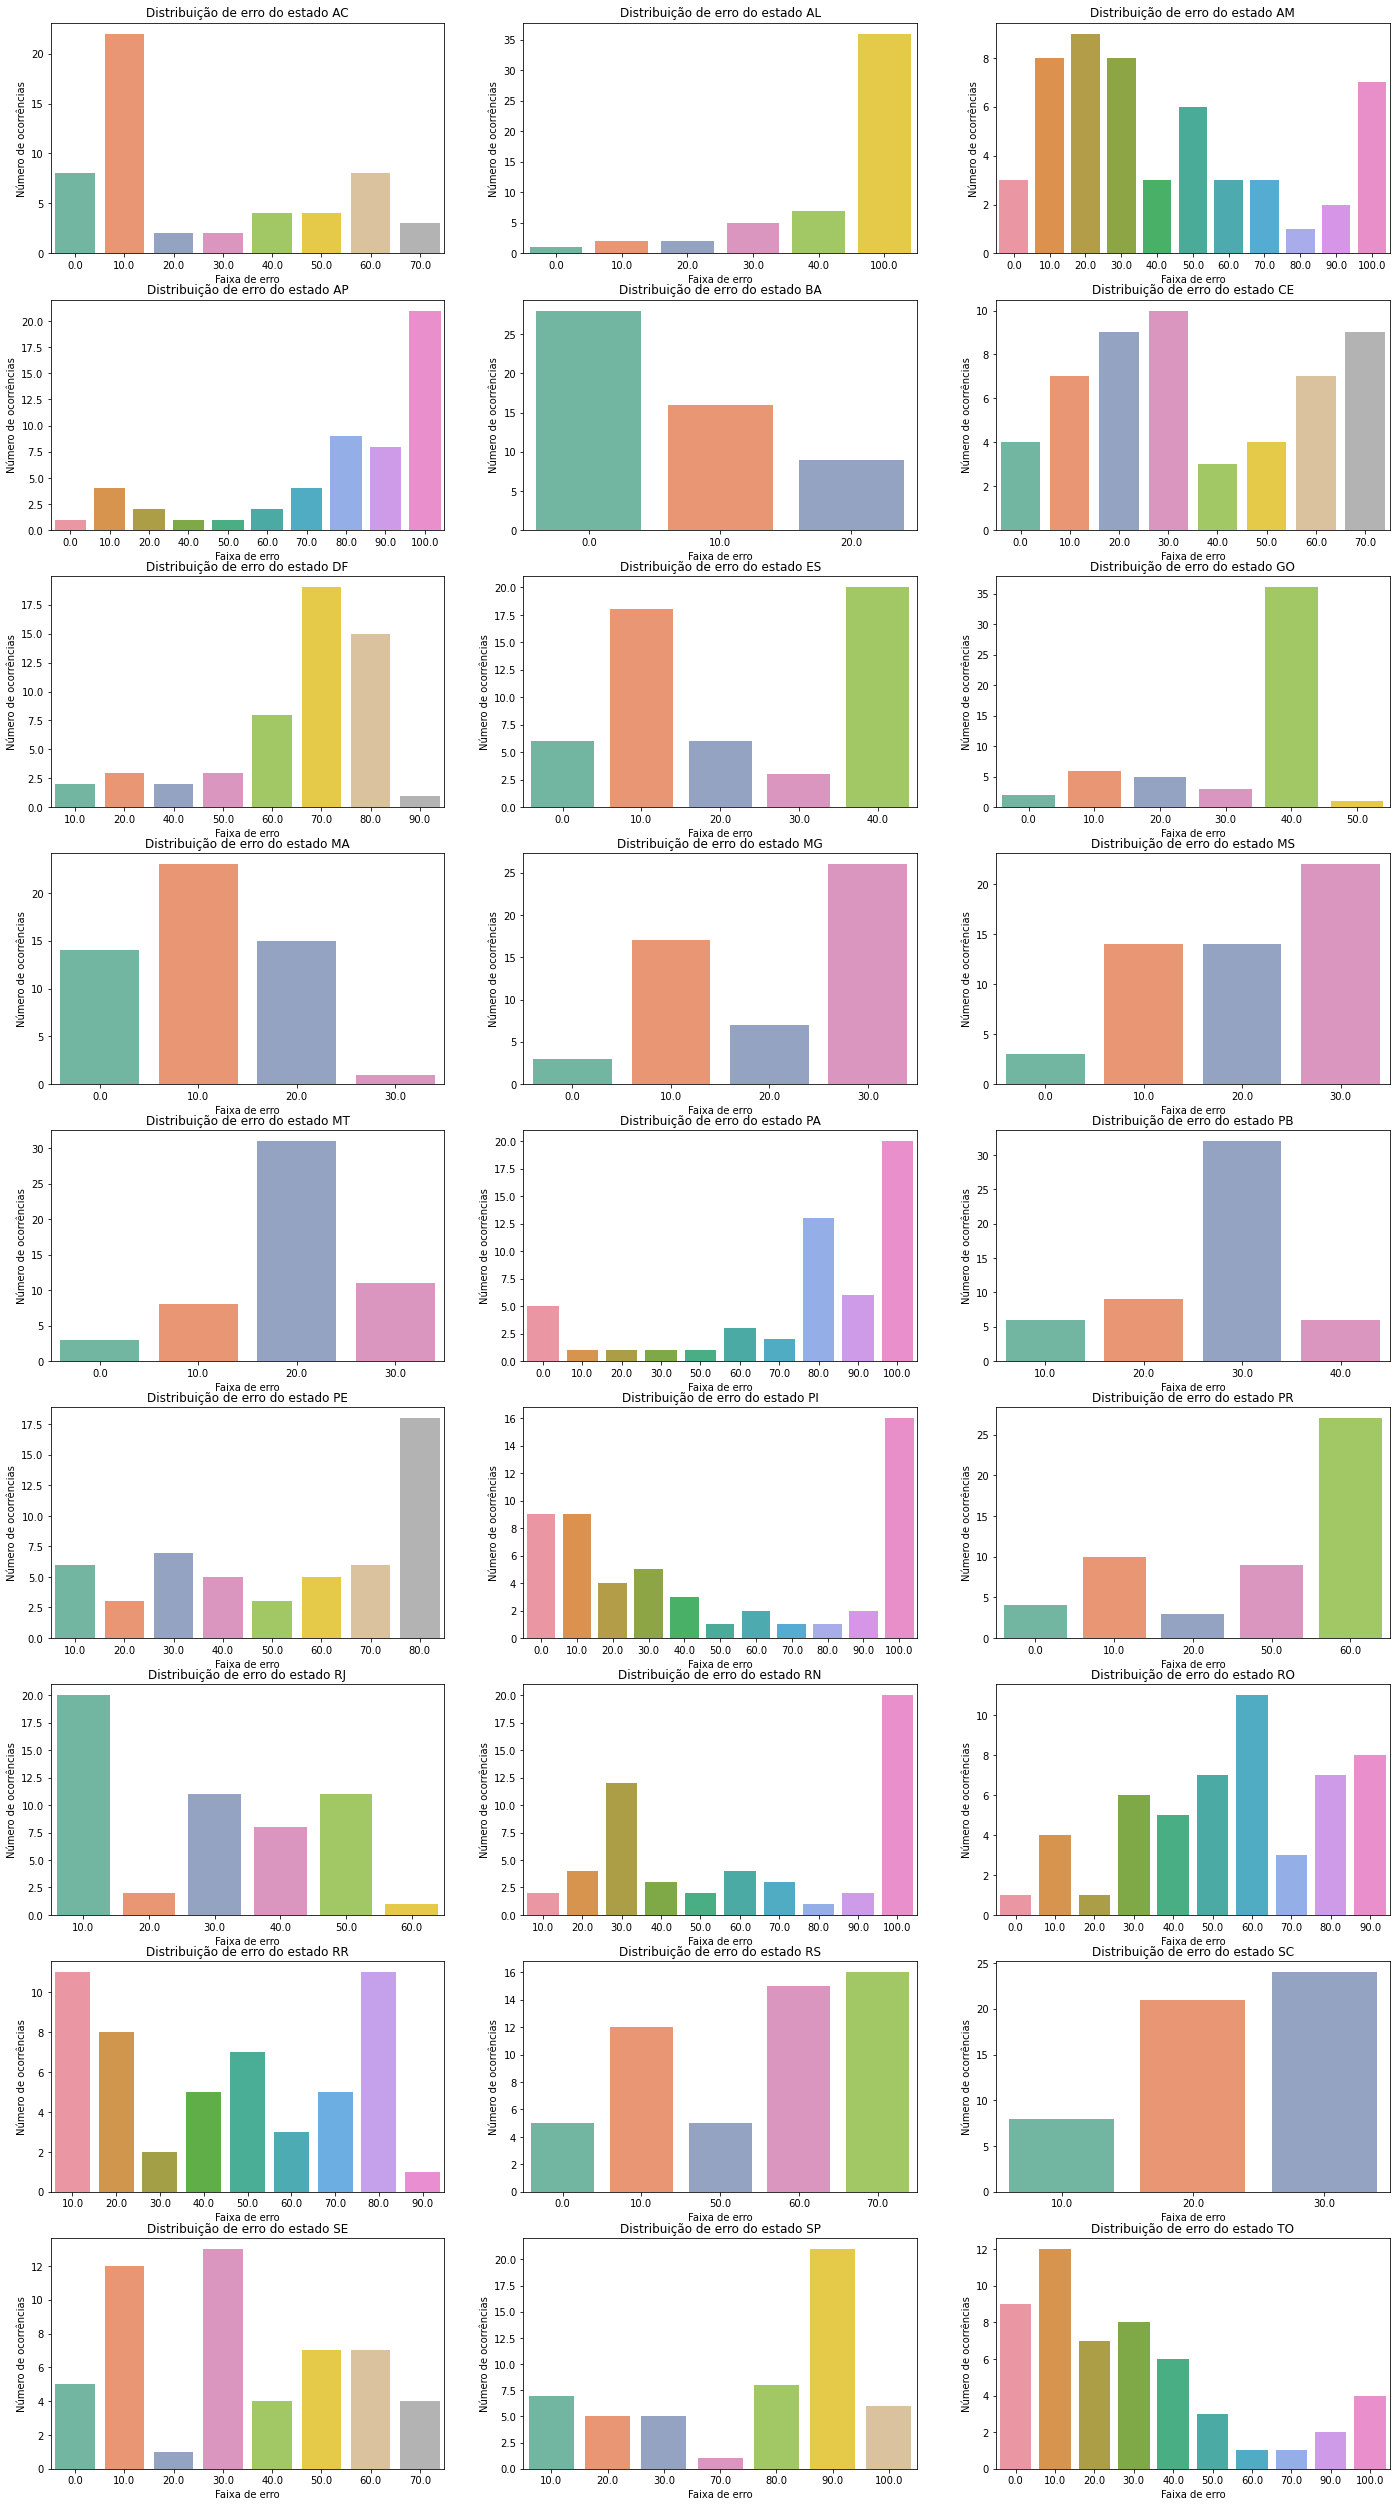

In [ ]:
show_error_graphs(pred, y_test_states)

### Normalizaçõa com MinMax

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [ ]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"\n[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

    print(f"[{SIGLAS[i]}]: Score de teste: ")
    scores = score_regression_metrics(y_test, pred[i])
    show_scores(scores)


[AC]: Score: -0.7509925332507015
[AC]: Score de teste: 
Scores obtidos:
RMSE: 120175.05765409219
MAE: 77271.85169937654
MAPE: 0.25298952244250694

[AL]: Score: -14.056420215060493
[AL]: Score de teste: 
Scores obtidos:
RMSE: 394014.198720171
MAE: 362859.2516243689
MAPE: 0.9312867836024995

[AM]: Score: -1.3828389653517656
[AM]: Score de teste: 
Scores obtidos:
RMSE: 247952.55080588648
MAE: 199315.16881739878
MAPE: 0.5765232369927464

[AP]: Score: -0.2908057688507988
[AP]: Score de teste: 
Scores obtidos:
RMSE: 664304.2798291284
MAE: 443847.4744576792
MAPE: 0.8773009734539096

[BA]: Score: 0.3692375855680027
[BA]: Score de teste: 
Scores obtidos:
RMSE: 288579.2416097478
MAE: 221154.55147199775
MAPE: 0.06945804636275377

[CE]: Score: -5.105414715079764
[CE]: Score de teste: 
Scores obtidos:
RMSE: 790032.0184235856
MAE: 703004.5797523307
MAPE: 0.3666403072631756

[DF]: Score: -16.722909879464872
[DF]: Score de teste: 
Scores obtidos:
RMSE: 409122.6645642744
MAE: 396896.51678731164
MAPE: 

In [ ]:
df_error["MSPE_MM"] = print_error(y_pred_state, y_test_state)

#### Gráficos

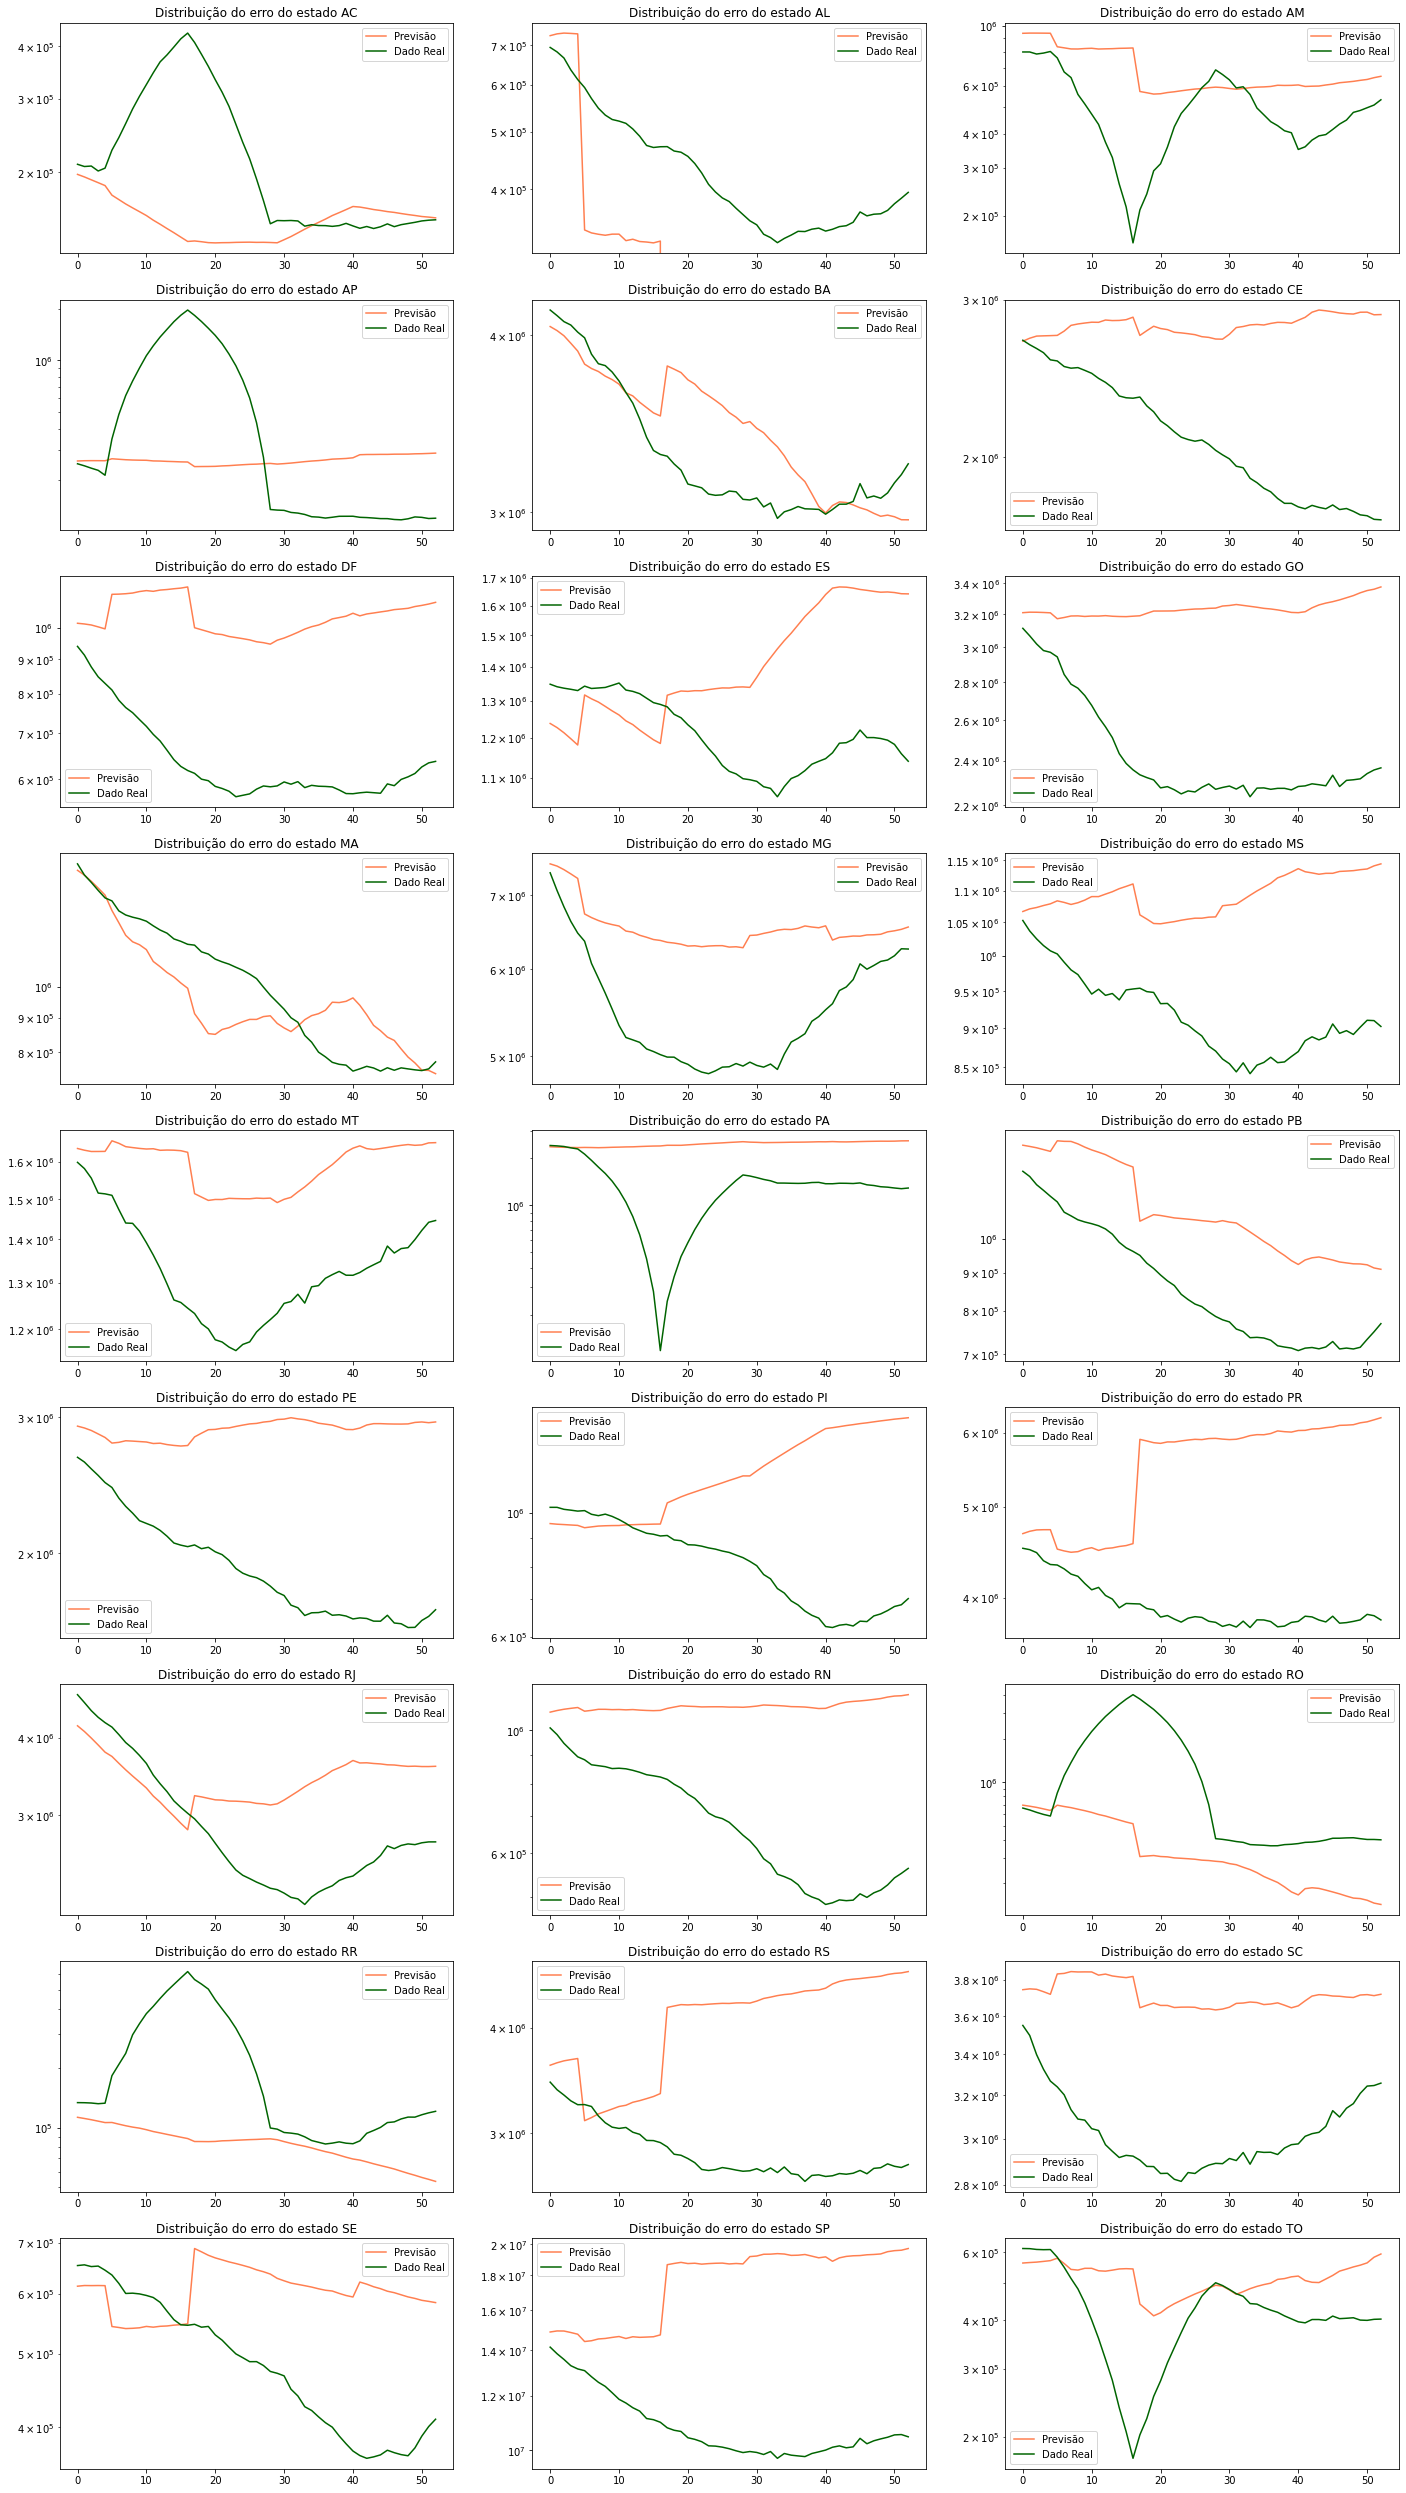

In [ ]:
show_predictions_graphs(pred, y_test_states)

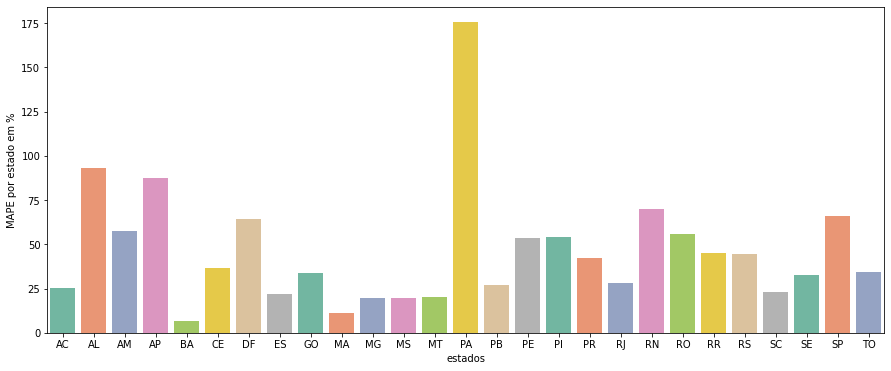

In [ ]:
show_error_state(pred, y_test_states)


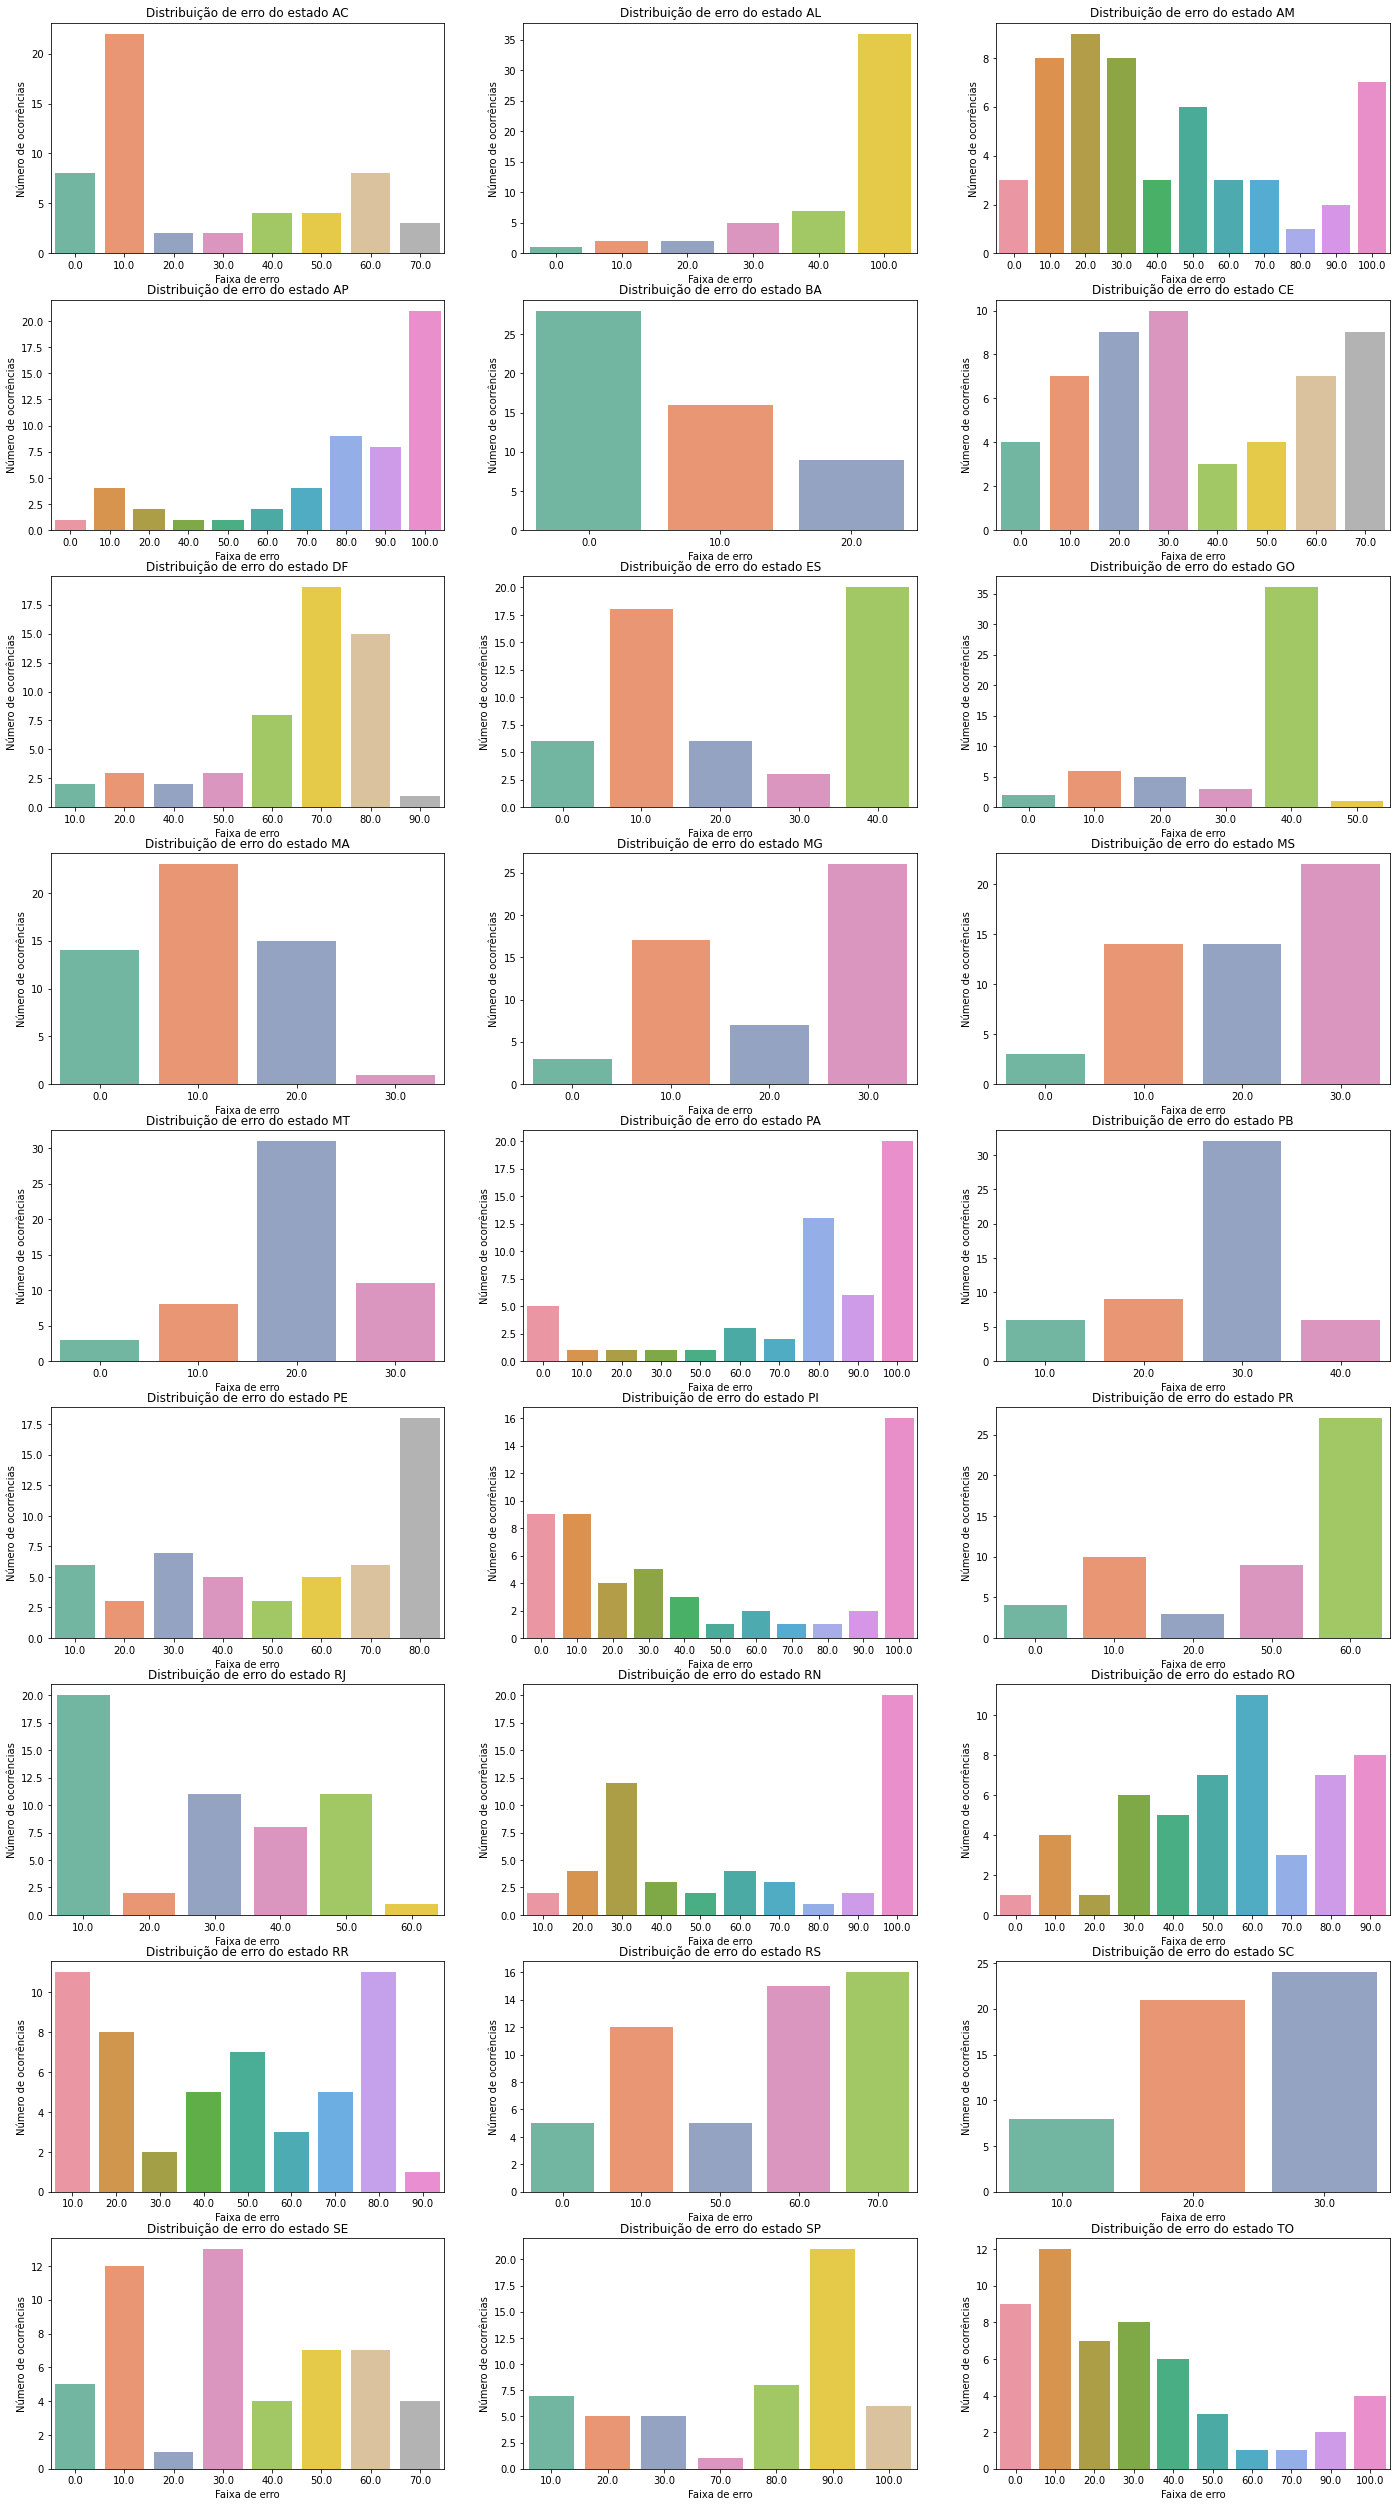

In [ ]:
show_error_graphs(pred, y_test_states)

### Normalização com PowerTransform

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = x.drop("data", axis=1)

# aqui só precisamos do valor do consumo em si 
y = pd.read_csv(PATH + "target_ac.csv")[["estados", 'consumo']]

In [ ]:
pred = {}

y_test_states = {}

for i in range(27):

    x_state = x[x["estados"] == SIGLAS[i]]
    y_state = y[y["estados"] == SIGLAS[i]]["consumo"]

    x_state = x_state.drop("estados", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_state, y_state, test_size=0.15, shuffle=False)

    # normalizacao
    
    # calcula media e desvio padrao do treino e normaliza os dados
    scaler = PowerTransformer()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_test_states[i] = y_test.reset_index(drop=True)

    regr = LinearRegression()

    regr.fit(x_train, y_train)

    print(f"\n[{SIGLAS[i]}]: Score: {regr.score(x_test, y_test)}")

    pred[i] = regr.predict(x_test)

    print(f"[{SIGLAS[i]}]: Score de teste: ")
    scores = score_regression_metrics(y_test, pred[i])
    show_scores(scores)


[AC]: Score: 0.042222196604596696
[AC]: Score de teste: 
Scores obtidos:
RMSE: 88880.10849891245
MAE: 73823.32424097101
MAPE: 0.3326604982003967

[AL]: Score: 0.6373206148121184
[AL]: Score de teste: 
Scores obtidos:
RMSE: 61152.25047643596
MAE: 50749.199969780544
MAPE: 0.12500593670713792

[AM]: Score: -0.28040190503593654
[AM]: Score de teste: 
Scores obtidos:
RMSE: 181758.35757157367
MAE: 128130.27798189157
MAPE: 0.37793426957803145

[AP]: Score: -0.2958246583307216
[AP]: Score de teste: 
Scores obtidos:
RMSE: 665594.4953125633
MAE: 431344.8246308969
MAPE: 0.7538184335260024

[BA]: Score: 0.38291998770416835
[BA]: Score de teste: 
Scores obtidos:
RMSE: 285432.17315119685
MAE: 214002.0085044851
MAPE: 0.06714785838827647

[CE]: Score: -1.8563121146776171
[CE]: Score de teste: 
Scores obtidos:
RMSE: 540368.3937689429
MAE: 460049.5578414694
MAPE: 0.2425877517026061

[DF]: Score: -19.74652141506537
[DF]: Score de teste: 
Scores obtidos:
RMSE: 442648.1658005928
MAE: 429176.3819589005
MAP

In [ ]:
df_error["MSPE_PT"] = print_error(y_pred_state, y_test_state)

#### Gráficos

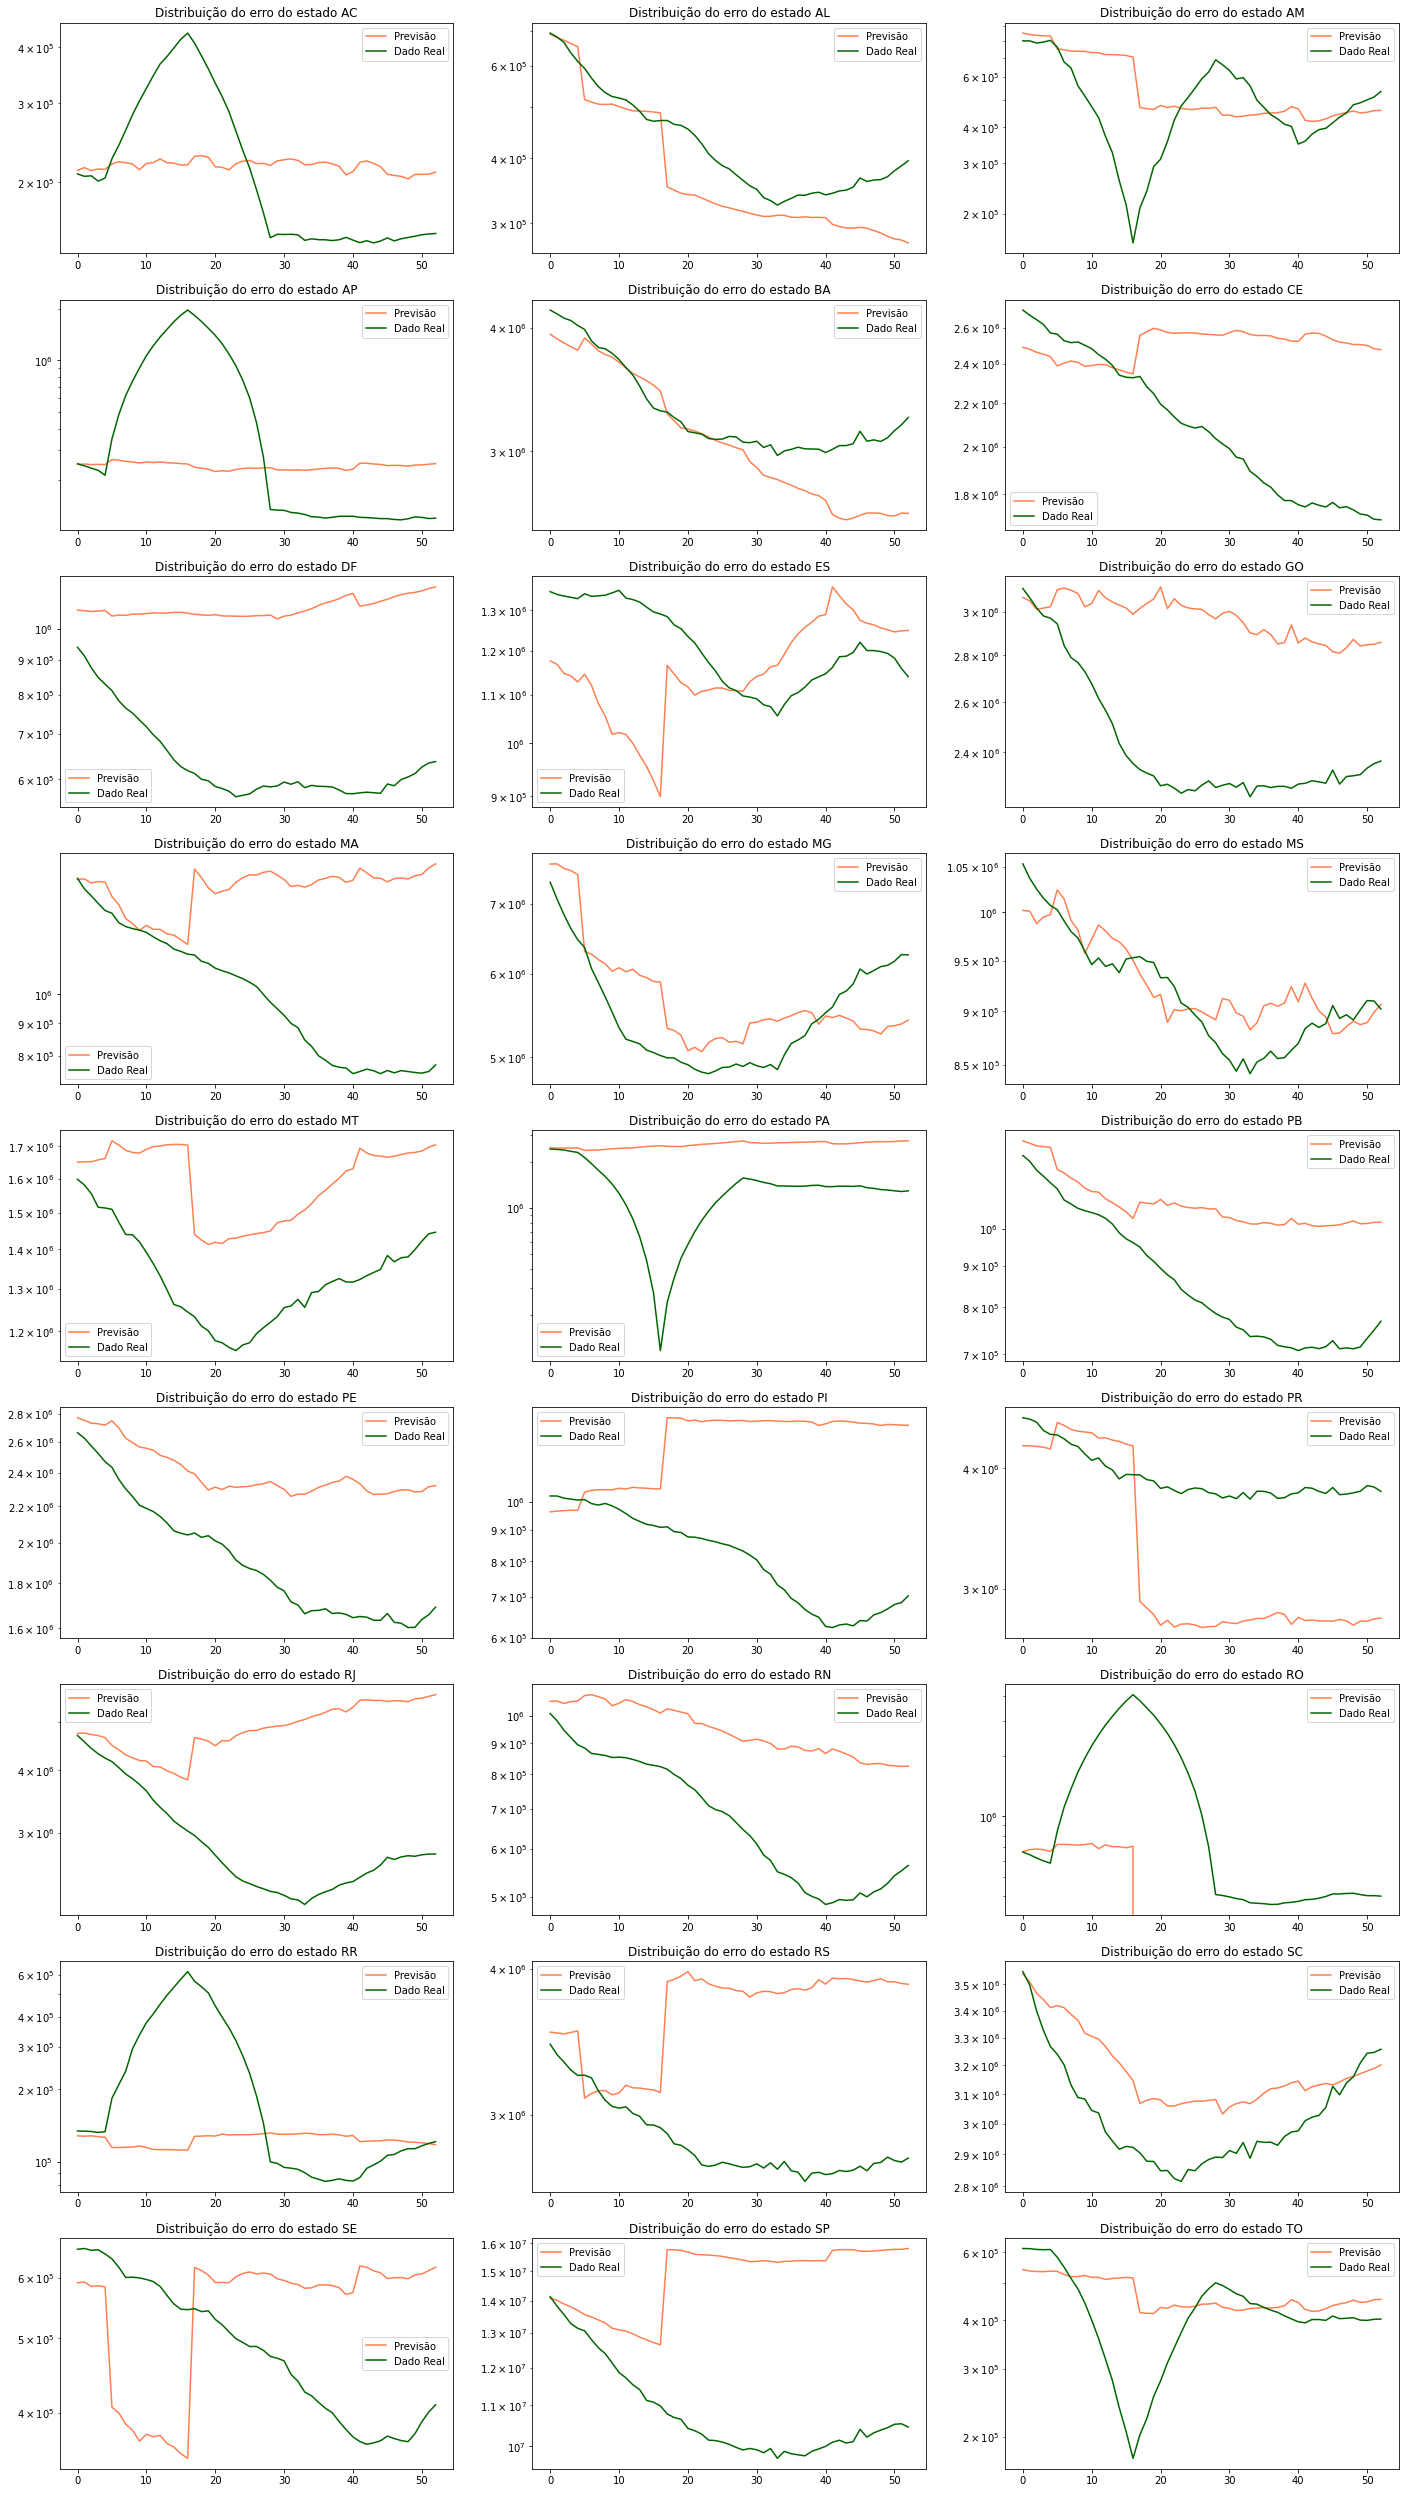

In [ ]:
show_predictions_graphs(pred, y_test_states)

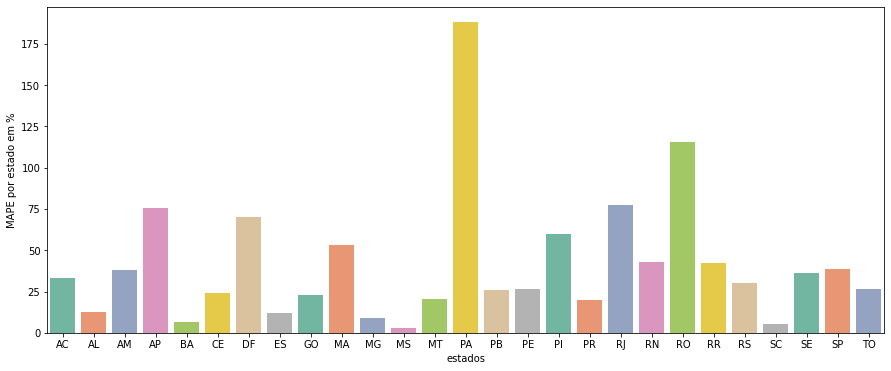

In [ ]:
show_error_state(pred, y_test_states)


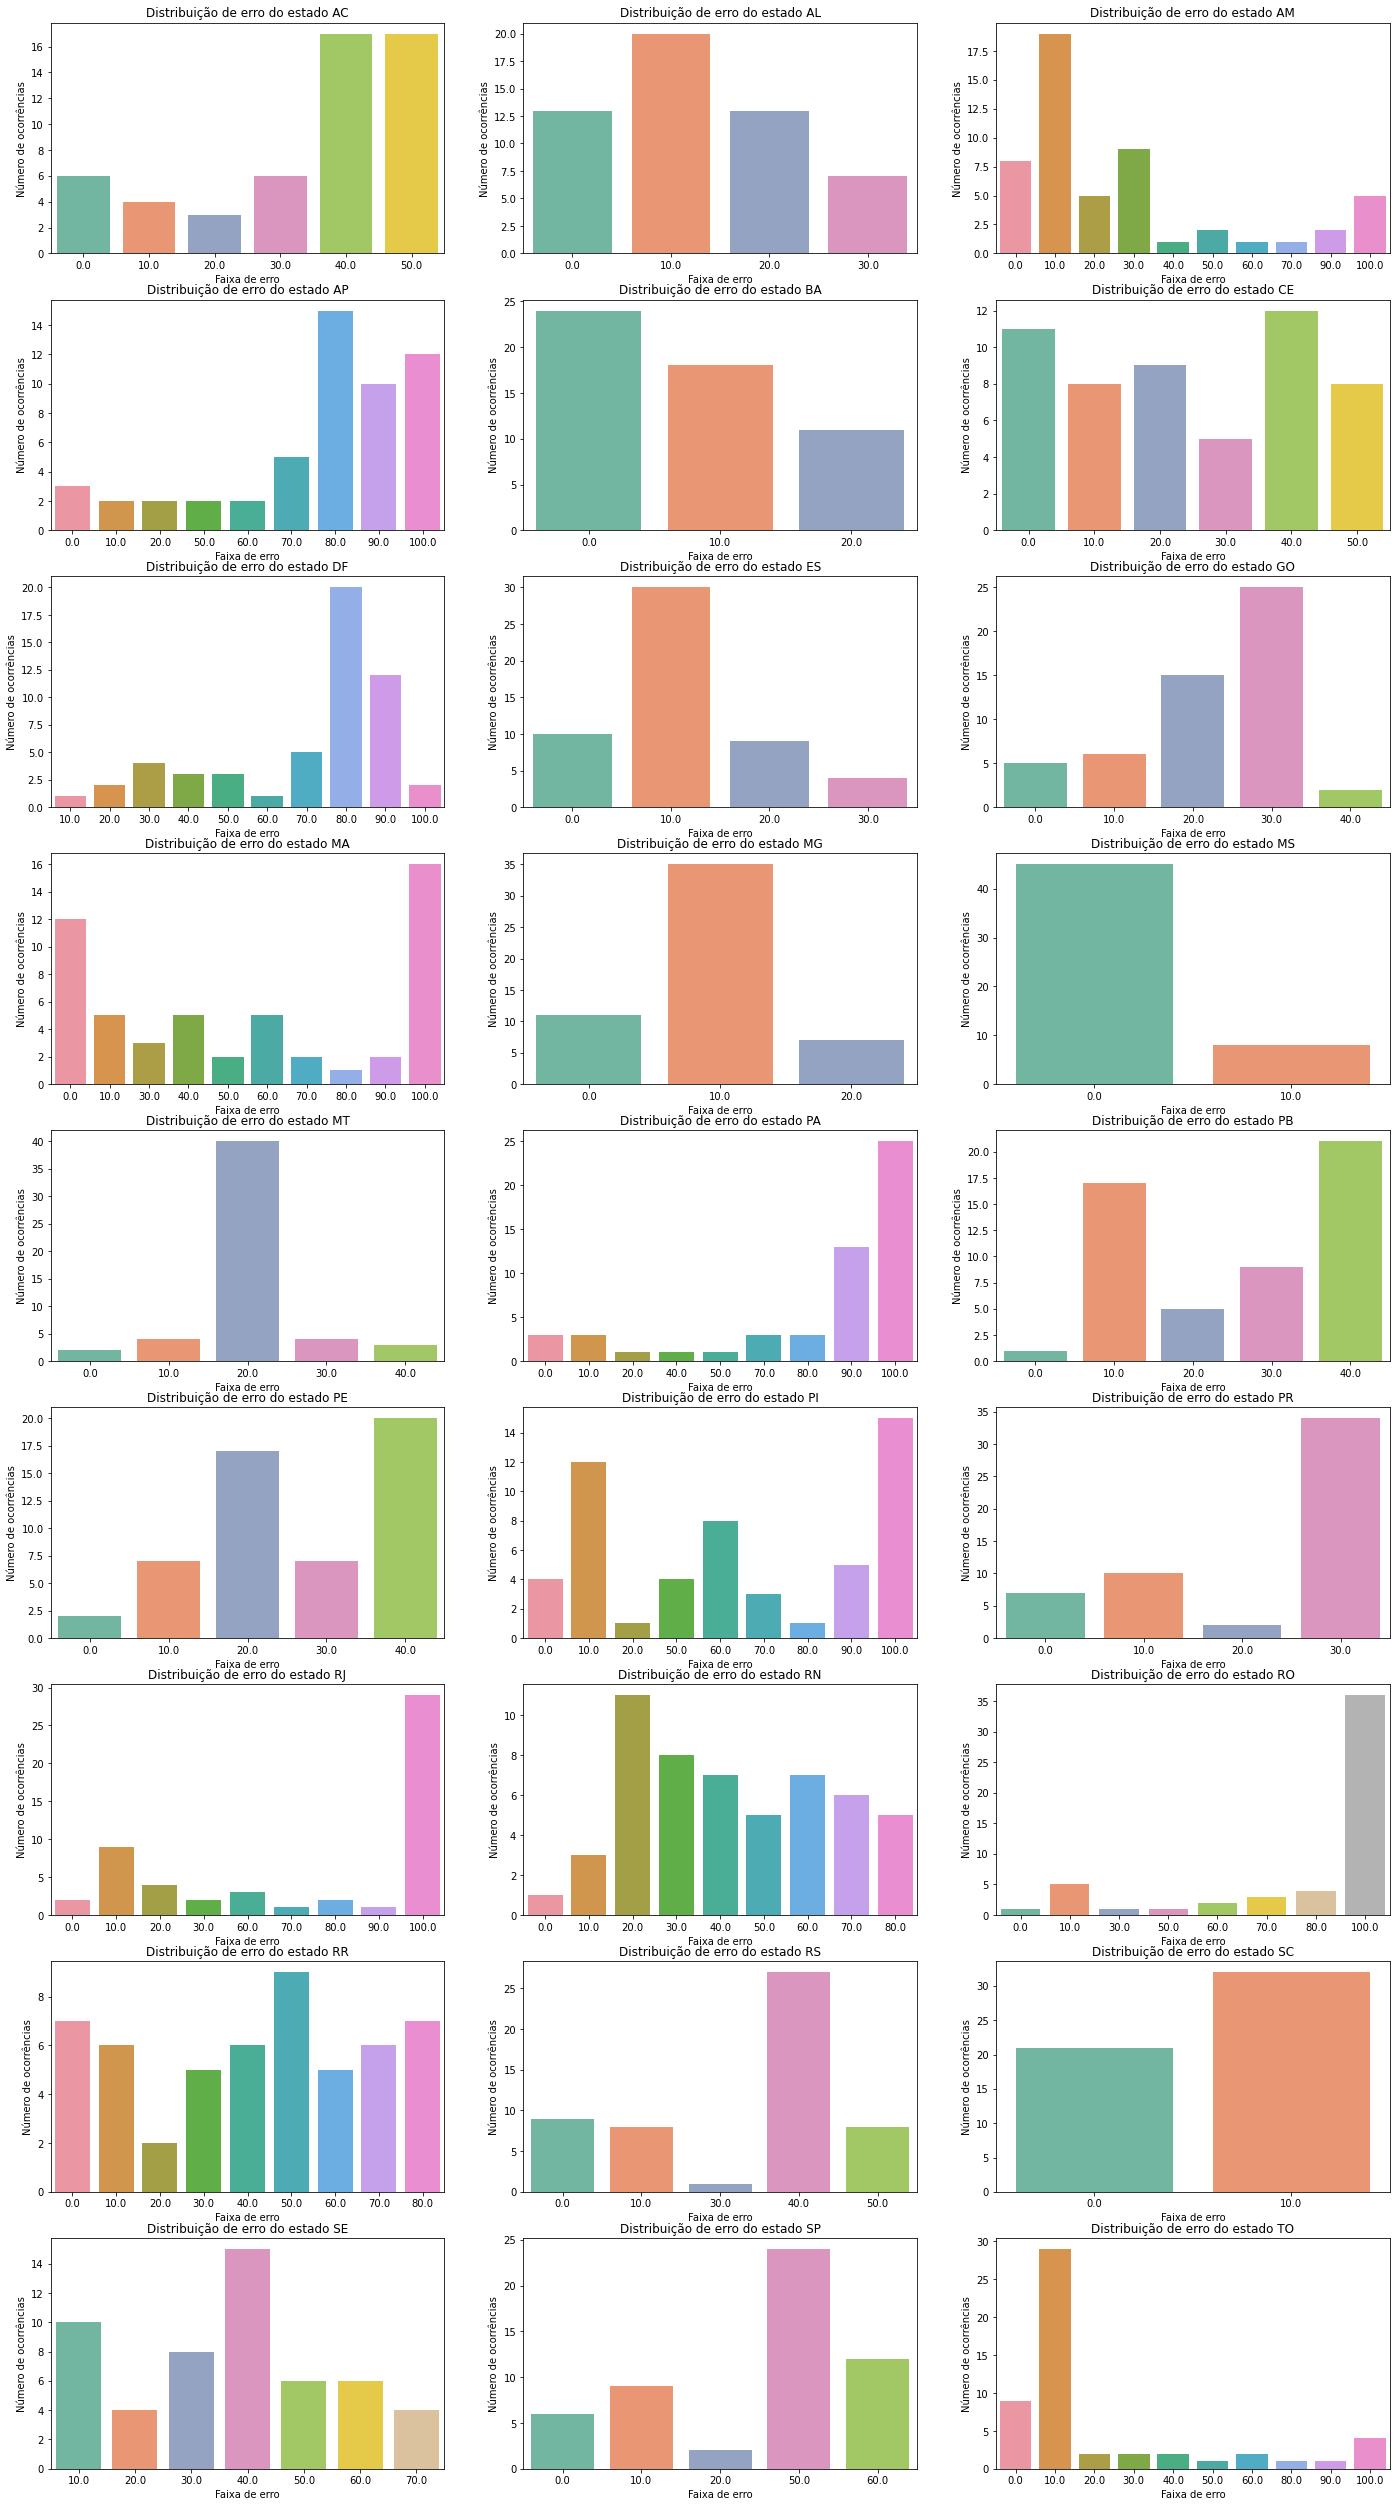

In [ ]:
show_error_graphs(pred, y_test_states)

# Resultados

|index|estados|indicador|MUSE\_SN|MUCE\_SN|MUCE\_SS|MUCE\_MM|MUCE\_PT|MSPE\_SN|MSPE\_SS|MSPE\_MM|MSPE\_PT|
|---|---|---|---|---|---|---|---|---|---|---|---|
|0|AC|RMSE|942117\.7372979432|446456\.2255696357|795903\.3734472815|446456\.27908910887|228286\.27734652584|228286\.27734652584|228286\.27734652584|228286\.27734652584|228286\.27734652584|
|1|AC|RMSE|158881\.38771397428|670960\.588956901|380612\.2972263031|670960\.6114365802|1077475\.928860529|1077475\.928860529|1077475\.928860529|1077475\.928860529|1077475\.928860529|
|2|AL|RMSE|224906\.03750036118|148576\.35610576242|241659\.8791337295|148576\.40096510164|205102\.15822301447|205102\.15822301447|205102\.15822301447|205102\.15822301447|205102\.15822301447|
|3|AL|RMSE|631236\.0769975462|446175\.01904026413|717136\.1708063594|446175\.05563298747|933507\.6359521585|933507\.6359521585|933507\.6359521585|933507\.6359521585|933507\.6359521585|
|4|AM|RMSE|213166\.2782534637|3040084\.8167749178|235071\.92968849227|3040084\.691499472|2403968\.675712575|2403968\.675712575|2403968\.675712575|2403968\.675712575|2403968\.675712575|
|5|AM|RMSE|439610\.1207160492|433338\.5637012162|452788\.19315297616|433338\.5914392668|398135\.1937022451|398135\.1937022451|398135\.1937022451|398135\.1937022451|398135\.1937022451|
|6|AP|RMSE|248753\.3674987371|382152\.11482361384|149093\.37434570954|382152\.1292046439|322844\.6760475613|322844\.6760475613|322844\.6760475613|322844\.6760475613|322844\.6760475613|
|7|AP|RMSE|545308\.4051507021|537635\.9932463214|326031\.8008559952|537635\.9759083601|1229264\.8915633305|1229264\.8915633305|1229264\.8915633305|1229264\.8915633305|1229264\.8915633305|
|8|BA|RMSE|2616967\.370009053|646228\.6535497751|1243309\.0151126706|646228\.5869466972|837231\.6394023095|837231\.6394023095|837231\.6394023095|837231\.6394023095|837231\.6394023095|
|9|BA|RMSE|487974\.76846293453|623749\.52586921|262755\.72969259834|623749\.5096795897|569455\.8654874447|569455\.8654874447|569455\.8654874447|569455\.8654874447|569455\.8654874447|
|10|CE|RMSE|1059746\.104401656|301854\.10800668213|1081419\.7369862006|301854\.10926024226|447790\.8295060267|447790\.8295060267|447790\.8295060267|447790\.8295060267|447790\.8295060267|
|11|CE|RMSE|323997\.377528185|324562\.5522710659|417894\.50063133|324562\.52924172656|230486\.14303452385|230486\.14303452385|230486\.14303452385|230486\.14303452385|230486\.14303452385|
|12|DF|RMSE|480288\.0855289462|1063986\.2479389044|648293\.1788241272|1063986\.2594318492|909221\.021048376|909221\.021048376|909221\.021048376|909221\.021048376|909221\.021048376|
|13|DF|RMSE|605728\.3576116972|256081\.826215539|256231\.65383443967|256081\.96376860616|894897\.2614707233|894897\.2614707233|894897\.2614707233|894897\.2614707233|894897\.2614707233|
|14|ES|RMSE|247958\.9443304728|459209\.8158469731|371845\.211348003|459209\.88496180717|376028\.55446158757|376028\.55446158757|376028\.55446158757|376028\.55446158757|376028\.55446158757|
|15|ES|RMSE|4434605\.902204166|546255\.8329760578|3235343\.951345028|546255\.9274964749|723962\.7992626189|723962\.7992626189|723962\.7992626189|723962\.7992626189|723962\.7992626189|
|16|GO|RMSE|308268\.9850325392|650102\.4506001461|380278\.04131778196|650102\.4600963133|861340\.7921430287|861340\.7921430287|861340\.7921430287|861340\.7921430287|861340\.7921430287|
|17|GO|RMSE|472100\.27959882724|431853\.6545576444|340893\.5456319906|431853\.6945700291|395180\.6284659439|395180\.6284659439|395180\.6284659439|395180\.6284659439|395180\.6284659439|
|18|MA|RMSE|510238\.51854641037|316785\.386971752|438876\.7514992988|316785\.4296470259|161754\.66060707922|161754\.66060707922|161754\.66060707922|161754\.66060707922|161754\.66060707922|
|19|MA|RMSE|700826\.4560207115|838467\.3483637919|558051\.0569041945|838467\.3839385402|894519\.8586066164|894519\.8586066164|894519\.8586066164|894519\.8586066164|894519\.8586066164|
|20|MG|RMSE|559629\.3733769316|267414\.6945962089|576902\.3074219878|267414\.70982440276|467575\.222006942|467575\.222006942|467575\.222006942|467575\.222006942|467575\.222006942|
|21|MG|RMSE|638758\.6968499789|441208\.3883446975|561576\.8825251955|441208\.42148386344|802140\.5418436236|802140\.5418436236|802140\.5418436236|802140\.5418436236|802140\.5418436236|
|22|MS|RMSE|472908\.6365380712|211204\.87080210523|462983\.67777252494|211204\.91791631616|569872\.9342327064|569872\.9342327064|569872\.9342327064|569872\.9342327064|569872\.9342327064|
|23|MS|RMSE|1145900\.073240834|278986\.13690682297|1001347\.2410029385|278986\.1854181493|224405\.25128986288|224405\.25128986288|224405\.25128986288|224405\.25128986288|224405\.25128986288|
|24|MT|RMSE|173079\.6939844381|1093021\.8091446129|224941\.24613289643|1093021\.7348108618|2030143\.7429505375|2030143\.7429505375|2030143\.7429505375|2030143\.7429505375|2030143\.7429505375|
|25|MT|RMSE|612948\.3251519292|366497\.12284890574|389947\.2463911592|366497\.18473590974|1029447\.4351350272|1029447\.4351350272|1029447\.4351350272|1029447\.4351350272|1029447\.4351350272|
|26|PA|RMSE|227694\.97222933517|1234004\.5413240609|433412\.7225869852|1234004\.5254134052|1234225\.3586607957|1234225\.3586607957|1234225\.3586607957|1234225\.3586607957|1234225\.3586607957|
|27|PA|MAPE|0\.10445770972920895|1\.0|0\.11984101693643588|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|
|28|PB|MAPE|0\.1560756514004479|0\.23132641304390714|0\.3989419434651815|0\.23132642116015525|0\.37760567104227544|0\.37760567104227544|0\.37760567104227544|0\.37760567104227544|0\.37760567104227544|
|29|PB|MAPE|0\.15285123951138374|0\.04117053596170562|0\.16426640257866867|0\.041170553434854366|0\.05916794669991672|0\.05916794669991672|0\.05916794669991672|0\.05916794669991672|0\.05916794669991672|
|30|PE|MAPE|0\.8169747880275288|0\.961572138114735|0\.9075444779375776|0\.9615722161732212|1\.0|1\.0|1\.0|1\.0|1\.0|
|31|PE|MAPE|0\.21266312178938737|0\.2811519447520529|0\.23916147653872066|0\.28115193303306096|0\.21282628442873497|0\.21282628442873497|0\.21282628442873497|0\.21282628442873497|0\.21282628442873497|
|32|PI|MAPE|0\.14260601904821013|1\.0|0\.1959570459941213|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|
|33|PI|MAPE|0\.28576962270689166|1\.0|0\.16078782603065225|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|
|34|PR|MAPE|0\.1103060760741113|1\.0|0\.07411316395818011|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|
|35|PR|MAPE|0\.8760015538146615|1\.0|0\.4121892962008441|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|
|36|RJ|MAPE|0\.7052319961860108|1\.0|0\.360161275278744|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|
|37|RJ|MAPE|0\.8013180621503443|0\.05367067546578531|0\.6139228386728097|0\.05367067634847777|0\.1272591358657753|0\.1272591358657753|0\.1272591358657753|0\.1272591358657753|0\.1272591358657753|
|38|RN|MAPE|1\.0|0\.11904930755531044|1\.0|0\.1190493043684274|0\.08999392362818222|0\.08999392362818222|0\.08999392362818222|0\.08999392362818222|0\.08999392362818222|
|39|RN|MAPE|0\.14576069420083881|1\.0|0\.20232888982611794|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|
|40|RO|MAPE|0\.17108801702777626|0\.20669088154968643|0\.05728662984633977|0\.2066910029941159|0\.7394182528177995|0\.7394182528177995|0\.7394182528177995|0\.7394182528177995|0\.7394182528177995|
|41|RO|MAPE|0\.4950666801318036|0\.18397516972418984|0\.7492582784455961|0\.1839751971845929|0\.14676349953307524|0\.14676349953307524|0\.14676349953307524|0\.14676349953307524|0\.14676349953307524|
|42|RR|MAPE|0\.3810498495904026|0\.5685069783303085|0\.27488989009088954|0\.5685070847636797|0\.7619264265163926|0\.7619264265163926|0\.7619264265163926|0\.7619264265163926|0\.7619264265163926|
|43|RR|MAPE|0\.7835497739144578|0\.11053840364237962|0\.9595872042858612|0\.1105384053757139|0\.1447439814754753|0\.1447439814754753|0\.1447439814754753|0\.1447439814754753|0\.1447439814754753|
|44|RS|MAPE|1\.0|0\.4723278331961321|1\.0|0\.4723278767532855|0\.4114676642736002|0\.4114676642736002|0\.4114676642736002|0\.4114676642736002|0\.4114676642736002|
|45|RS|MAPE|1\.0|0\.23368723527860752|0\.9742573011414534|0\.23368726782361687|0\.10419238700142314|0\.10419238700142314|0\.10419238700142314|0\.10419238700142314|0\.10419238700142314|
|46|SC|MAPE|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|1\.0|
|47|SC|MAPE|1\.0|0\.3082393291830158|1\.0|0\.3082393485442833|0\.5443974519184184|0\.5443974519184184|0\.5443974519184184|0\.5443974519184184|0\.5443974519184184|
|48|SE|MAPE|0\.14180647016787934|0\.22025070032140953|0\.10169265036719902|0\.22025071933093338|0\.42205999186330495|0\.42205999186330495|0\.42205999186330495|0\.42205999186330495|0\.42205999186330495|
|49|SE|MAPE|0\.16697621383516761|0\.2422998040089243|0\.15845760720024943|0\.24229985490250572|0\.7176569493830184|0\.7176569493830184|0\.7176569493830184|0\.7176569493830184|0\.7176569493830184|
|50|SP|MAPE|1\.0|0\.06739082068661495|1\.0|0\.06739083257796853|0\.04723784888065407|0\.04723784888065407|0\.04723784888065407|0\.04723784888065407|0\.04723784888065407|
|51|SP|MAPE|0\.12605610089266664|0\.395376551325675|0\.1725258289031794|0\.39537652216546587|0\.7438805383659702|0\.7438805383659702|0\.7438805383659702|0\.7438805383659702|0\.7438805383659702|
|52|TO|MAPE|0\.1998377923812532|0\.5707782005427846|0\.1477125683797739|0\.570778302831435|1\.0|1\.0|1\.0|1\.0|1\.0|
|53|TO|MAPE|0\.19571028822423628|0\.8713925845515967|0\.40319454351287265|0\.8713926145031947|1\.0|1\.0|1\.0|1\.0|1\.0|

## Permitindo números maiores de 100%

|index|estados|indicador|MUSE\_SN|MUCE\_SN|MUCE\_SS|MUCE\_MM|MUCE\_PT|MSPE\_SN|MSPE\_SS|MSPE\_MM|MSPE\_PT|
|---|---|---|---|---|---|---|---|---|---|---|---|
|0|AC|RMSE|942117\.7372979432|446456\.2255696357|795903\.3734472815|446456\.27908910887|228286\.27734652584|228286\.27734652584|228286\.27734652584|228286\.27734652584|228286\.27734652584|
|1|AC|RMSE|158881\.38771397428|670960\.588956901|380612\.2972263031|670960\.6114365802|1077475\.928860529|1077475\.928860529|1077475\.928860529|1077475\.928860529|1077475\.928860529|
|2|AL|RMSE|224906\.03750036118|148576\.35610576242|241659\.8791337295|148576\.40096510164|205102\.15822301447|205102\.15822301447|205102\.15822301447|205102\.15822301447|205102\.15822301447|
|3|AL|RMSE|631236\.0769975462|446175\.01904026413|717136\.1708063594|446175\.05563298747|933507\.6359521585|933507\.6359521585|933507\.6359521585|933507\.6359521585|933507\.6359521585|
|4|AM|RMSE|213166\.2782534637|3040084\.8167749178|235071\.92968849227|3040084\.691499472|2403968\.675712575|2403968\.675712575|2403968\.675712575|2403968\.675712575|2403968\.675712575|
|5|AM|RMSE|439610\.1207160492|433338\.5637012162|452788\.19315297616|433338\.5914392668|398135\.1937022451|398135\.1937022451|398135\.1937022451|398135\.1937022451|398135\.1937022451|
|6|AP|RMSE|248753\.3674987371|382152\.11482361384|149093\.37434570954|382152\.1292046439|322844\.6760475613|322844\.6760475613|322844\.6760475613|322844\.6760475613|322844\.6760475613|
|7|AP|RMSE|545308\.4051507021|537635\.9932463214|326031\.8008559952|537635\.9759083601|1229264\.8915633305|1229264\.8915633305|1229264\.8915633305|1229264\.8915633305|1229264\.8915633305|
|8|BA|RMSE|2616967\.370009053|646228\.6535497751|1243309\.0151126706|646228\.5869466972|837231\.6394023095|837231\.6394023095|837231\.6394023095|837231\.6394023095|837231\.6394023095|
|9|BA|RMSE|487974\.76846293453|623749\.52586921|262755\.72969259834|623749\.5096795897|569455\.8654874447|569455\.8654874447|569455\.8654874447|569455\.8654874447|569455\.8654874447|
|10|CE|RMSE|1059746\.104401656|301854\.10800668213|1081419\.7369862006|301854\.10926024226|447790\.8295060267|447790\.8295060267|447790\.8295060267|447790\.8295060267|447790\.8295060267|
|11|CE|RMSE|323997\.377528185|324562\.5522710659|417894\.50063133|324562\.52924172656|230486\.14303452385|230486\.14303452385|230486\.14303452385|230486\.14303452385|230486\.14303452385|
|12|DF|RMSE|480288\.0855289462|1063986\.2479389044|648293\.1788241272|1063986\.2594318492|909221\.021048376|909221\.021048376|909221\.021048376|909221\.021048376|909221\.021048376|
|13|DF|RMSE|605728\.3576116972|256081\.826215539|256231\.65383443967|256081\.96376860616|894897\.2614707233|894897\.2614707233|894897\.2614707233|894897\.2614707233|894897\.2614707233|
|14|ES|RMSE|247958\.9443304728|459209\.8158469731|371845\.211348003|459209\.88496180717|376028\.55446158757|376028\.55446158757|376028\.55446158757|376028\.55446158757|376028\.55446158757|
|15|ES|RMSE|4434605\.902204166|546255\.8329760578|3235343\.951345028|546255\.9274964749|723962\.7992626189|723962\.7992626189|723962\.7992626189|723962\.7992626189|723962\.7992626189|
|16|GO|RMSE|308268\.9850325392|650102\.4506001461|380278\.04131778196|650102\.4600963133|861340\.7921430287|861340\.7921430287|861340\.7921430287|861340\.7921430287|861340\.7921430287|
|17|GO|RMSE|472100\.27959882724|431853\.6545576444|340893\.5456319906|431853\.6945700291|395180\.6284659439|395180\.6284659439|395180\.6284659439|395180\.6284659439|395180\.6284659439|
|18|MA|RMSE|510238\.51854641037|316785\.386971752|438876\.7514992988|316785\.4296470259|161754\.66060707922|161754\.66060707922|161754\.66060707922|161754\.66060707922|161754\.66060707922|
|19|MA|RMSE|700826\.4560207115|838467\.3483637919|558051\.0569041945|838467\.3839385402|894519\.8586066164|894519\.8586066164|894519\.8586066164|894519\.8586066164|894519\.8586066164|
|20|MG|RMSE|559629\.3733769316|267414\.6945962089|576902\.3074219878|267414\.70982440276|467575\.222006942|467575\.222006942|467575\.222006942|467575\.222006942|467575\.222006942|
|21|MG|RMSE|638758\.6968499789|441208\.3883446975|561576\.8825251955|441208\.42148386344|802140\.5418436236|802140\.5418436236|802140\.5418436236|802140\.5418436236|802140\.5418436236|
|22|MS|RMSE|472908\.6365380712|211204\.87080210523|462983\.67777252494|211204\.91791631616|569872\.9342327064|569872\.9342327064|569872\.9342327064|569872\.9342327064|569872\.9342327064|
|23|MS|RMSE|1145900\.073240834|278986\.13690682297|1001347\.2410029385|278986\.1854181493|224405\.25128986288|224405\.25128986288|224405\.25128986288|224405\.25128986288|224405\.25128986288|
|24|MT|RMSE|173079\.6939844381|1093021\.8091446129|224941\.24613289643|1093021\.7348108618|2030143\.7429505375|2030143\.7429505375|2030143\.7429505375|2030143\.7429505375|2030143\.7429505375|
|25|MT|RMSE|612948\.3251519292|366497\.12284890574|389947\.2463911592|366497\.18473590974|1029447\.4351350272|1029447\.4351350272|1029447\.4351350272|1029447\.4351350272|1029447\.4351350272|
|26|PA|RMSE|227694\.97222933517|1234004\.5413240609|433412\.7225869852|1234004\.5254134052|1234225\.3586607957|1234225\.3586607957|1234225\.3586607957|1234225\.3586607957|1234225\.3586607957|
|27|PA|MAPE|0\.10445770972920895|3\.4509930852872923|0\.11984101693643588|3\.450993490901343|1\.1845110189480748|1\.1845110189480748|1\.1845110189480748|1\.1845110189480748|1\.1845110189480748|
|28|PB|MAPE|0\.1560756514004479|0\.23132641304390714|0\.3989419434651815|0\.23132642116015525|0\.37760567104227544|0\.37760567104227544|0\.37760567104227544|0\.37760567104227544|0\.37760567104227544|
|29|PB|MAPE|0\.15285123951138374|0\.04117053596170562|0\.16426640257866867|0\.041170553434854366|0\.05916794669991672|0\.05916794669991672|0\.05916794669991672|0\.05916794669991672|0\.05916794669991672|
|30|PE|MAPE|0\.8169747880275288|0\.961572138114735|0\.9075444779375776|0\.9615722161732212|1\.978067593447754|1\.978067593447754|1\.978067593447754|1\.978067593447754|1\.978067593447754|
|31|PE|MAPE|0\.21266312178938737|0\.2811519447520529|0\.23916147653872066|0\.28115193303306096|0\.21282628442873497|0\.21282628442873497|0\.21282628442873497|0\.21282628442873497|0\.21282628442873497|
|32|PI|MAPE|0\.14260601904821013|1\.1781250067022595|0\.1959570459941213|1\.178125080281593|1\.0611582938915536|1\.0611582938915536|1\.0611582938915536|1\.0611582938915536|1\.0611582938915536|
|33|PI|MAPE|0\.28576962270689166|2\.030807659323256|0\.16078782603065225|2\.030807737139081|1\.5744263829887888|1\.5744263829887888|1\.5744263829887888|1\.5744263829887888|1\.5744263829887888|
|34|PR|MAPE|0\.1103060760741113|1\.3335934418673738|0\.07411316395818011|1\.3335933981762922|3\.026143641706724|3\.026143641706724|3\.026143641706724|3\.026143641706724|3\.026143641706724|
|35|PR|MAPE|0\.8760015538146615|1\.5973908124185043|0\.4121892962008441|1\.5973906524041501|2\.0414829449079037|2\.0414829449079037|2\.0414829449079037|2\.0414829449079037|2\.0414829449079037|
|36|RJ|MAPE|0\.7052319961860108|2\.9427911140003036|0\.360161275278744|2\.9427909401677295|1\.0577761258372973|1\.0577761258372973|1\.0577761258372973|1\.0577761258372973|1\.0577761258372973|
|37|RJ|MAPE|0\.8013180621503443|0\.05367067546578531|0\.6139228386728097|0\.05367067634847777|0\.1272591358657753|0\.1272591358657753|0\.1272591358657753|0\.1272591358657753|0\.1272591358657753|
|38|RN|MAPE|2\.3808284051072137|0\.11904930755531044|3\.2334528161594114|0\.1190493043684274|0\.08999392362818222|0\.08999392362818222|0\.08999392362818222|0\.08999392362818222|0\.08999392362818222|
|39|RN|MAPE|0\.14576069420083881|1\.7057480344900944|0\.20232888982611794|1\.7057480530581626|1\.4318110966324311|1\.4318110966324311|1\.4318110966324311|1\.4318110966324311|1\.4318110966324311|
|40|RO|MAPE|0\.17108801702777626|0\.20669088154968643|0\.05728662984633977|0\.2066910029941159|0\.7394182528177995|0\.7394182528177995|0\.7394182528177995|0\.7394182528177995|0\.7394182528177995|
|41|RO|MAPE|0\.4950666801318036|0\.18397516972418984|0\.7492582784455961|0\.1839751971845929|0\.14676349953307524|0\.14676349953307524|0\.14676349953307524|0\.14676349953307524|0\.14676349953307524|
|42|RR|MAPE|0\.3810498495904026|0\.5685069783303085|0\.27488989009088954|0\.5685070847636797|0\.7619264265163926|0\.7619264265163926|0\.7619264265163926|0\.7619264265163926|0\.7619264265163926|
|43|RR|MAPE|0\.7835497739144578|0\.11053840364237962|0\.9595872042858612|0\.1105384053757139|0\.1447439814754753|0\.1447439814754753|0\.1447439814754753|0\.1447439814754753|0\.1447439814754753|
|44|RS|MAPE|2\.442508763699143|0\.4723278331961321|1\.7666328890913292|0\.4723278767532855|0\.4114676642736002|0\.4114676642736002|0\.4114676642736002|0\.4114676642736002|0\.4114676642736002|
|45|RS|MAPE|1\.140123668794383|0\.23368723527860752|0\.9742573011414534|0\.23368726782361687|0\.10419238700142314|0\.10419238700142314|0\.10419238700142314|0\.10419238700142314|0\.10419238700142314|
|46|SC|MAPE|1\.5343804768821876|1\.2234365318449258|1\.2389343540569642|1\.2234365781529513|1\.3254705144684233|1\.3254705144684233|1\.3254705144684233|1\.3254705144684233|1\.3254705144684233|
|47|SC|MAPE|1\.6440665300929986|0\.3082393291830158|2\.5666988109858977|0\.3082393485442833|0\.5443974519184184|0\.5443974519184184|0\.5443974519184184|0\.5443974519184184|0\.5443974519184184|
|48|SE|MAPE|0\.14180647016787934|0\.22025070032140953|0\.10169265036719902|0\.22025071933093338|0\.42205999186330495|0\.42205999186330495|0\.42205999186330495|0\.42205999186330495|0\.42205999186330495|
|49|SE|MAPE|0\.16697621383516761|0\.2422998040089243|0\.15845760720024943|0\.24229985490250572|0\.7176569493830184|0\.7176569493830184|0\.7176569493830184|0\.7176569493830184|0\.7176569493830184|
|50|SP|MAPE|1\.6827930939460032|0\.06739082068661495|1\.473376818523102|0\.06739083257796853|0\.04723784888065407|0\.04723784888065407|0\.04723784888065407|0\.04723784888065407|0\.04723784888065407|
|51|SP|MAPE|0\.12605610089266664|0\.395376551325675|0\.1725258289031794|0\.39537652216546587|0\.7438805383659702|0\.7438805383659702|0\.7438805383659702|0\.7438805383659702|0\.7438805383659702|
|52|TO|MAPE|0\.1998377923812532|0\.5707782005427846|0\.1477125683797739|0\.570778302831435|1\.6132267846384376|1\.6132267846384376|1\.6132267846384376|1\.6132267846384376|1\.6132267846384376|
|53|TO|MAPE|0\.19571028822423628|0\.8713925845515967|0\.40319454351287265|0\.8713926145031947|1\.0403987277228615|1\.0403987277228615|1\.0403987277228615|1\.0403987277228615|1\.0403987277228615|

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
df_error

estados indicador    MUSE_SN    MUCE_SN    MUCE_SS    MUCE_MM    MUCE_PT  \
0       AC      RMSE  942117.74  446456.23  795903.37  446456.28  228286.28   
1       AC      RMSE  158881.39  670960.59  380612.30  670960.61 1077475.93   
2       AL      RMSE  224906.04  148576.36  241659.88  148576.40  205102.16   
3       AL      RMSE  631236.08  446175.02  717136.17  446175.06  933507.64   
4       AM      RMSE  213166.28 3040084.82  235071.93 3040084.69 2403968.68   
5       AM      RMSE  439610.12  433338.56  452788.19  433338.59  398135.19   
6       AP      RMSE  248753.37  382152.11  149093.37  382152.13  322844.68   
7       AP      RMSE  545308.41  537635.99  326031.80  537635.98 1229264.89   
8       BA      RMSE 2616967.37  646228.65 1243309.02  646228.59  837231.64   
9       BA      RMSE  487974.77  623749.53  262755.73  623749.51  569455.87   
10      CE      RMSE 1059746.10  301854.11 1081419.74  301854.11  447790.83   
11      CE      RMSE  323997.38  324562.55  417894.50  324562.53  230486.14   
12      DF      RMSE  480288.09 1063986.25  648293.18 1063986.26  909221.02   
13      DF      RMSE  605728.36  256081.83  256231.65  256081.96  894897.26   
14      ES      RMSE  247958.94  459209.82  371845.21  459209.88  376028.55   
15      ES      RMSE 4434605.90  546255.83 3235343.95  546255.93  723962.80   
16      GO      RMSE  308268.99  650102.45  380278.04  650102.46  861340.79   
17      GO      RMSE  472100.28  431853.65  340893.55  431853.69  395180.63   
18      MA      RMSE  510238.52  316785.39  438876.75  316785.43  161754.66   
19      MA      RMSE  700826.46  838467.35  558051.06  838467.38  894519.86   
20      MG      RMSE  559629.37  267414.69  576902.31  267414.71  467575.22   
21      MG      RMSE  638758.70  441208.39  561576.88  441208.42  802140.54   
22      MS      RMSE  472908.64  211204.87  462983.68  211204.92  569872.93   
23      MS      RMSE 1145900.07  278986.14 1001347.24  278986.19  224405.25   
24      MT      RMSE  173079.69 1093021.81  224941.25 1093021.73 2030143.74   
25      MT      RMSE  612948.33  366497.12  389947.25  366497.18 1029447.44   
26      PA      RMSE  227694.97 1234004.54  433412.72 1234004.53 1234225.36   
27      PA      MAPE       0.10       3.45       0.12       3.45       1.18   
28      PB      MAPE       0.16       0.23       0.40       0.23       0.38   
29      PB      MAPE       0.15       0.04       0.16       0.04       0.06   
30      PE      MAPE       0.82       0.96       0.91       0.96       1.98   
31      PE      MAPE       0.21       0.28       0.24       0.28       0.21   
32      PI      MAPE       0.14       1.18       0.20       1.18       1.06   
33      PI      MAPE       0.29       2.03       0.16       2.03       1.57   
34      PR      MAPE       0.11       1.33       0.07       1.33       3.03   
35      PR      MAPE       0.88       1.60       0.41       1.60       2.04   
36      RJ      MAPE       0.71       2.94       0.36       2.94       1.06   
37      RJ      MAPE       0.80       0.05       0.61       0.05       0.13   
38      RN      MAPE       2.38       0.12       3.23       0.12       0.09   
39      RN      MAPE       0.15       1.71       0.20       1.71       1.43   
40      RO      MAPE       0.17       0.21       0.06       0.21       0.74   
41      RO      MAPE       0.50       0.18       0.75       0.18       0.15   
42      RR      MAPE       0.38       0.57       0.27       0.57       0.76   
43      RR      MAPE       0.78       0.11       0.96       0.11       0.14   
44      RS      MAPE       2.44       0.47       1.77       0.47       0.41   
45      RS      MAPE       1.14       0.23       0.97       0.23       0.10   
46      SC      MAPE       1.53       1.22       1.24       1.22       1.33   
47      SC      MAPE       1.64       0.31       2.57       0.31       0.54   
48      SE      MAPE       0.14       0.22       0.10       0.22       0.42   
49      SE      MAPE       0.17       0.24       0.16

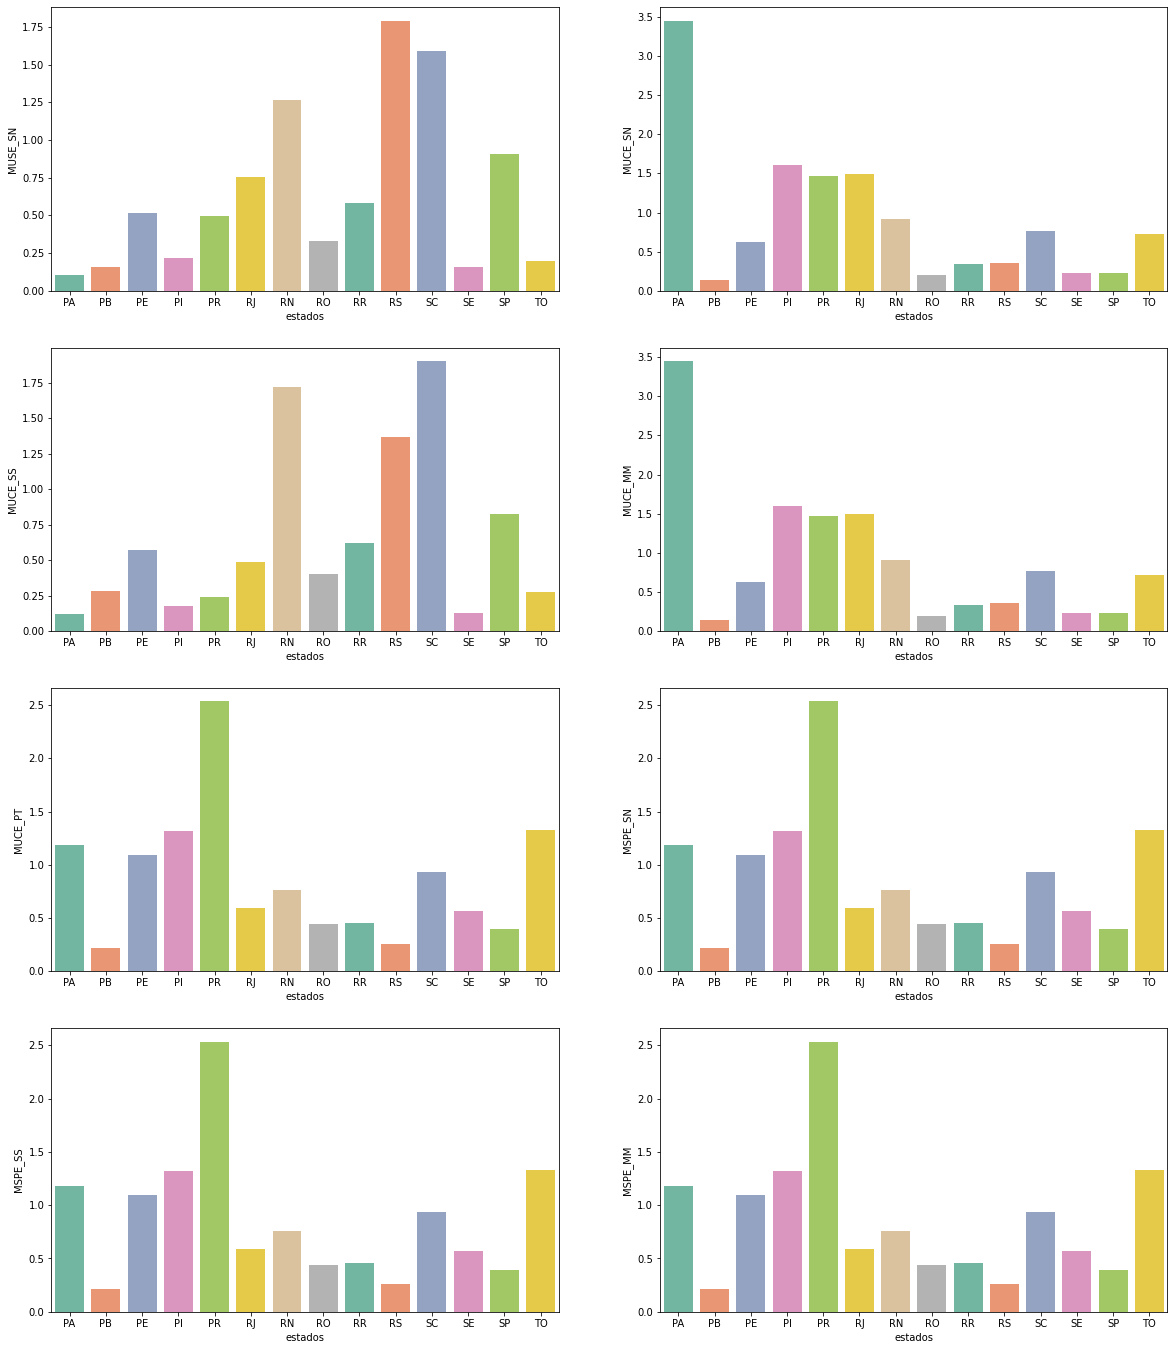

In [ ]:
plt.figure(figsize=(20,24))

for i in range(8):

    plt.subplot(4,2,i+1)

    sns.barplot(data=df_error[df_error["indicador"] == "MAPE"], x="estados", y=df_error.columns[2+i], palette="Set2", ci=None)

plt.show()

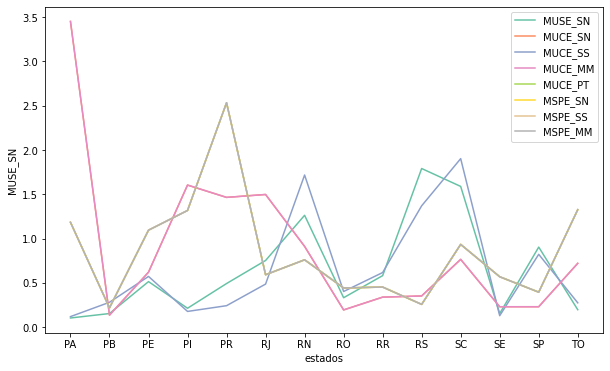

In [ ]:
plt.figure(figsize=(10,6))

for i in range(8):

    sns.lineplot(data=df_error[df_error["indicador"] == "MAPE"], x="estados", y=df_error.columns[2+i], palette="Set2", ci=None, label=df_error.columns[2+i])

plt.legend()

plt.show()